# Import Required Libraries
Import the necessary libraries, including pandas.

In [24]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import permutations
from scipy import stats
import seaborn as sns


# Read Excel File
Use pandas to read the Excel file located in the 'data' folder.

In [25]:
# Read the Excel file located in the 'data' folder
file_path = '../data/thesis_data.xlsx'

df_ftse100 = pd.read_excel(file_path, sheet_name='FTSE100')
df_sp500 = pd.read_excel(file_path, sheet_name='S&P500')
df_rf_GB = pd.read_excel(file_path, sheet_name='GB6MT')
df_rf_US = pd.read_excel(file_path, sheet_name='US3MT')


# Data Clean Up
Make sure that the only ones that are columns that are left have valid data during the entire period

# 

In [26]:
# Remove the columns for which the first value is a NaN
df_ftse100 = df_ftse100.loc[:, ~df_ftse100.iloc[0].isna()]
df_sp500 = df_sp500.loc[:, ~df_sp500.iloc[0].isna()]

In [27]:
def drop_columns_with_consecutive_nans(df, max_consecutive_nans):
    cols_to_drop = []

    # Iterate through each column (skip 'Timestamp')
    for col in df.columns:
        if col != 'Timestamp':
            # Convert the column to a boolean series where True means NaN
            is_nan = df[col].isnull()

            # Count consecutive NaNs
            max_streak = 0
            current_streak = 0

            for val in is_nan:
                if val:  
                    current_streak += 1
                    max_streak = max(max_streak, current_streak)
                else:
                    current_streak = 0

            # If the max consecutive NaNs exceed the threshold, mark for dropping
            if max_streak > max_consecutive_nans:
                cols_to_drop.append(col)

    # Drop the marked columns
    df = df.drop(columns=cols_to_drop)
    
    return df

def fill_gaps_with_average(df):
    # Iterate over each column (skip the 'Timestamp' column)
    for col in df.columns:
        if col != 'Timestamp':
            for i in range(1, len(df) - 1):  # Start from 1 and go until len(df)-1 to avoid edge issues
                if pd.isnull(df[col].iloc[i]):
                    # Find previous valid value (the closest non-null value before the NaN)
                    prev_value = df[col].iloc[:i].dropna().iloc[-1] if i > 0 else np.nan

                    # Find next valid value (the closest non-null value after the NaN)
                    next_value = df[col].iloc[i:].dropna().iloc[0] if i < len(df) - 1 else np.nan

                    # Fill NaN with the average if both values are valid
                    if not pd.isnull(prev_value) and not pd.isnull(next_value):
                        df.at[i, col] = (prev_value + next_value) / 2
                        
    return df

In [28]:
def fill_missing_dates_and_interpolate(df_stocks, df_rf):
    # Convert date columns to datetime
    dates_stocks = pd.to_datetime(df_stocks.iloc[:, 0])
    dates_rf = pd.to_datetime(df_rf.iloc[:, 0])

    # Find missing dates
    missing_dates = dates_stocks[~dates_stocks.isin(dates_rf)]

    # Create a DataFrame with missing dates
    missing_df = pd.DataFrame({
        df_rf.columns[0]: missing_dates
    })

    # Append missing dates to the risk-free DataFrame
    df_rf = pd.concat([df_rf, missing_df], ignore_index=True)

    # Sort by date
    df_rf.sort_values(by=df_rf.columns[0], inplace=True)

    # Reset index after sorting
    df_rf.reset_index(drop=True, inplace=True)

    # Fill missing values using the average method
    df_rf = fill_gaps_with_average(df_rf)

    # Keep only dates that exist in the stock data
    df_rf = df_rf[df_rf[df_rf.columns[0]].isin(dates_stocks)].reset_index(drop=True)

    return df_rf

In [29]:
df_ftse100 = drop_columns_with_consecutive_nans(df_ftse100, 1)
df_sp500 = drop_columns_with_consecutive_nans(df_sp500, 1)

df_ftse100 = fill_gaps_with_average(df_ftse100)
df_sp500 = fill_gaps_with_average(df_sp500)

df_rf_GB = fill_missing_dates_and_interpolate(df_ftse100, df_rf_GB)
df_rf_US = fill_missing_dates_and_interpolate(df_sp500, df_rf_US)

# Save the new aligned datasets to an Excel file for inspection
output_file = '../data/aligned_thesis_data.xlsx'
with pd.ExcelWriter(output_file) as writer:
    df_ftse100.to_excel(writer, sheet_name='FTSE100_Aligned', index=False)
    df_rf_GB.to_excel(writer, sheet_name='GB6MT_Aligned', index=False)
    df_sp500.to_excel(writer, sheet_name='S&P500_Aligned', index=False)
    df_rf_US.to_excel(writer, sheet_name='US3MT_Aligned', index=False)

# Remove the first column (assumed to be the date column)
df_ftse100_prices = df_ftse100.iloc[:, 1:] 
df_sp500_prices = df_sp500.iloc[:, 1:]  
df_rf_GB = df_rf_GB.iloc[:, 1]
df_rf_US = df_rf_US.iloc[:, 1]
#df_rf_US_weekly = df_rf_US_weekly.iloc[:, 1]
#df_rf_GB_weekly = df_rf_GB_weekly.iloc[:, 1]

# Remove the first row from risk-free datasets (text header)
df_rf_GB = df_rf_GB.iloc[1:].reset_index(drop=True)
df_rf_US = df_rf_US.iloc[1:].reset_index(drop=True)
#df_rf_US_weekly = df_rf_US_weekly.iloc[1:].reset_index(drop=True)
#df_rf_GB_weekly = df_rf_GB_weekly.iloc[1:].reset_index(drop=True)

# Convert risk-free rates from yearly percentage to daily and weekly rate (not percentage)
df_rf_GB = df_rf_GB.astype(float) / (252 * 100)  
df_rf_US = df_rf_US.astype(float) / (252 * 100)
#df_rf_US_weekly = df_rf_US_weekly.astype(float) / (52 * 100)
#df_rf_GB_weekly = df_rf_GB_weekly.astype(float) / (52 * 100)



In [30]:
# Optional: Count how many missing values were interpolated
missing_counts = {
    "FTSE100": df_ftse100.isna().sum().sum(),
    "S&P500": df_sp500.isna().sum().sum(),
    "GB6MT": df_rf_GB.isna().sum().sum(),
    "US3MT": df_rf_US.isna().sum().sum()
}
print("Missing values after interpolation:", missing_counts)

Missing values after interpolation: {'FTSE100': np.int64(0), 'S&P500': np.int64(0), 'GB6MT': np.int64(0), 'US3MT': np.int64(0)}


In [31]:
print(df_ftse100.iloc[:,0])

0      2005-02-21
1      2005-02-22
2      2005-02-23
3      2005-02-24
4      2005-02-25
          ...    
5055   2025-02-17
5056   2025-02-18
5057   2025-02-19
5058   2025-02-20
5059   2025-02-21
Name: Timestamp, Length: 5060, dtype: datetime64[ns]


# Returns and Excess Returns

In [32]:
# === DAILY RETURNS ===
df_ftse100_returns = np.log(df_ftse100_prices / df_ftse100_prices.shift(1)).iloc[1:, :]
df_sp500_returns = np.log(df_sp500_prices / df_sp500_prices.shift(1)).iloc[1:, :]

# Align daily risk-free rates
rf_GB_adjusted = df_rf_GB.values[:len(df_ftse100_returns)].reshape(-1, 1)
rf_US_adjusted = df_rf_US.values[:len(df_sp500_returns)].reshape(-1, 1)

# Daily excess returns
x_ftse100 = df_ftse100_returns.values - rf_GB_adjusted
x_sp500 = df_sp500_returns.values - rf_US_adjusted

# Daily excess return DataFrames
df_x_ftse100 = pd.DataFrame(x_ftse100, index=df_ftse100_returns.index, columns=df_ftse100_returns.columns)
df_x_sp500 = pd.DataFrame(x_sp500, index=df_sp500_returns.index, columns=df_sp500_returns.columns)

# === WEEKLY RETURNS from DAILY DATA (every 5th row) ===
# Take every 5th observation to simulate weekly sampling
df_ftse100_prices_weekly = df_ftse100_prices.iloc[::5, :]
df_sp500_prices_weekly = df_sp500_prices.iloc[::5, :]
df_rf_GB_weekly = df_rf_GB.iloc[::5] * 5
df_rf_US_weekly = df_rf_US.iloc[::5] * 5 # Adjust for weekly rate

# Compute weekly log returns
df_ftse100_returns_weekly = np.log(df_ftse100_prices_weekly / df_ftse100_prices_weekly.shift(1)).iloc[1:, :]
df_sp500_returns_weekly = np.log(df_sp500_prices_weekly / df_sp500_prices_weekly.shift(1)).iloc[1:, :]

# Align risk-free rates to weekly returns
rf_GB_weekly_adjusted = df_rf_GB_weekly.values[1:len(df_ftse100_returns_weekly)+1].reshape(-1, 1)
rf_US_weekly_adjusted = df_rf_US_weekly.values[1:len(df_sp500_returns_weekly)+1].reshape(-1, 1)

# Compute excess returns
x_ftse100_weekly = df_ftse100_returns_weekly.values - rf_GB_weekly_adjusted
x_sp500_weekly = df_sp500_returns_weekly.values - rf_US_weekly_adjusted

# Convert back to DataFrames
df_x_ftse100_weekly = pd.DataFrame(x_ftse100_weekly, index=df_ftse100_returns_weekly.index, columns=df_ftse100_returns_weekly.columns)
df_x_sp500_weekly = pd.DataFrame(x_sp500_weekly, index=df_sp500_returns_weekly.index, columns=df_sp500_returns_weekly.columns)

# Print results for verification
#print("Excess Returns for FTSE 100:\n", df_x_ftse100_weekly.head())
#print("Excess Returns for S&P 500:\n", df_x_sp500_weekly.head())
#print(df_ftse100_returns.head())
#print(df_sp500_returns.head())
print("Daily FTSE100 excess returns shape:", df_x_ftse100.shape)
print("Weekly FTSE100 excess returns shape:", df_x_ftse100_weekly.shape)
print("Difference in number of return observations:", df_x_ftse100.shape[0] - df_x_ftse100_weekly.shape[0])

Daily FTSE100 excess returns shape: (5059, 74)
Weekly FTSE100 excess returns shape: (1011, 74)
Difference in number of return observations: 4048


# Method Implementation (Including CV)
OLS, Ridge, Lasso, ElasticNet

In [33]:
def ols(X, y):
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    return model.coef_


In [34]:
def cross_validate_ridge(X, y, alpha_grid, cv=10):
    n = X.shape[0]
    scaling_factor = np.sqrt(2 * n)

    X = X * scaling_factor
    y = y * scaling_factor

    model = RidgeCV(alphas=alpha_grid, cv=cv, fit_intercept=False)
    model.fit(X, y)
    
    return model.alpha_, model.coef_


In [35]:
def cross_validate_elasticnet(X, y, alpha_grid, l1_ratio_grid, cv=10):
    n = X.shape[0]
    scaling_factor = np.sqrt(2 * n)

    X = X * scaling_factor
    y = y * scaling_factor

    model = ElasticNetCV(alphas=alpha_grid, l1_ratio=l1_ratio_grid,
                         cv=cv, fit_intercept=False, max_iter=10000)
    model.fit(X, y)
    
    return {'alpha': model.alpha_, 'l1_ratio': model.l1_ratio_}, model.coef_


In [36]:
def cross_validate_lasso(X, y, alpha_grid, cv=10):
    n = X.shape[0]
    scaling_factor = np.sqrt(2 * n)

    X = X * scaling_factor
    y = y * scaling_factor

    model = LassoCV(alphas=alpha_grid, cv=cv, fit_intercept=False, max_iter=10000)
    model.fit(X, y)
    #print("LassoCV iterations:", model.n_iter_)
    return model.alpha_, model.coef_




# Weight analysis

In [37]:
def weight_characteristics(
    norm_weights, counter, num_stocks,
    abs_weights_list, total_weights_list,
    max_longs, max_shorts, short_sizes, short_props,
    avg_weights, avg_max_longs, avg_max_shorts,
    avg_short_sizes, avg_short_props,
    turnover_list, avg_turnover_list, prev_weights
):
    abs_weight = np.abs(norm_weights)
    abs_weights_list.append(np.sum(abs_weight))
    total_weights_list.append(np.sum(norm_weights))

    rolling_average = np.sum(abs_weights_list) / (counter * num_stocks)
    avg_weights.append(rolling_average)

    max_weight = np.max(norm_weights)
    max_longs.append(max_weight)
    avg_max_longs.append(np.sum(max_longs) / counter)

    min_weight = np.min(norm_weights)
    max_shorts.append(min_weight)
    avg_max_shorts.append(np.sum(max_shorts) / counter)

    negative_weights = norm_weights[norm_weights < 0]
    short_size = np.mean(negative_weights) if len(negative_weights) > 0 else 0
    short_sizes.append(short_size)
    avg_short_sizes.append(np.sum(short_sizes) / counter)

    short_positions = (norm_weights < 0).astype(int)
    short_count = np.sum(short_positions)
    short_props.append(short_count)
    avg_short_props.append(np.sum(short_props) / (counter * num_stocks))

    # === Turnover ratio ===
    if prev_weights is not None:
        turnover = np.sum(np.abs(norm_weights - prev_weights))
        turnover_list.append(turnover)
        avg_turnover_list.append(np.sum(turnover_list) / counter)

    return norm_weights  # return current weights to update prev_weights








# Performance metrics

In [38]:
def compute_performance_metrics(out_of_sample_returns, MAR, risk_free_rate, T, market_name, frequency):
    # Set annualization factor based on frequency
    if frequency == "weekly":
        annualization_factor = 52
    else:
        annualization_factor = 252  # default to daily

    # Expected return per period (daily or weekly)
    expected_return = np.mean(out_of_sample_returns)

    # Sample variance
    variance = sum((r - expected_return) ** 2 for r in out_of_sample_returns) / (T - 1)

    # Annualization
    expected_return_annual = expected_return * annualization_factor
    variance_annual = variance * annualization_factor
    std_dev_annual = np.sqrt(variance_annual)

    # Sharpe ratio
    sharpe_ratio = (expected_return_annual - risk_free_rate * annualization_factor) / std_dev_annual

    # Sortino ratio
    downside_returns = [r - MAR for r in out_of_sample_returns if r < MAR]
    downside_std = np.sqrt(np.sum(np.square(downside_returns)) / T) if T > 1 else np.nan
    downside_std_annual = downside_std * np.sqrt(annualization_factor)
    sortino_ratio = (expected_return_annual - MAR * annualization_factor) / downside_std_annual if downside_std_annual != 0 else np.nan

    # Print results
    print(f"\nPerformance Metrics for {market_name}:")
    print(f"Annualized Expected Return: {expected_return_annual}")
    print(f"Annualized Variance: {variance_annual}")
    print(f"Annualized Std Dev: {std_dev_annual}")
    print(f"Sharpe Ratio: {sharpe_ratio}")
    print(f"Sortino Ratio: {sortino_ratio}")
    print(f"Number of Out-of-Sample Returns: {T}")

    return expected_return_annual, variance_annual, sharpe_ratio, sortino_ratio


# Plots

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_weight_characteristics_over_time_subsets(
    df_market, window_size,
    avg_weights, avg_max_longs, avg_max_shorts,
    avg_short_sizes, avg_short_props,
    turnover_ratios,
    title="Portfolio Weight Characteristics Over Time"
):
    start_plot_dates = window_size + 1
    time_steps = df_market.iloc[start_plot_dates:, 0].values

    # Sync everything to the same length
    min_len = min(
        len(time_steps),
        len(avg_weights),
        len(avg_max_longs),
        len(avg_max_shorts),
        len(avg_short_sizes),
        len(avg_short_props),
        len(turnover_ratios)
    )

    time_steps = time_steps[:min_len]
    avg_weights = avg_weights[:min_len]
    avg_max_longs = avg_max_longs[:min_len]
    avg_max_shorts = avg_max_shorts[:min_len]
    avg_short_sizes = avg_short_sizes[:min_len]
    avg_short_props = avg_short_props[:min_len]
    turnover_ratios = turnover_ratios[:min_len]

    fig, axes = plt.subplots(6, 1, figsize=(14, 20), sharex=True)
    fig.suptitle(title, fontsize=18)

    axes[0].plot(time_steps, avg_weights, color="blue")
    axes[0].set_title("Average Absolute Weight")

    axes[1].plot(time_steps, avg_max_longs, color="green")
    axes[1].set_title("Max Long Weight")

    axes[2].plot(time_steps, avg_max_shorts, color="red")
    axes[2].set_title("Max Short Weight")

    axes[3].plot(time_steps, avg_short_sizes, color="purple")
    axes[3].set_title("Average Short Size")

    axes[4].plot(time_steps, avg_short_props, color="orange")
    axes[4].set_title("Proportion of Short Positions")

    axes[5].plot(time_steps, turnover_ratios, color="brown")
    axes[5].set_title("Turnover Ratio")

    # Date formatting
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[-1].xaxis.set_major_locator(mdates.YearLocator())
    fig.autofmt_xdate()

    for ax in axes:
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()





# Rolling Window of subsets with all methods


# Plots for subsets

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_weight_characteristics_over_time_subsets(
    df_market, window_size,
    avg_weights, avg_max_longs, avg_max_shorts,
    avg_short_sizes, avg_short_props,
    turnover_ratios,
    title="Portfolio Weight Characteristics Over Time"
):
    start_plot_dates = window_size + 1
    time_steps = df_market.iloc[start_plot_dates:, 0].values

    # Sync everything to the same length
    min_len = min(
        len(time_steps),
        len(avg_weights),
        len(avg_max_longs),
        len(avg_max_shorts),
        len(avg_short_sizes),
        len(avg_short_props),
        len(turnover_ratios)
    )

    time_steps = time_steps[:min_len]
    avg_weights = avg_weights[:min_len]
    avg_max_longs = avg_max_longs[:min_len]
    avg_max_shorts = avg_max_shorts[:min_len]
    avg_short_sizes = avg_short_sizes[:min_len]
    avg_short_props = avg_short_props[:min_len]
    turnover_ratios = turnover_ratios[:min_len]

    fig, axes = plt.subplots(6, 1, figsize=(14, 20), sharex=True)
    fig.suptitle(title, fontsize=18)

    axes[0].plot(time_steps, avg_weights, color="blue")
    axes[0].set_title("Average Absolute Weight")

    axes[1].plot(time_steps, avg_max_longs, color="green")
    axes[1].set_title("Max Long Weight")

    axes[2].plot(time_steps, avg_max_shorts, color="red")
    axes[2].set_title("Max Short Weight")

    axes[3].plot(time_steps, avg_short_sizes, color="purple")
    axes[3].set_title("Average Short Size")

    axes[4].plot(time_steps, avg_short_props, color="orange")
    axes[4].set_title("Proportion of Short Positions")

    axes[5].plot(time_steps, turnover_ratios, color="brown")
    axes[5].set_title("Turnover Ratio")

    # Date formatting
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[-1].xaxis.set_major_locator(mdates.YearLocator())
    fig.autofmt_xdate()

    for ax in axes:
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()






# Plots for all markets combined

In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_summary_weight_characteristics(all_weights, all_market_dates):
    # Fixed market colors
    market_colors = {
        "GB_40_daily": "blue",
        "GB_60_daily": "green",
        "US_40_daily": "red",
        "US_60_daily": "orange",
        "GB_40_weekly": "purple",
        "GB_60_weekly": "darkgreen",     # updated from cyan
        "US_40_weekly": "magenta",
        "US_60_weekly": "darkorange",    # updated from yellow
        "US_200_weekly": "black"
    }

    metrics = [
        ("avg_weights", "Average Absolute Weight"),
        ("avg_max_longs", "Max Long Weight"),
        ("avg_max_shorts", "Max Short Weight"),
        ("avg_short_sizes", "Average Short Size"),
        ("avg_short_props", "Proportion of Short Positions"),
        ("avg_turnovers", "Turnover Ratio")
    ]

    methods = list(next(iter(all_weights.values())).keys())

    for method in methods:
        print(f"\n=== Summary plots for {method} ===")
        fig, axes = plt.subplots(6, 1, figsize=(14, 20), sharex=True)
        fig.suptitle(f"{method} – Comparison Across All Markets", fontsize=18)

        for idx, (metric_key, title) in enumerate(metrics):
            ax = axes[idx]
            for market_key, color in market_colors.items():
                if market_key not in all_weights:
                    continue  # Skip if that market wasn't run

                values = all_weights[market_key][method][metric_key]
                df = all_market_dates[market_key]

                start_plot_dates = 10 * (52 if "weekly" in market_key else 252) + 1
                time_steps = df.iloc[start_plot_dates:, 0].values

                min_len = min(len(values), len(time_steps))
                time_steps = time_steps[:min_len]
                values = values[:min_len]

                ax.plot(time_steps, values, label=market_key, color=color)

            ax.set_title(title)
            ax.set_ylabel("Value")
            ax.legend(loc="best")

        axes[-1].set_xlabel("Date")
        axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        axes[-1].xaxis.set_major_locator(mdates.YearLocator())
        fig.autofmt_xdate()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        fig.savefig(f"{method}_summary_comparison_all_markets.png", dpi=300)


# Two paired t-test

In [42]:
from itertools import permutations
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def run_ttests_and_plot_heatmaps(results, market_label, alpha=0.05):
    metrics = ["expected_return", "variance", "sharpe_ratio", "sortino_ratio"]
    method_pairs = list(permutations(results.keys(), 2))
    ttest_results = []

    # Run paired t-tests
    for metric in metrics:
        for method_a, method_b in method_pairs:
            if method_a == method_b:
                continue

            A = np.array(results[method_a][metric])
            B = np.array(results[method_b][metric])

            alternative = "less" if metric == "variance" else "greater"
            t_stat, p_val = stats.ttest_rel(A, B, alternative=alternative)

            ttest_results.append({
                "Metric": metric,
                "Method A": method_a,
                "Method B": method_b,
                "p-value": p_val,
            })

    df_ttest_results = pd.DataFrame(ttest_results)
    methods = list(results.keys())

    for metric in metrics:
        data = df_ttest_results[df_ttest_results["Metric"] == metric]
        heatmap_data = pd.DataFrame(index=methods, columns=methods, dtype=float)

        for _, row in data.iterrows():
            method_a = row["Method A"]
            method_b = row["Method B"]
            heatmap_data.loc[method_a, method_b] = row["p-value"]

        plt.figure(figsize=(8, 6))
        sns.heatmap(
            heatmap_data,
            annot=True,
            fmt=".5f",
            cmap="coolwarm_r",
            vmin=0,
            vmax=1,
            cbar_kws={"label": "p-value"}
        )
        plt.title(f"P-Values Heatmap: {metric} ({market_label})")
        plt.xlabel("Method B")
        plt.ylabel("Method A")
        plt.tight_layout()
        plt.show()



# Average Performance metric

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_average_performance_metrics(results, market_label):
    # Compute averages
    average_metrics = {
        "Method": [],
        "Expected Return": [],
        "Variance": [],
        "Sharpe Ratio": [],
        "Sortino Ratio": []
    }

    for method in results:
        average_metrics["Method"].append(method)
        average_metrics["Expected Return"].append(np.mean(results[method]["expected_return"]))
        average_metrics["Variance"].append(np.mean(results[method]["variance"]))
        average_metrics["Sharpe Ratio"].append(np.mean(results[method]["sharpe_ratio"]))
        average_metrics["Sortino Ratio"].append(np.mean(results[method]["sortino_ratio"]))

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Average Performance Metrics – {market_label}", fontsize=16)

    metrics_list = ["Expected Return", "Variance", "Sharpe Ratio", "Sortino Ratio"]
    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for metric, pos in zip(metrics_list, positions):
        ax = axes[pos]
        bars = ax.bar(average_metrics["Method"], average_metrics[metric], color='skyblue')
        ax.set_title(metric)
        ax.set_ylabel("Value")
        ax.set_xticks(range(len(average_metrics["Method"])))
        ax.set_xticklabels(average_metrics["Method"], rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Main function

In [44]:
from joblib import Parallel, delayed
import numpy as np
import random

def run_market_analysis(market_name, subset_size, num_subsets, frequency):
    print(f"\n\n=== Running market: {market_name}, Subset size: {subset_size}, Frequency: {frequency} ===")

    # === Parameters ===
    window_size = 10 * (52 if frequency == "weekly" else 252)
    step_size = 1

    # === Load correct datasets based on frequency ===
    if market_name == "GB":
        returns = df_ftse100_returns if frequency == "daily" else df_ftse100_returns_weekly
        excess_returns = df_x_ftse100 if frequency == "daily" else df_x_ftse100_weekly
        df_market = df_ftse100 if frequency == "daily" else df_ftse100.loc[df_ftse100_returns_weekly.index]
        rf = rf_GB_adjusted[-1][0] if frequency == "daily" else rf_GB_weekly_adjusted[-1][0]
        MAR = rf
    elif market_name == "US":
        returns = df_sp500_returns if frequency == "daily" else df_sp500_returns_weekly
        excess_returns = df_x_sp500 if frequency == "daily" else df_x_sp500_weekly
        df_market = df_sp500 if frequency == "daily" else df_sp500.loc[df_sp500_returns_weekly.index]
        rf = rf_US_adjusted[-1][0] if frequency == "daily" else rf_US_weekly_adjusted[-1][0]
        MAR = rf
    else:
        raise ValueError("Invalid market name. Use 'GB' or 'US'.")

    # === Subset setup ===
    stock_universe = excess_returns.columns.tolist()
    random_subsets = [random.sample(stock_universe, subset_size) for _ in range(num_subsets)]

    # === Methods setup ===
    methods = {
        "OLS": ols,
        "Ridge": cross_validate_ridge,
        "Lasso": cross_validate_lasso,
        "ElasticNet": cross_validate_elasticnet,
    }

    alpha_values_Lasso = np.logspace(-2, 0.3, 20)
    alpha_values_Elasticnet = np.logspace(-2, 0.3, 20)
    alpha_values_Ridge = np.logspace(0, 4, 20)
    l1_ratio_grid = np.linspace(0.1, 1.0, 10)

    results = {m: {"expected_return": [], "variance": [], "sharpe_ratio": [], "sortino_ratio": []} for m in methods}
    weight_data = {m: {} for m in methods}

    # === Function for single subset ===
    def run_subset(method_name, method_function, subset):
        X = excess_returns[subset]
        y = returns[subset]

        abs_weights_list, total_weights_list = [], []
        max_longs, max_shorts, short_sizes, short_props = [], [], [], []
        avg_weights, avg_max_longs, avg_max_shorts = [], [], []
        avg_short_sizes, avg_short_props = [], []
        turnover_list, avg_turnover_list = [], []

        counter = 0
        prev_weights = None
        out_of_sample_returns = []

        for start in range(0, len(X) - window_size, step_size):
            end = start + window_size
            X_train = X.iloc[start:end]
            y_out = y.iloc[end:end + window_size]
            target = np.ones(X_train.shape[0]) + np.random.normal(0, 0.01, X_train.shape[0])

            if method_name == "OLS":
                weights = method_function(X_train, target)
            elif method_name == "ElasticNet":
                _, weights = method_function(X_train, target, alpha_values_Elasticnet, l1_ratio_grid)
            elif method_name == "Ridge":
                _, weights = method_function(X_train, target, alpha_values_Ridge)
            else:
                _, weights = method_function(X_train, target, alpha_values_Lasso)

            norm_weights = weights / np.sum(weights)
            counter += 1

            norm_weights = weight_characteristics(
                norm_weights, counter, len(subset),
                abs_weights_list, total_weights_list,
                max_longs, max_shorts, short_sizes, short_props,
                avg_weights, avg_max_longs, avg_max_shorts,
                avg_short_sizes, avg_short_props,
                turnover_list, avg_turnover_list, prev_weights
            )
            prev_weights = norm_weights.copy()

            ret_today = y_out.iloc[0]
            out_of_sample_returns.append(ret_today.dot(norm_weights))

        T_counter = counter
        expected_return, variance, sharpe, sortino = compute_performance_metrics(
            out_of_sample_returns, MAR, rf, T_counter,
            market_name=f"{market_name} ({frequency})", frequency=frequency
        )


        return {
            "avg_weights": avg_weights,
            "avg_max_longs": avg_max_longs,
            "avg_max_shorts": avg_max_shorts,
            "avg_short_sizes": avg_short_sizes,
            "avg_short_props": avg_short_props,
            "avg_turnovers": avg_turnover_list,
            "expected_return": expected_return,
            "variance": variance,
            "sharpe_ratio": sharpe,
            "sortino_ratio": sortino
        }

    # === Run each method in parallel over subsets ===
    for method_name, method_function in methods.items():
        print(f"Running {method_name} for {market_name}-{subset_size} with {num_subsets} subsets...")
        parallel_results = Parallel(n_jobs=-1)(
            delayed(run_subset)(method_name, method_function, subset)
            for subset in random_subsets
        )

        # === Collect averaged weight data ===
        for metric_key in ["avg_weights", "avg_max_longs", "avg_max_shorts", "avg_short_sizes", "avg_short_props", "avg_turnovers"]:
            weight_data[method_name][metric_key] = np.mean([res[metric_key] for res in parallel_results], axis=0)

        if len(weight_data[method_name]["avg_turnovers"]) < len(weight_data[method_name]["avg_weights"]):
            weight_data[method_name]["avg_turnovers"] = [np.nan] + list(weight_data[method_name]["avg_turnovers"])

        # === Collect performance metrics ===
        for res in parallel_results:
            for metric_key in results[method_name]:
                results[method_name][metric_key].append(res[metric_key])

        # === Plot weights ===
        w = weight_data[method_name]["avg_weights"]
        ml = weight_data[method_name]["avg_max_longs"]
        ms = weight_data[method_name]["avg_max_shorts"]
        ss = weight_data[method_name]["avg_short_sizes"]
        sp = weight_data[method_name]["avg_short_props"]
        to = weight_data[method_name]["avg_turnovers"]

        n_steps = min(len(w), len(to))
        time_steps = df_market.iloc[window_size:window_size + n_steps, 0].index

        plot_weight_characteristics_over_time_subsets(
            df_market,
            window_size,
            w[:n_steps], ml[:n_steps], ms[:n_steps],
            ss[:n_steps], sp[:n_steps], to[:n_steps],
            title=f"{method_name} - Avg. Portfolio Characteristics ({market_name}, {subset_size}, {frequency})"
        )

    # === Print metrics ===
    for method, metrics in results.items():
        print(f"\nResults for {method} ({market_name}-{subset_size}, {frequency}):")
        print("Expected Return (Annualized):", metrics["expected_return"])
        print("Variance (Annualized):", metrics["variance"])
        print("Sharpe Ratio:", metrics["sharpe_ratio"])
        print("Sortino Ratio:", metrics["sortino_ratio"])

    # === Run t-tests + plot heatmaps and average metrics ===
    run_ttests_and_plot_heatmaps(results, market_label=f"{market_name}_{subset_size}_{frequency}")
    plot_average_performance_metrics(results, market_label=f"{market_name}_{subset_size}_{frequency}")

    return results, weight_data, df_market




In [45]:
import multiprocessing
print(multiprocessing.cpu_count())

12


# Run all markets at once



=== Running market: GB, Subset size: 40, Frequency: weekly ===
Running OLS for GB-40 with 32 subsets...


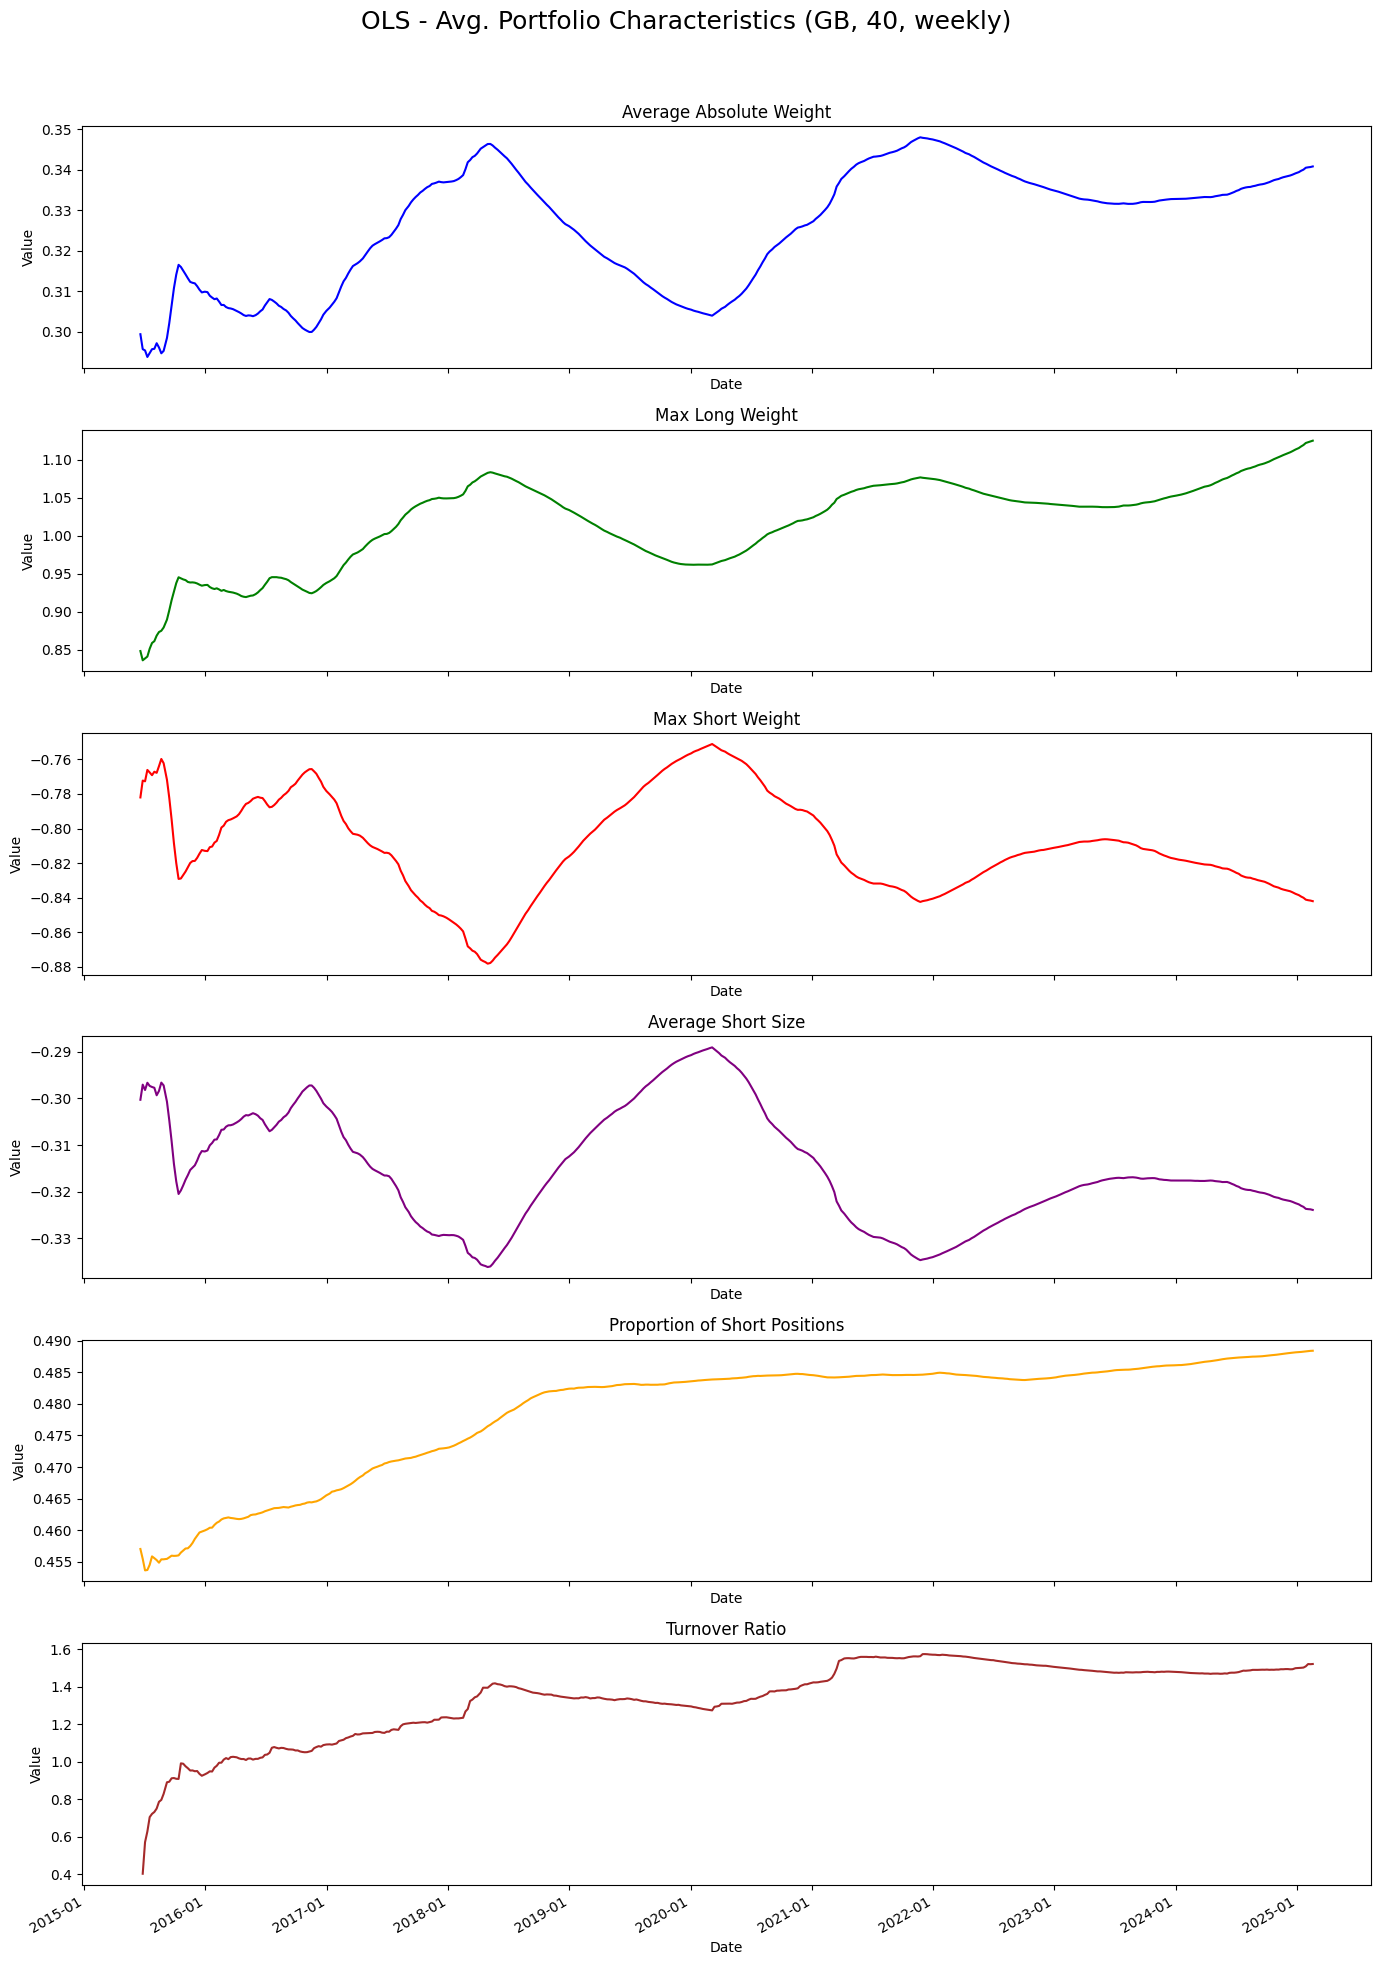

Running Ridge for GB-40 with 32 subsets...


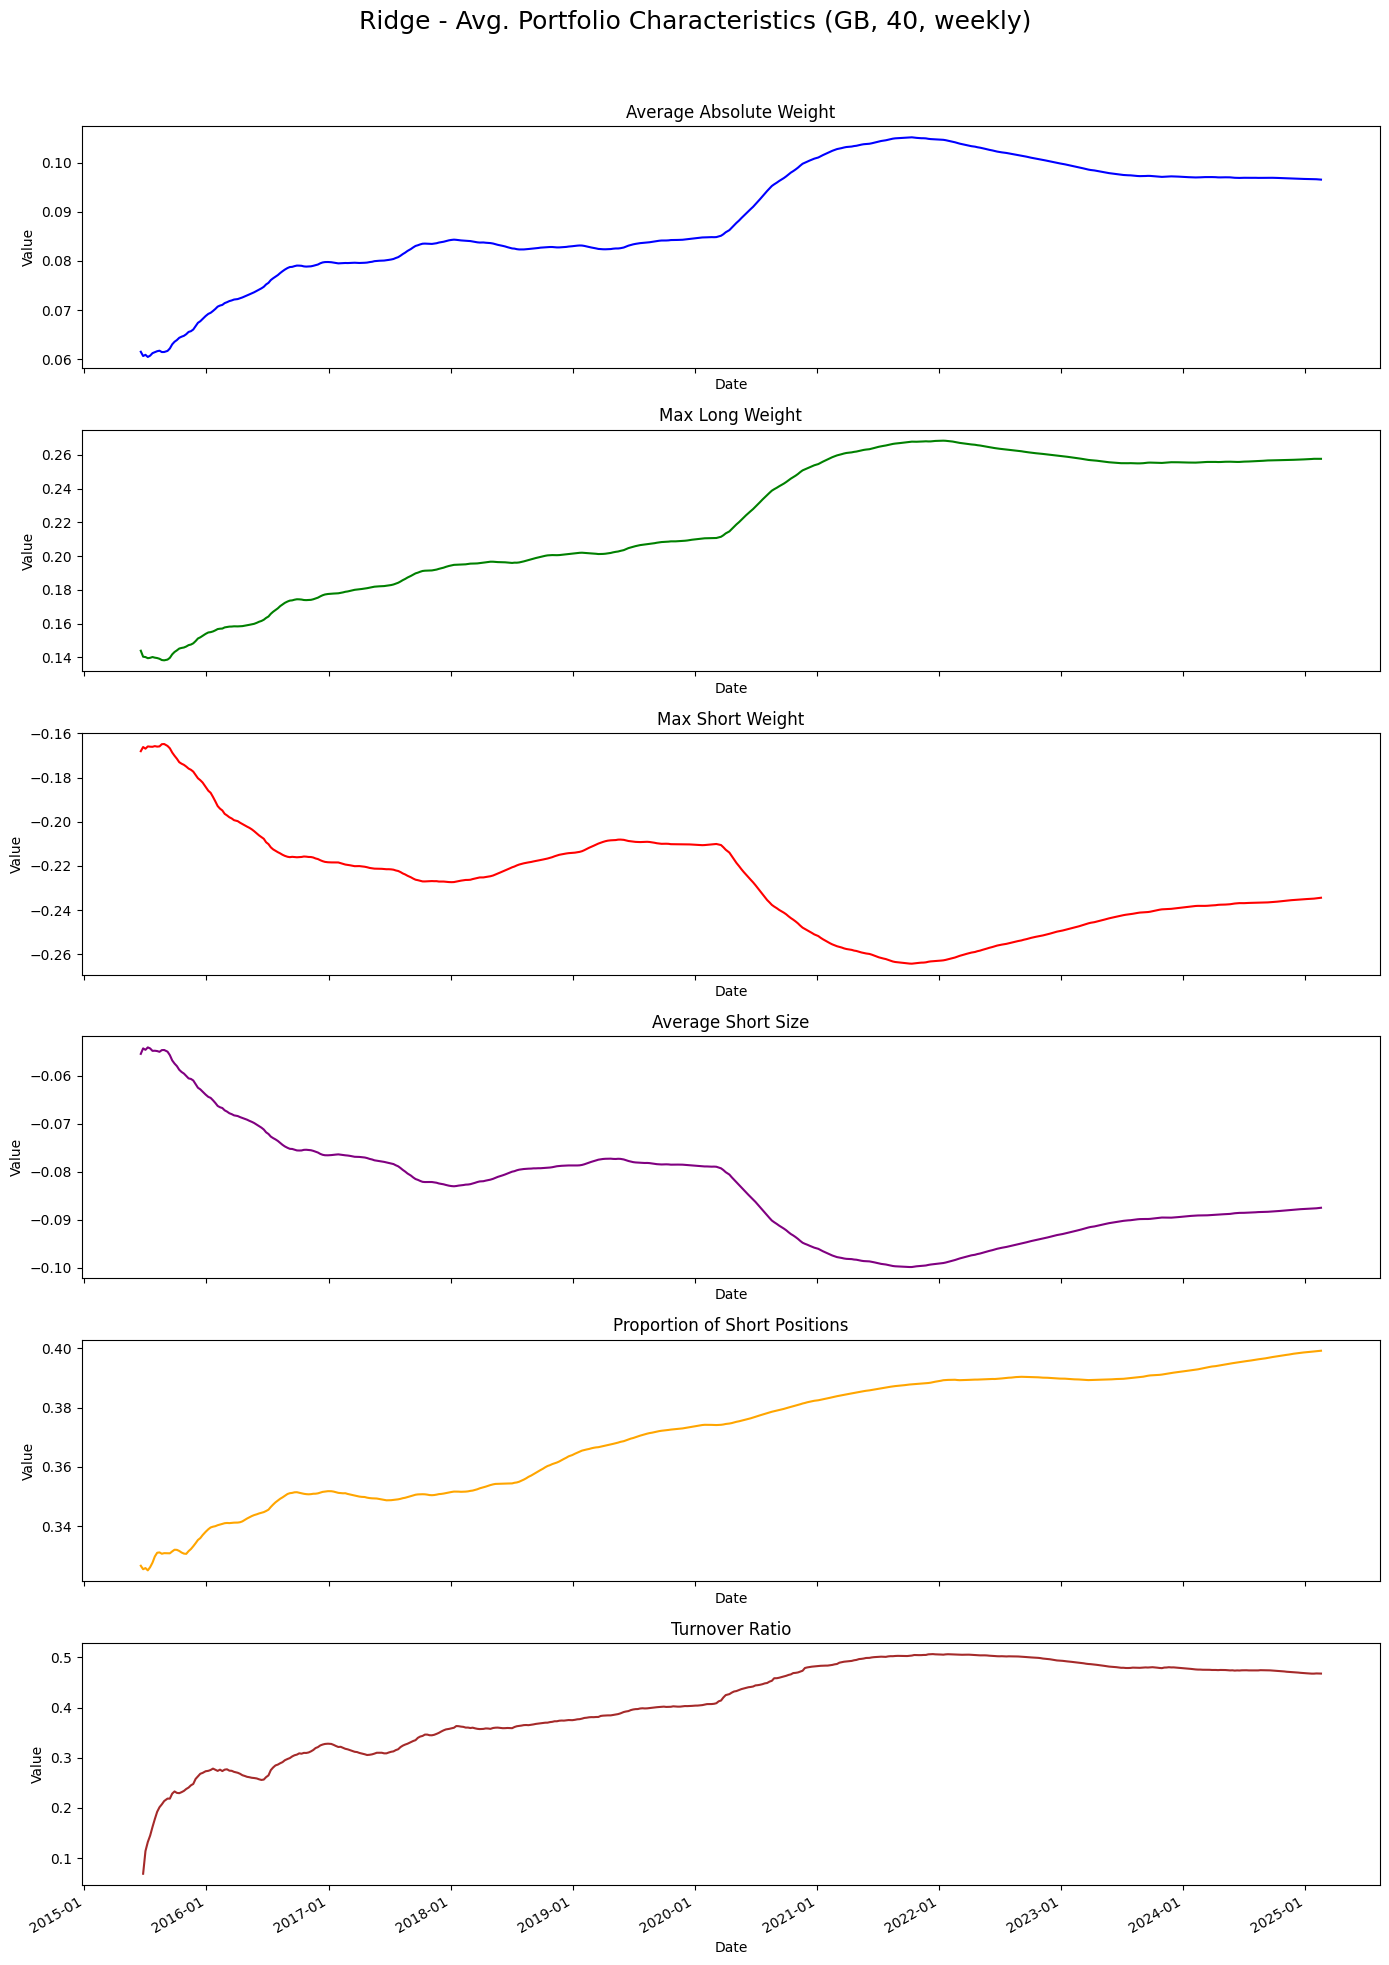

Running Lasso for GB-40 with 32 subsets...


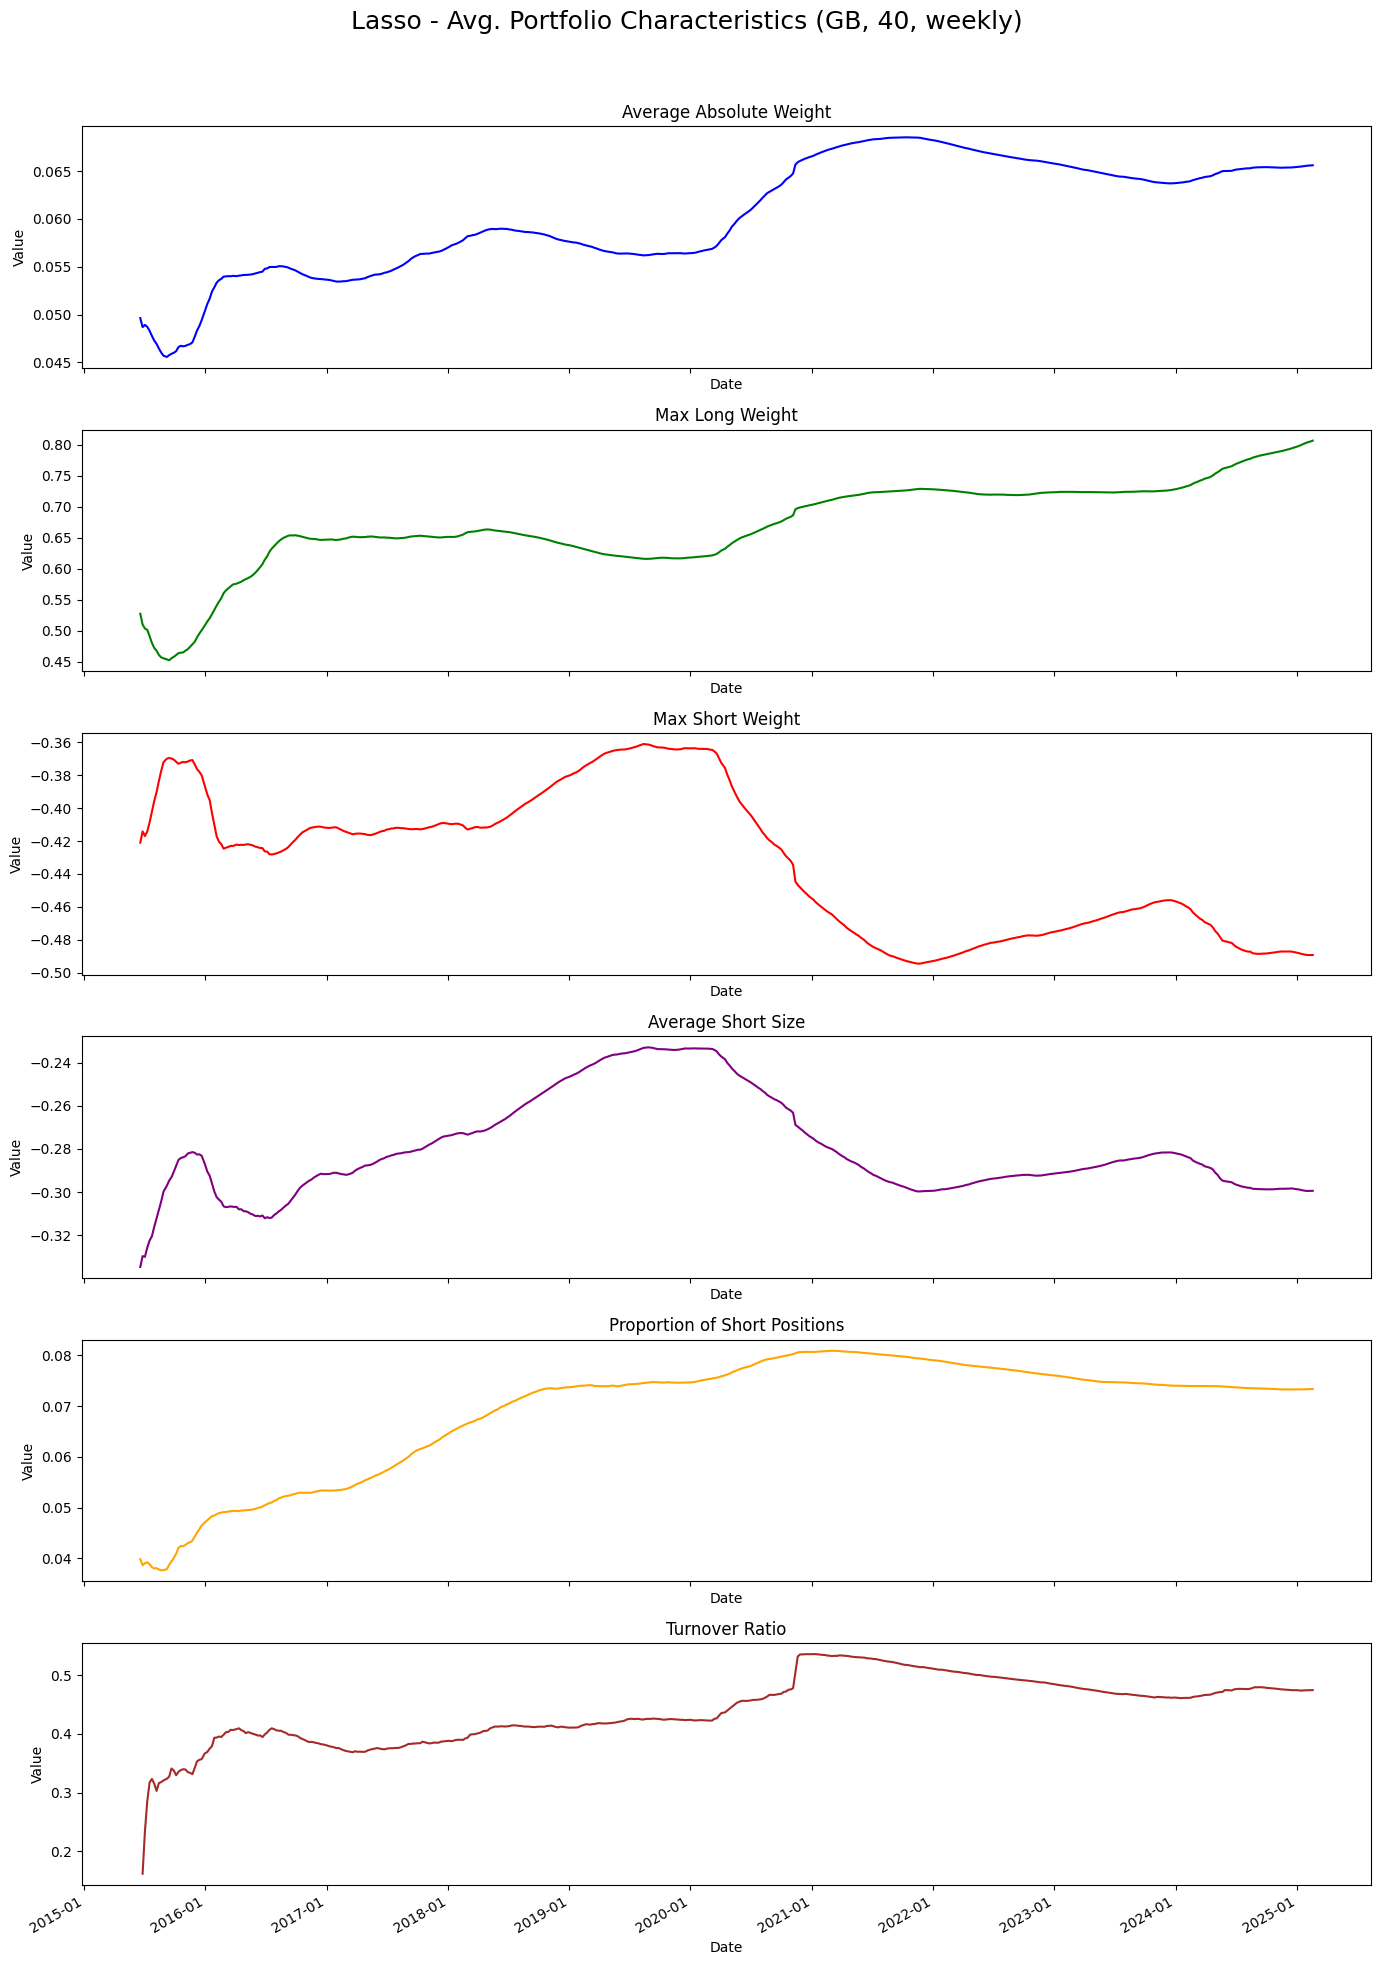

Running ElasticNet for GB-40 with 32 subsets...


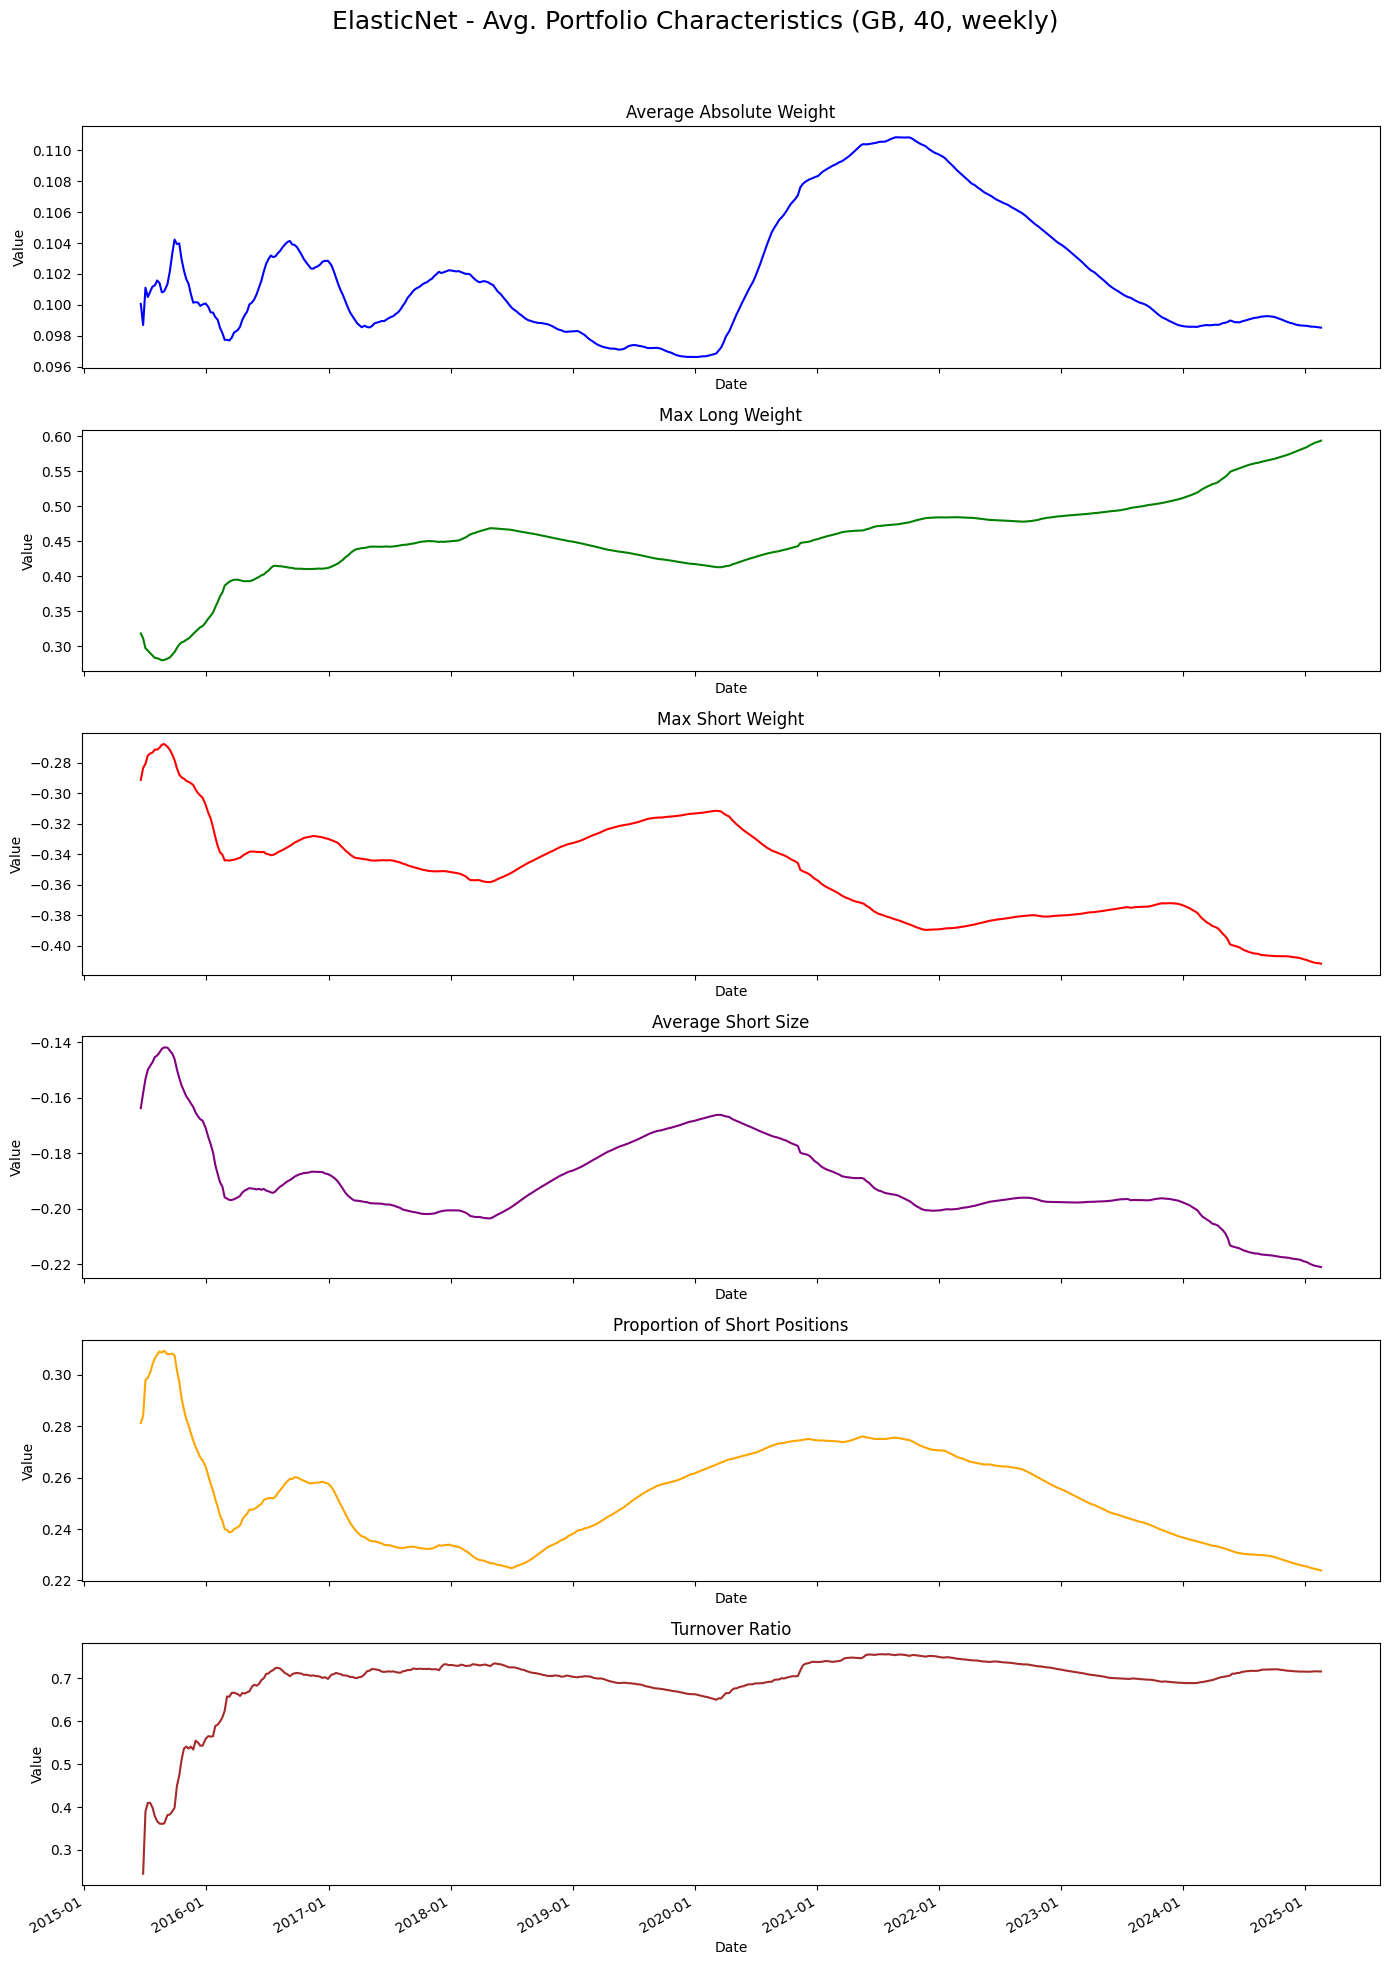


Results for OLS (GB-40, weekly):
Expected Return (Annualized): [np.float64(-0.3164807532950953), np.float64(0.37801467328694793), np.float64(0.40702941031793655), np.float64(0.41990884293848224), np.float64(0.2788535219004924), np.float64(0.16221885871038272), np.float64(0.3213670120140498), np.float64(0.10239903438784119), np.float64(0.5483193186222792), np.float64(0.559130080203592), np.float64(0.47159356161409083), np.float64(0.3779228146037261), np.float64(0.9692240695381352), np.float64(0.46592986545303783), np.float64(0.22551865272300237), np.float64(0.31732610594047445), np.float64(0.25114317406651476), np.float64(0.3539126277602391), np.float64(0.24141921504493982), np.float64(0.12714780104056927), np.float64(0.36224482505790906), np.float64(0.39476354586698964), np.float64(0.5262950262235269), np.float64(0.21232078038424865), np.float64(0.5748730194486239), np.float64(0.3120627452374874), np.float64(0.17541031342957406), np.float64(0.2368473904223227), np.float64(0.2408780455

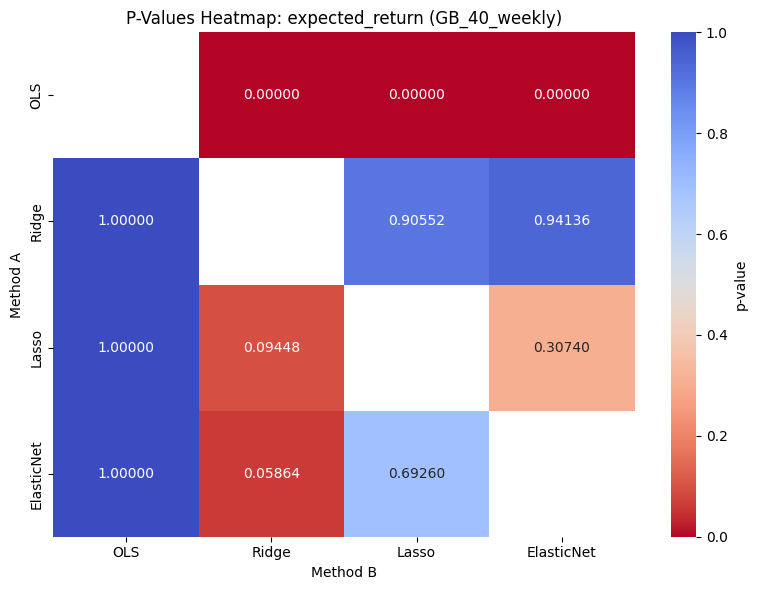

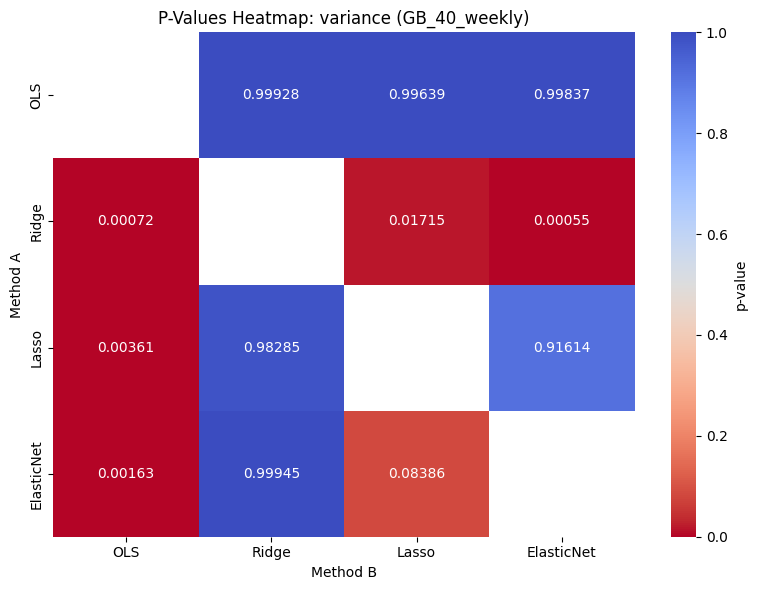

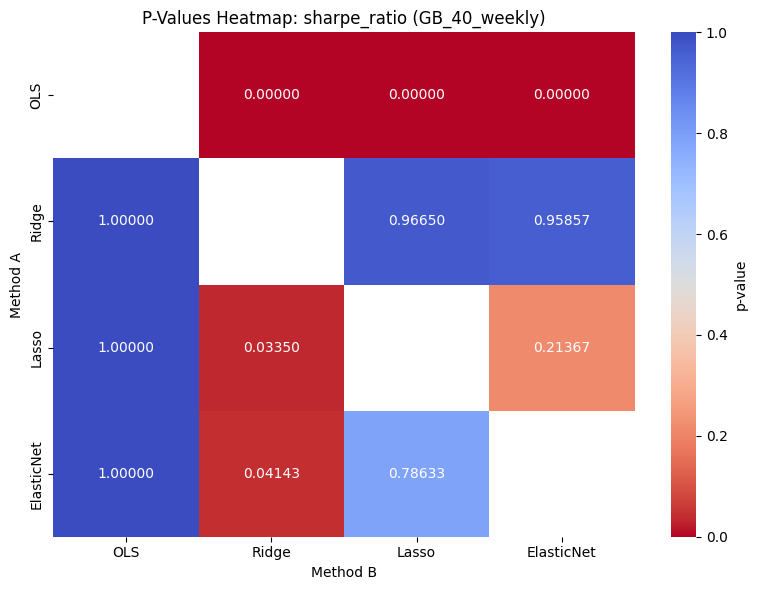

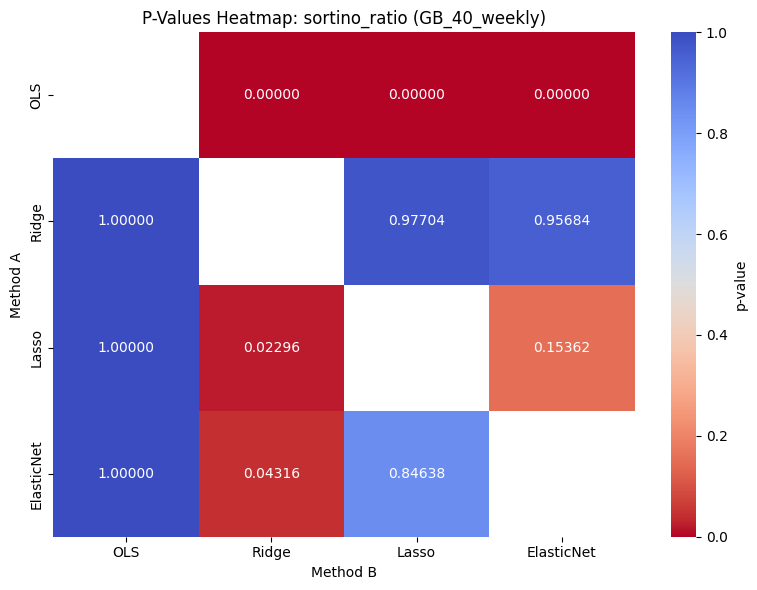

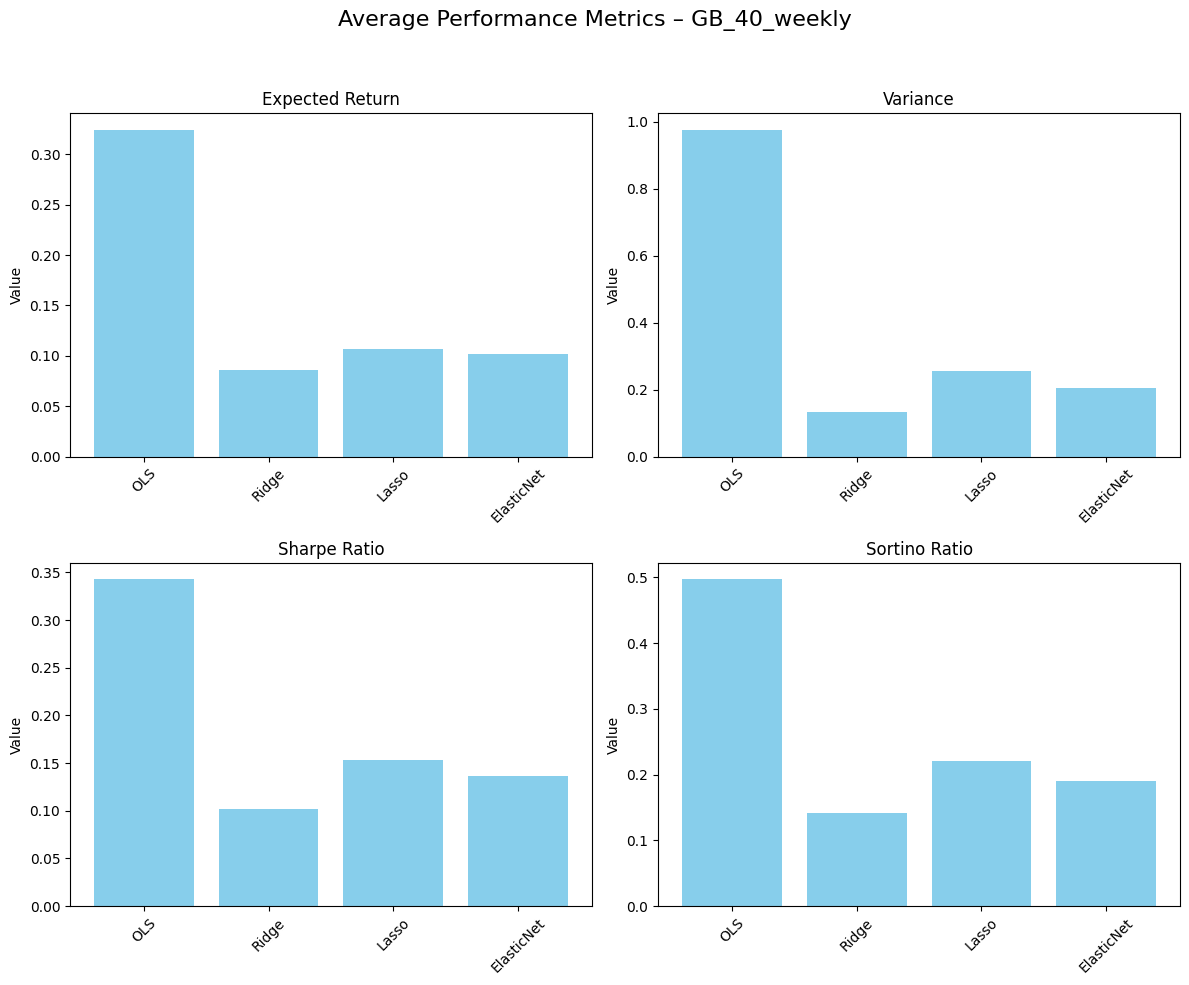



=== Running market: GB, Subset size: 60, Frequency: weekly ===
Running OLS for GB-60 with 32 subsets...


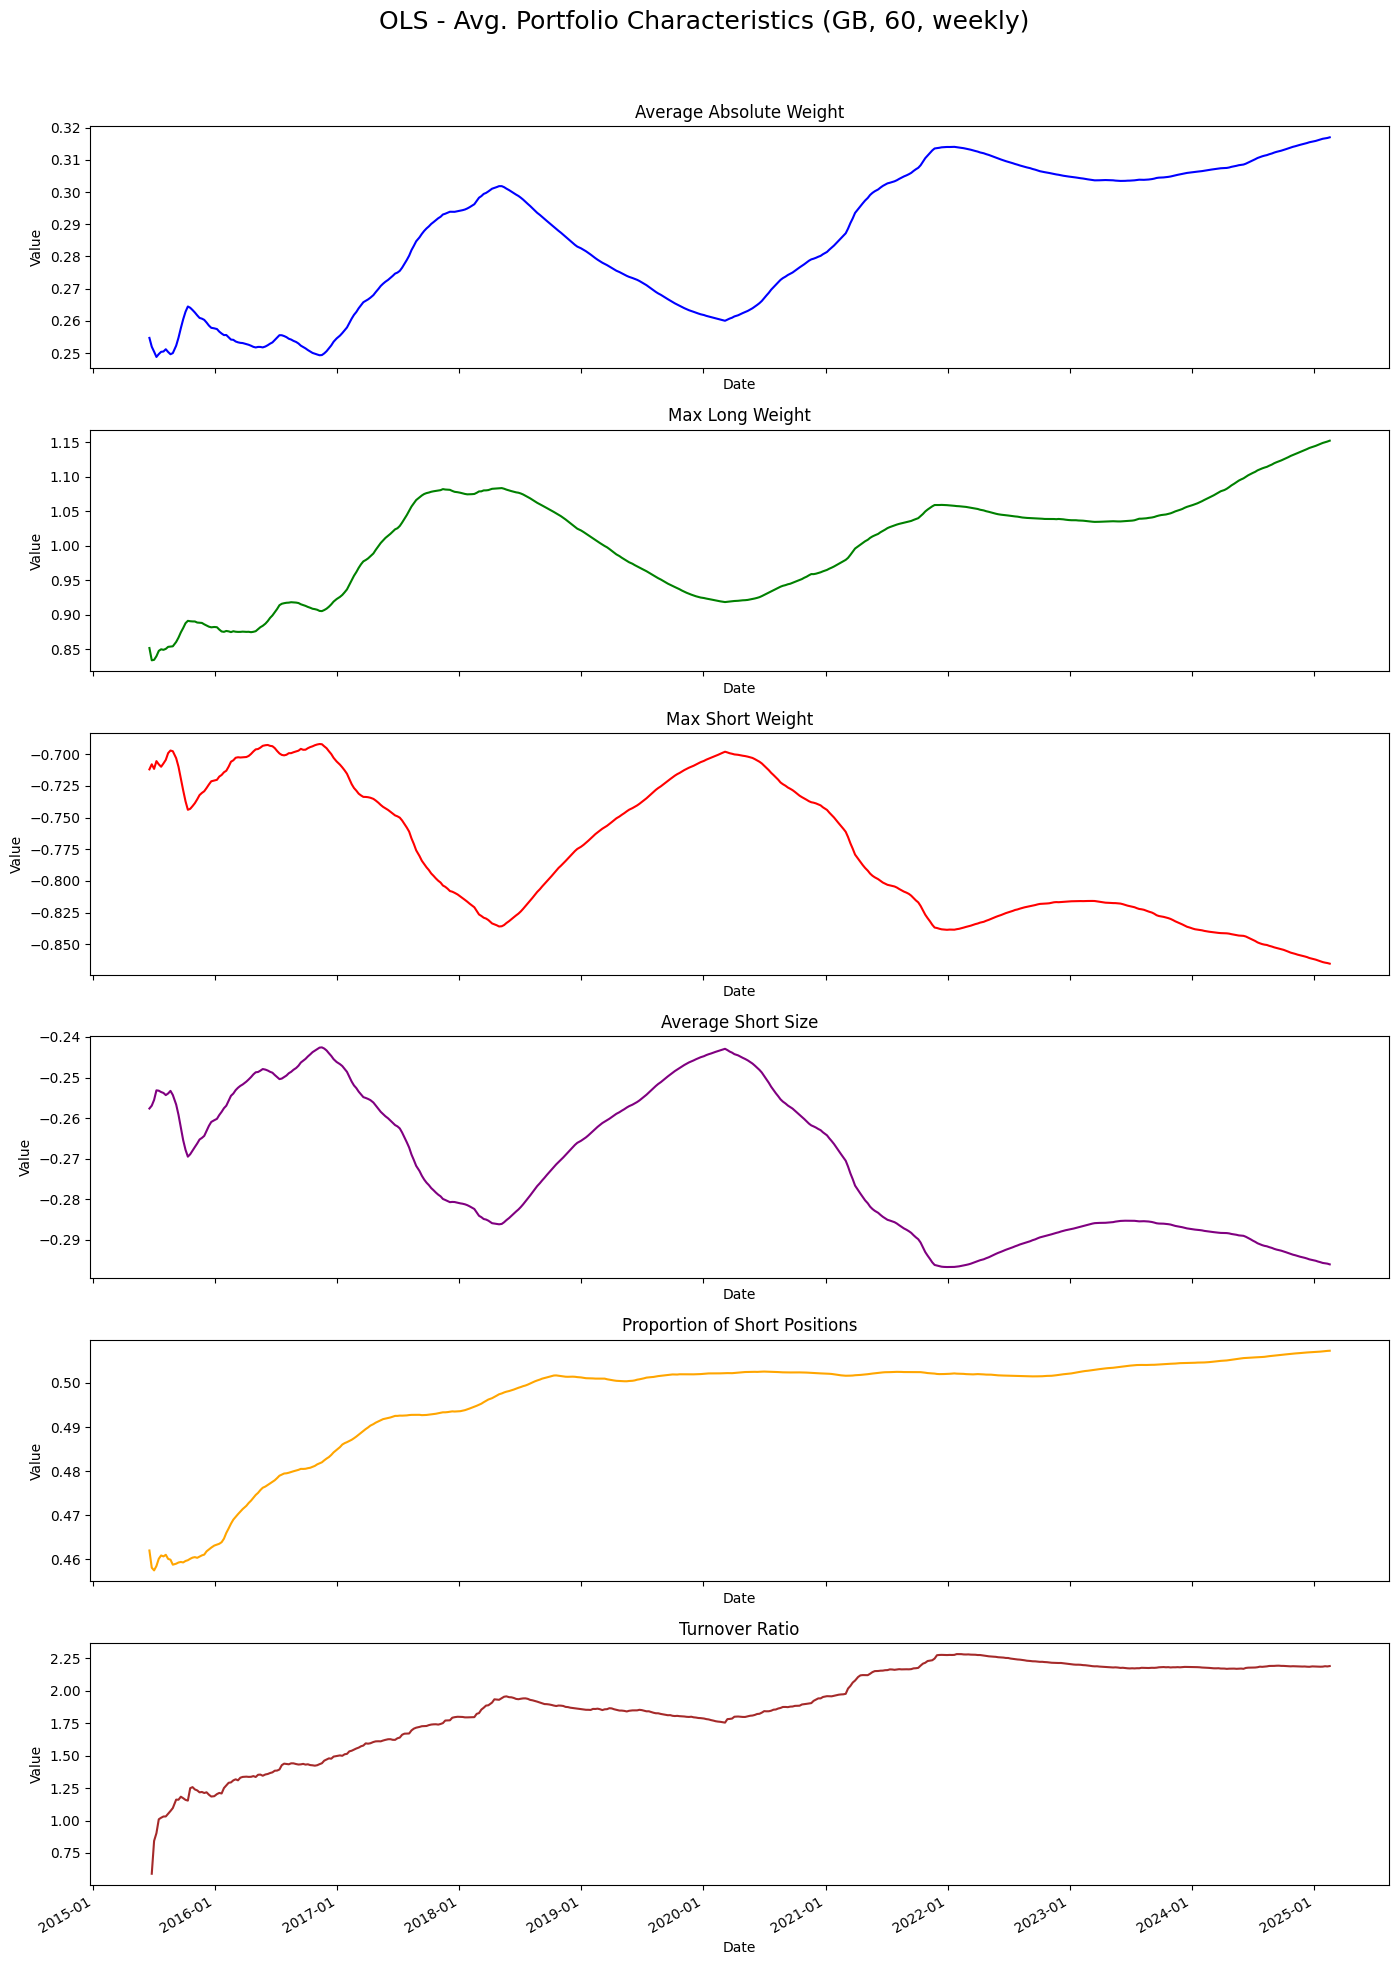

Running Ridge for GB-60 with 32 subsets...


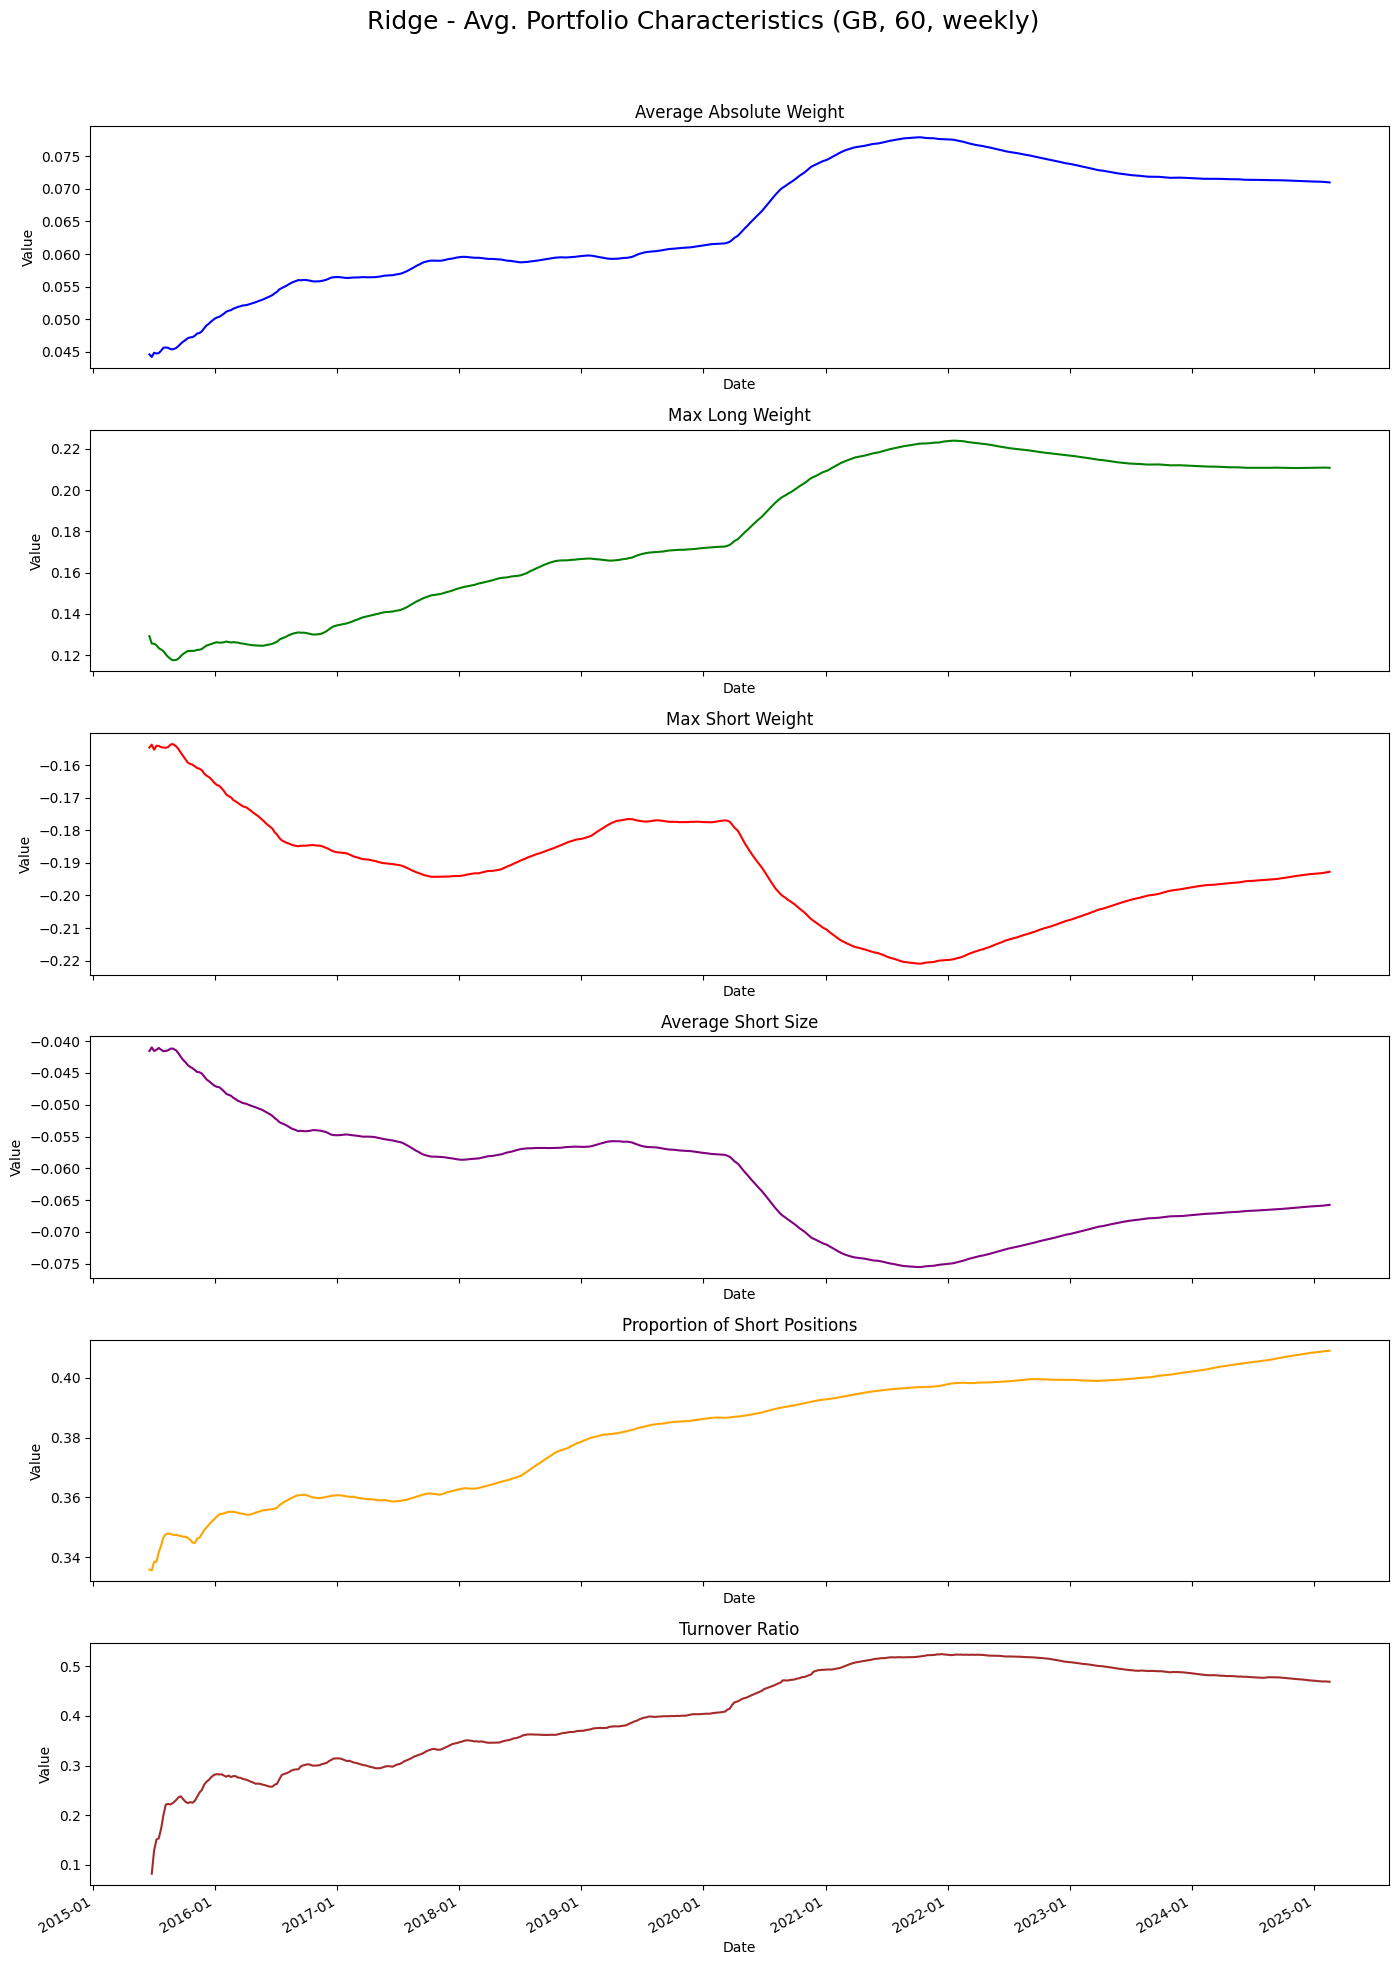

Running Lasso for GB-60 with 32 subsets...


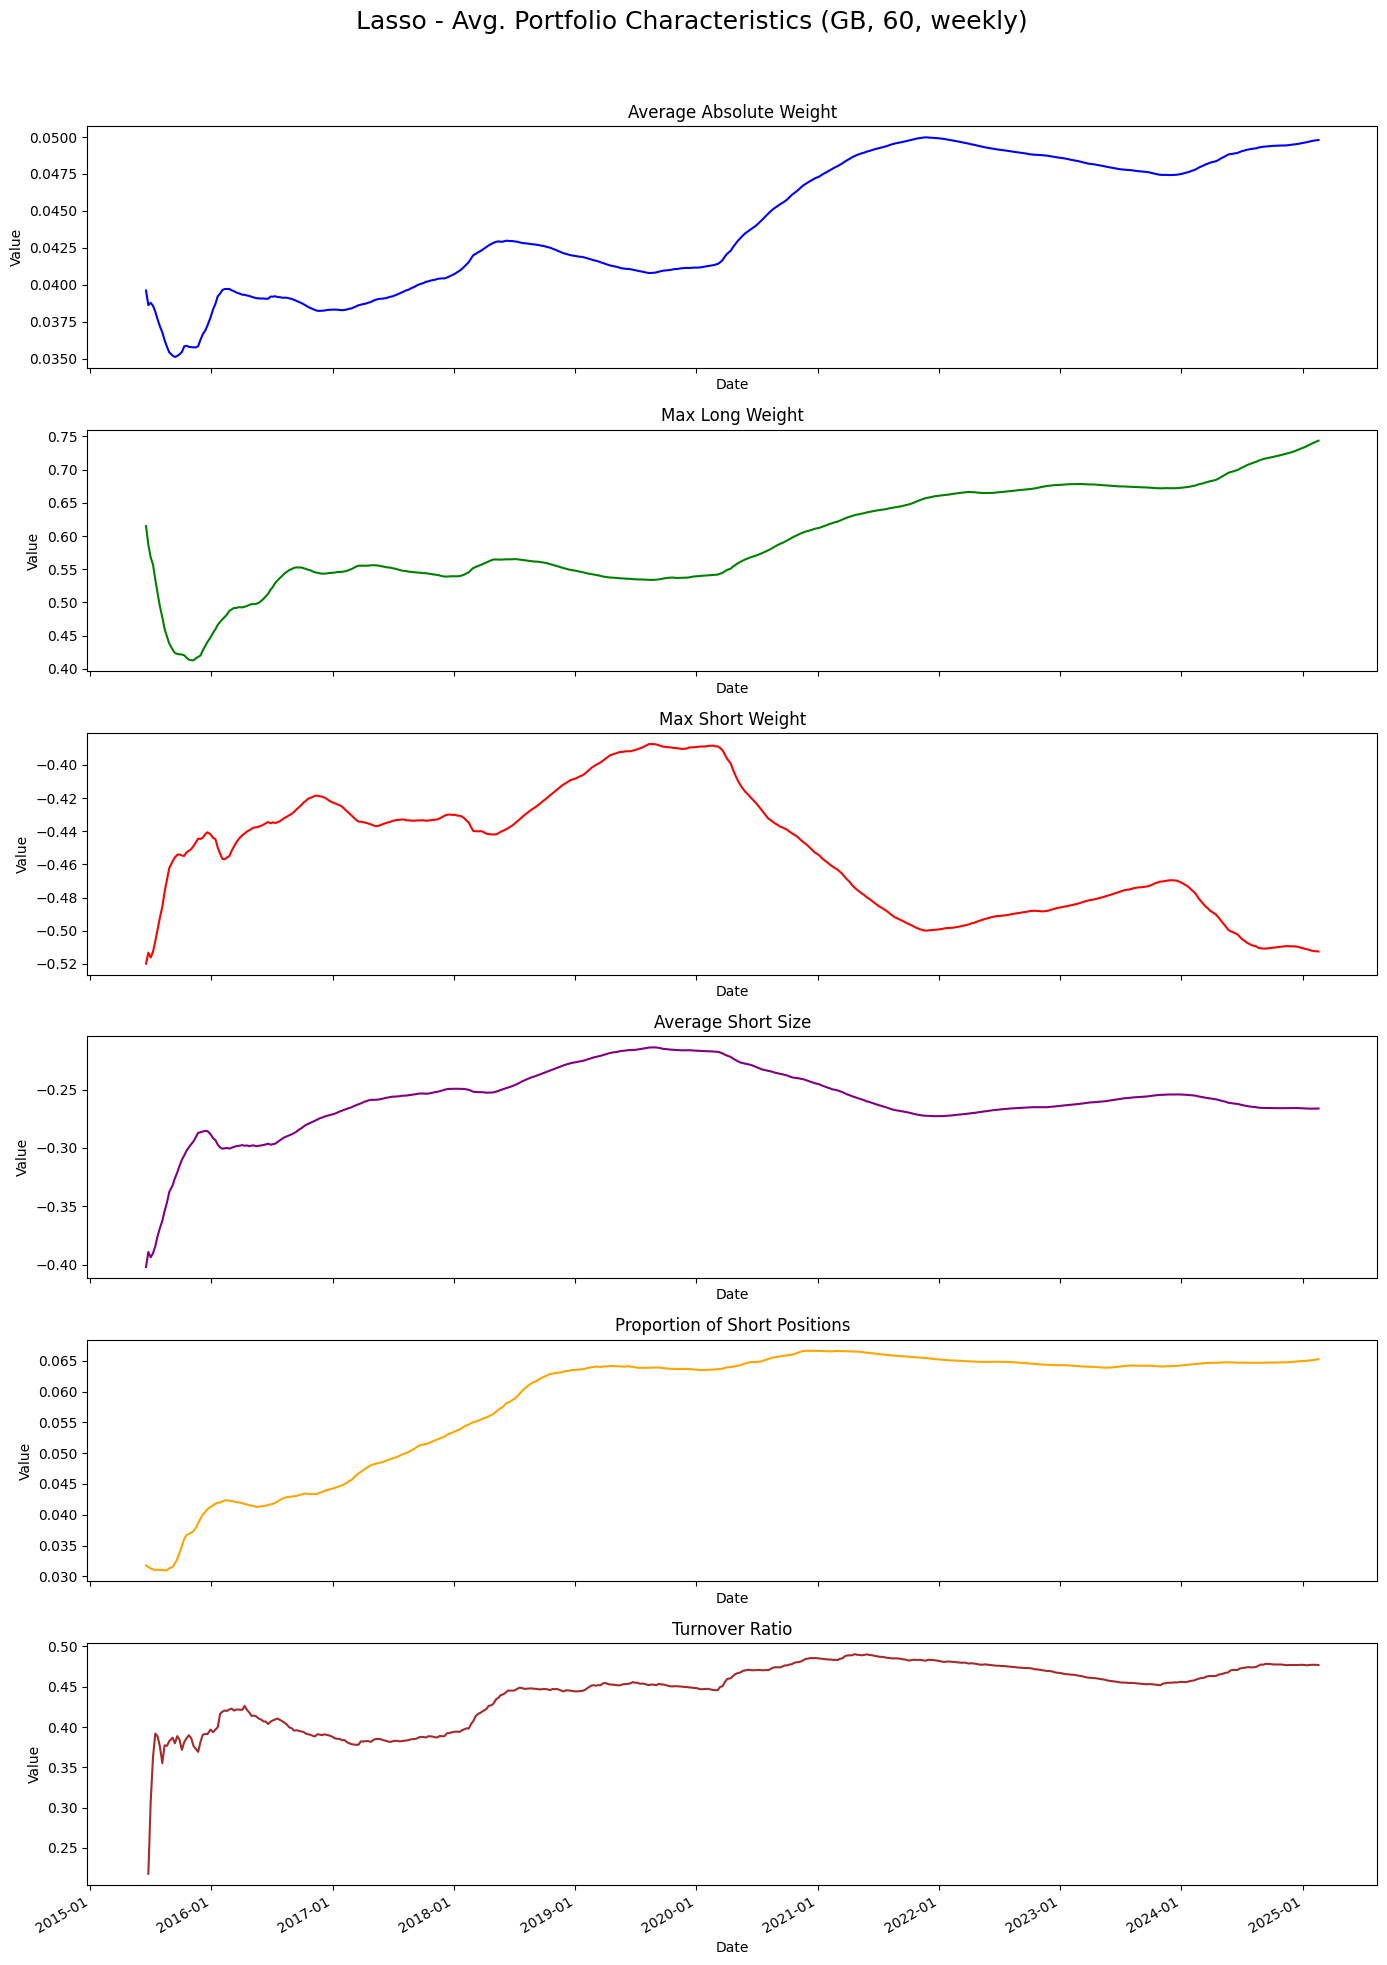

Running ElasticNet for GB-60 with 32 subsets...


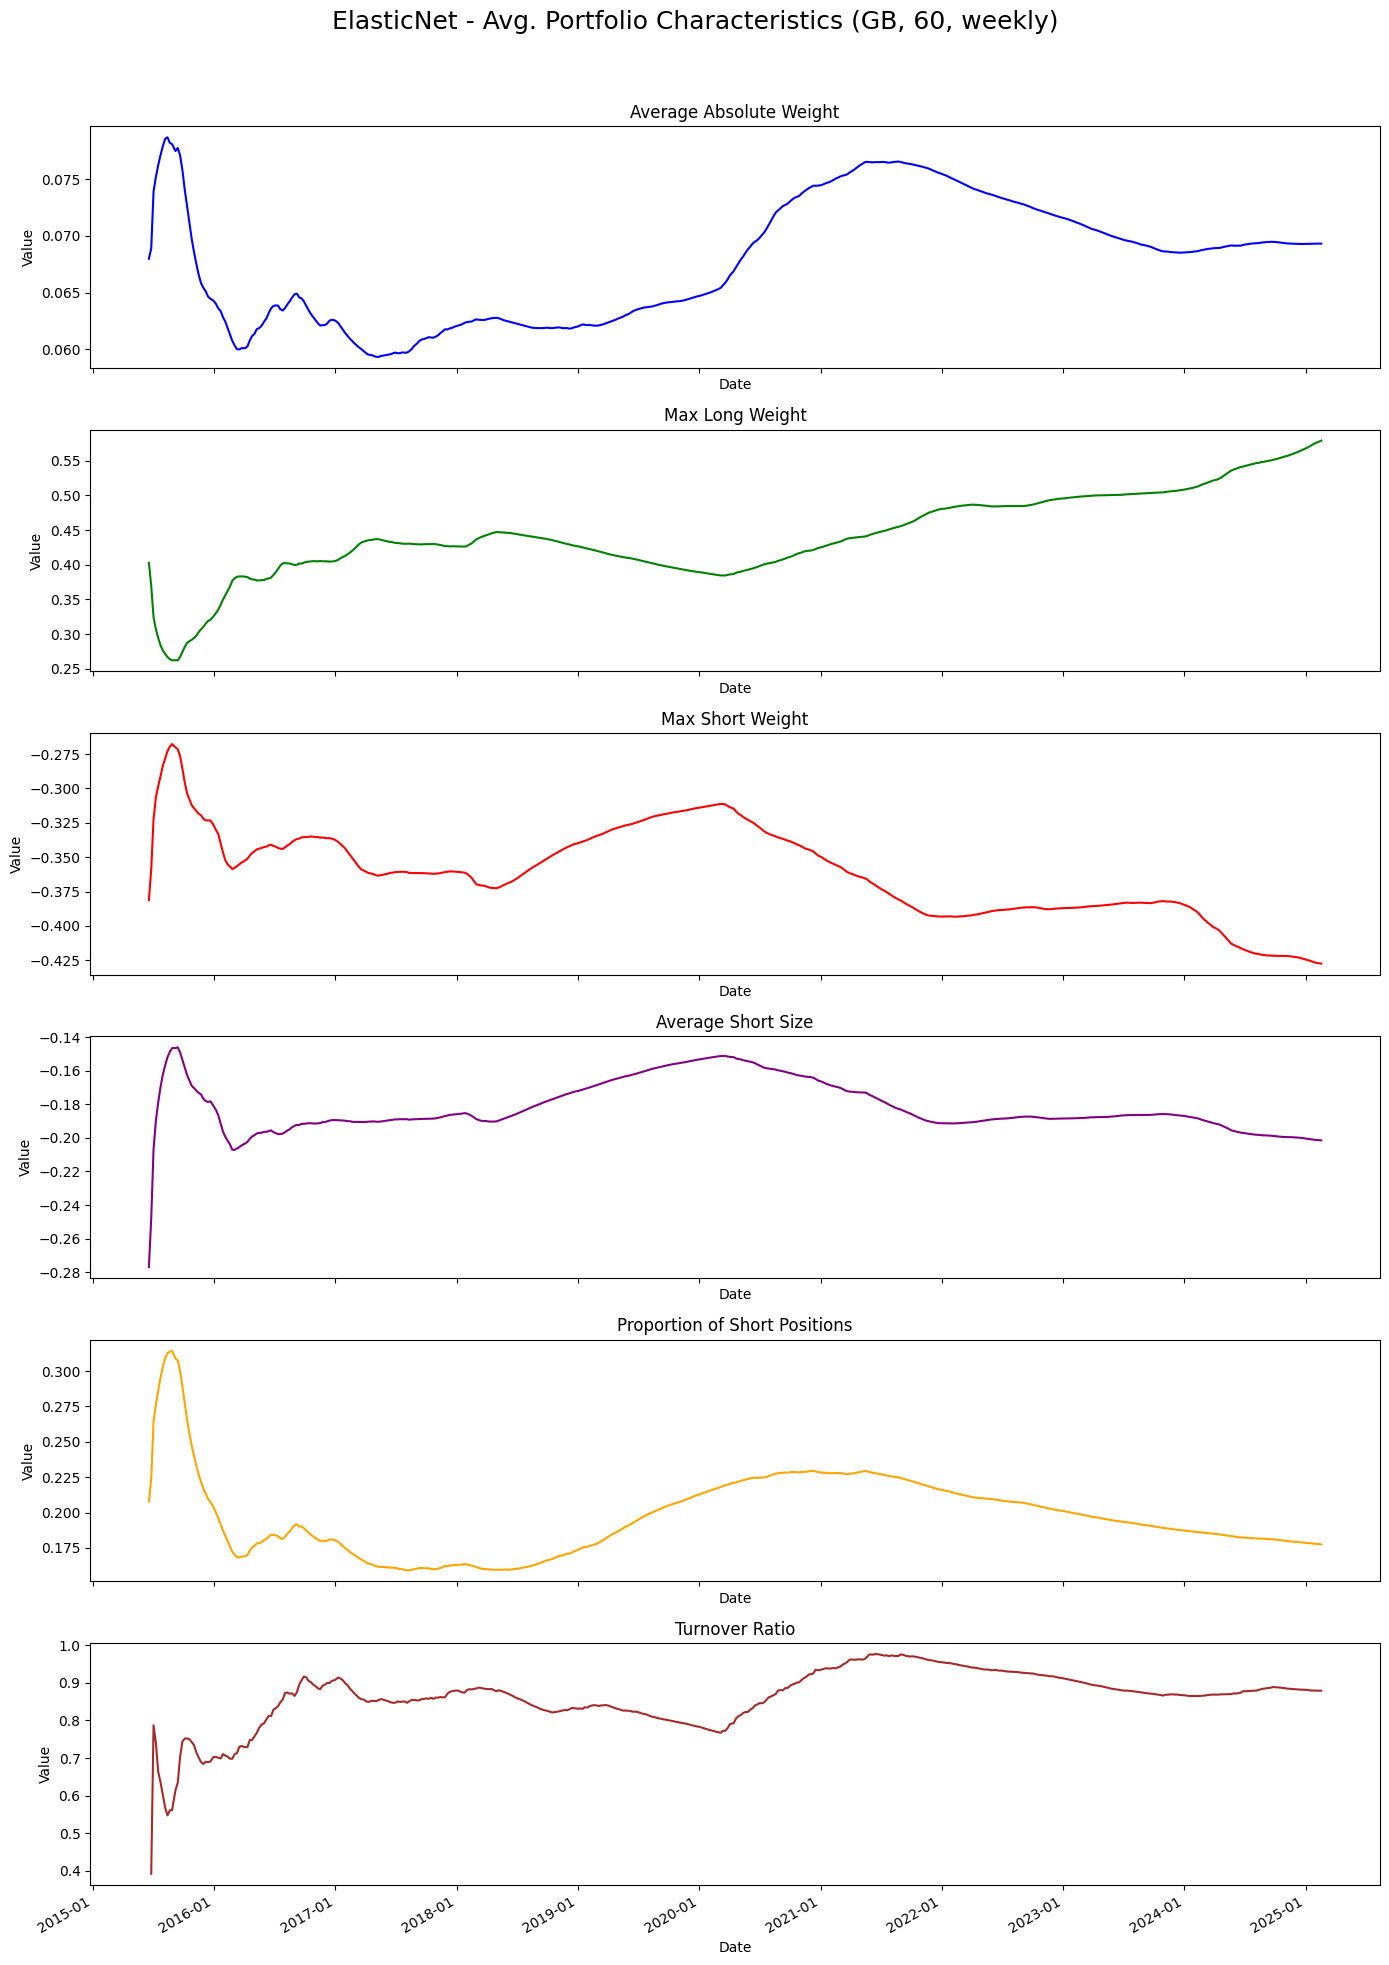


Results for OLS (GB-60, weekly):
Expected Return (Annualized): [np.float64(0.34939692964308233), np.float64(0.4761219339039429), np.float64(0.3362286087077616), np.float64(0.31533381857341336), np.float64(0.27741848747005077), np.float64(0.30339153570498406), np.float64(0.46110506963159836), np.float64(0.22805242177290588), np.float64(0.4056535206028336), np.float64(0.23188430347414185), np.float64(0.3337239597118342), np.float64(0.3348026790979954), np.float64(0.4001815938309321), np.float64(0.5188578448927936), np.float64(0.38560642237158005), np.float64(0.4325182584004851), np.float64(0.3732503191788843), np.float64(0.5369899700370905), np.float64(0.31955481312612405), np.float64(0.27756705990726993), np.float64(0.6101442202889814), np.float64(0.225206517909198), np.float64(0.5682881450442837), np.float64(0.5045024091676592), np.float64(0.4031103345804437), np.float64(0.4646423992646144), np.float64(0.3597212052530254), np.float64(0.3383017317281495), np.float64(0.514536064092848),

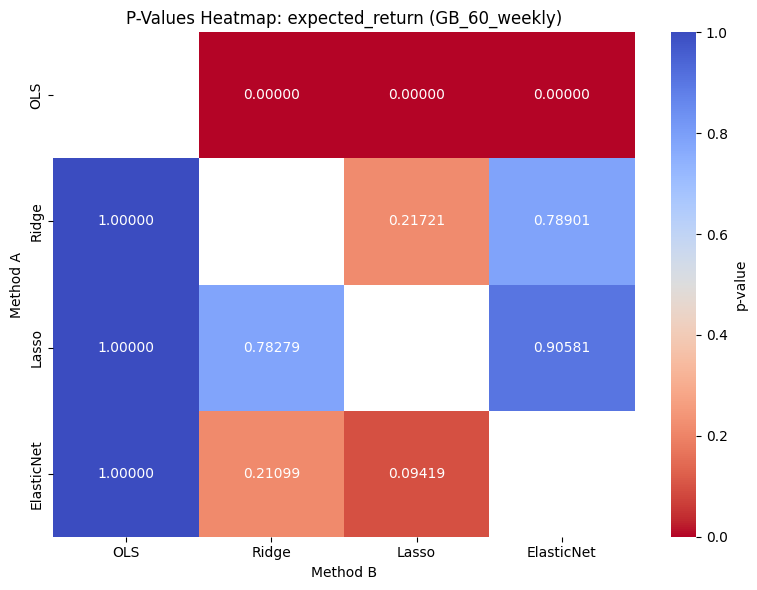

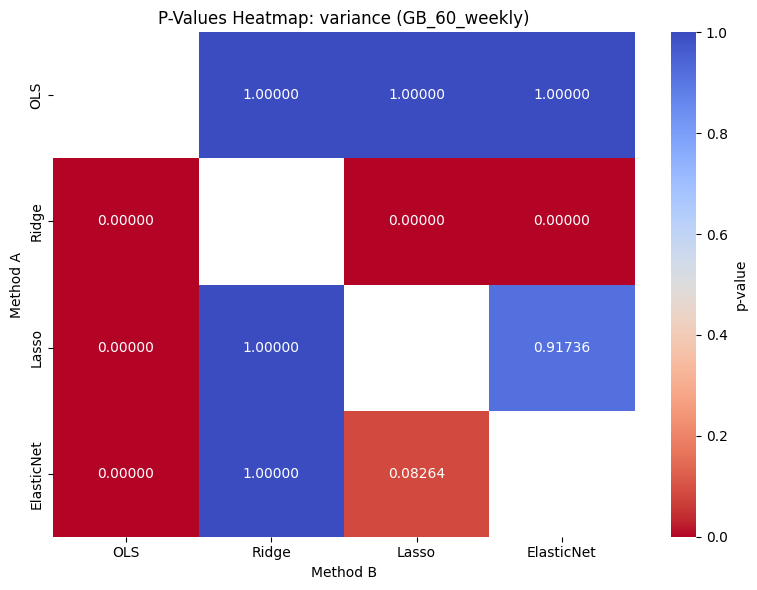

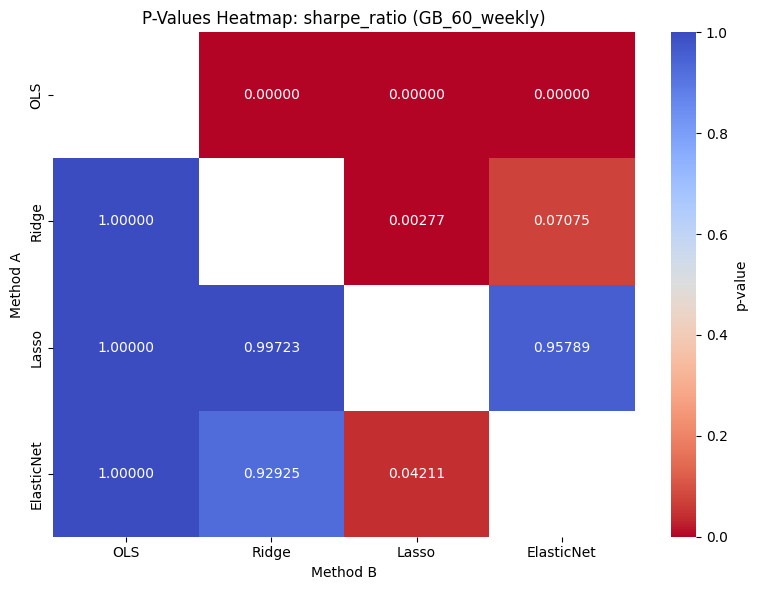

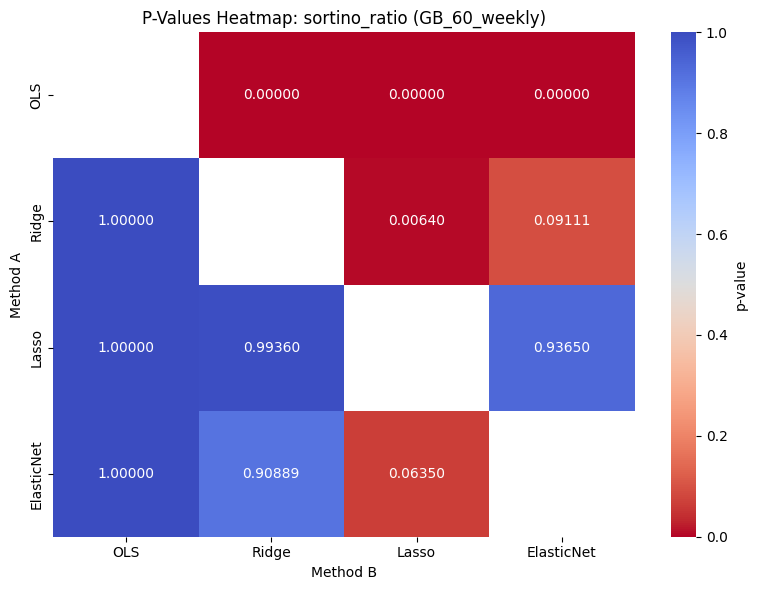

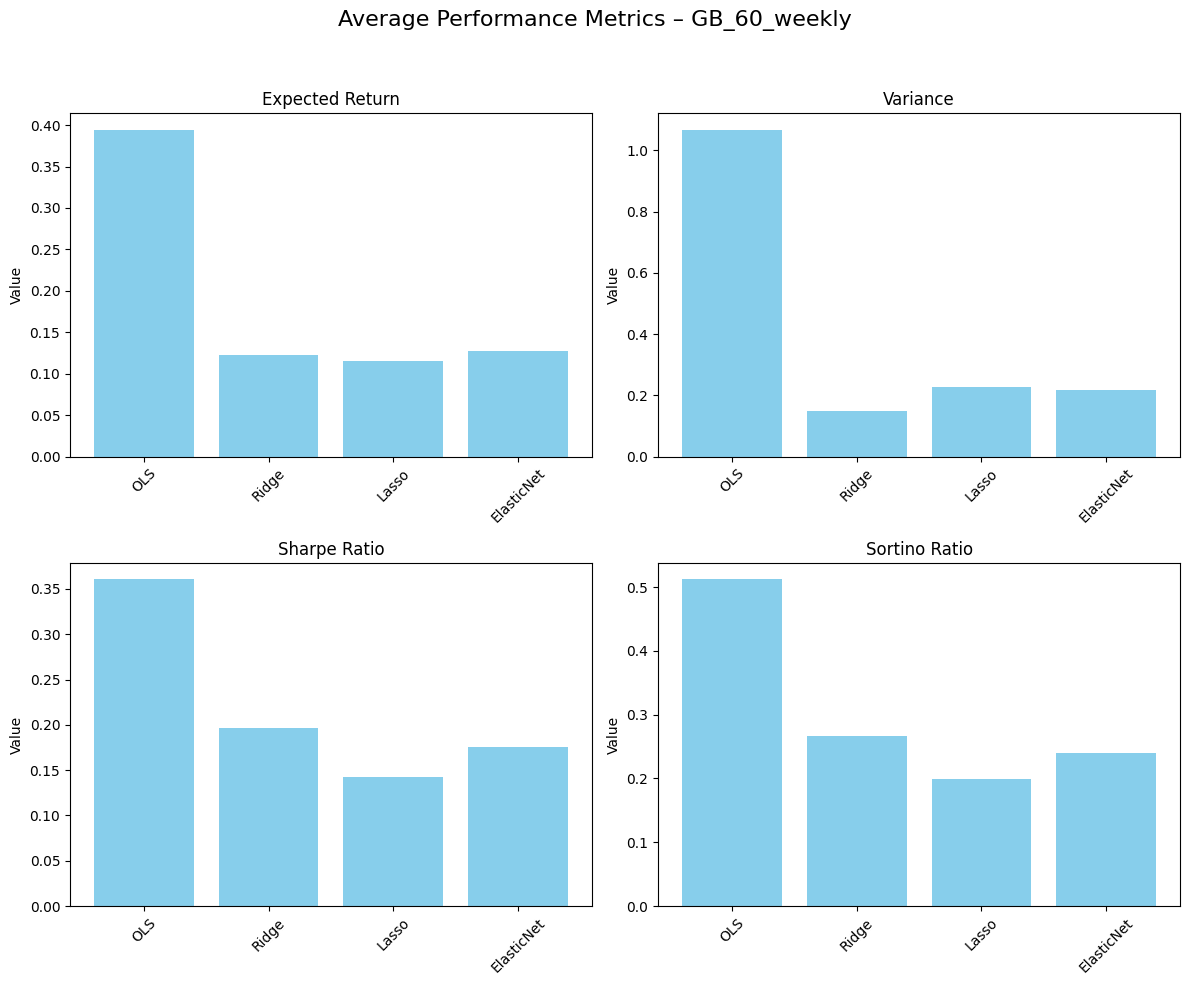



=== Running market: US, Subset size: 40, Frequency: weekly ===
Running OLS for US-40 with 32 subsets...


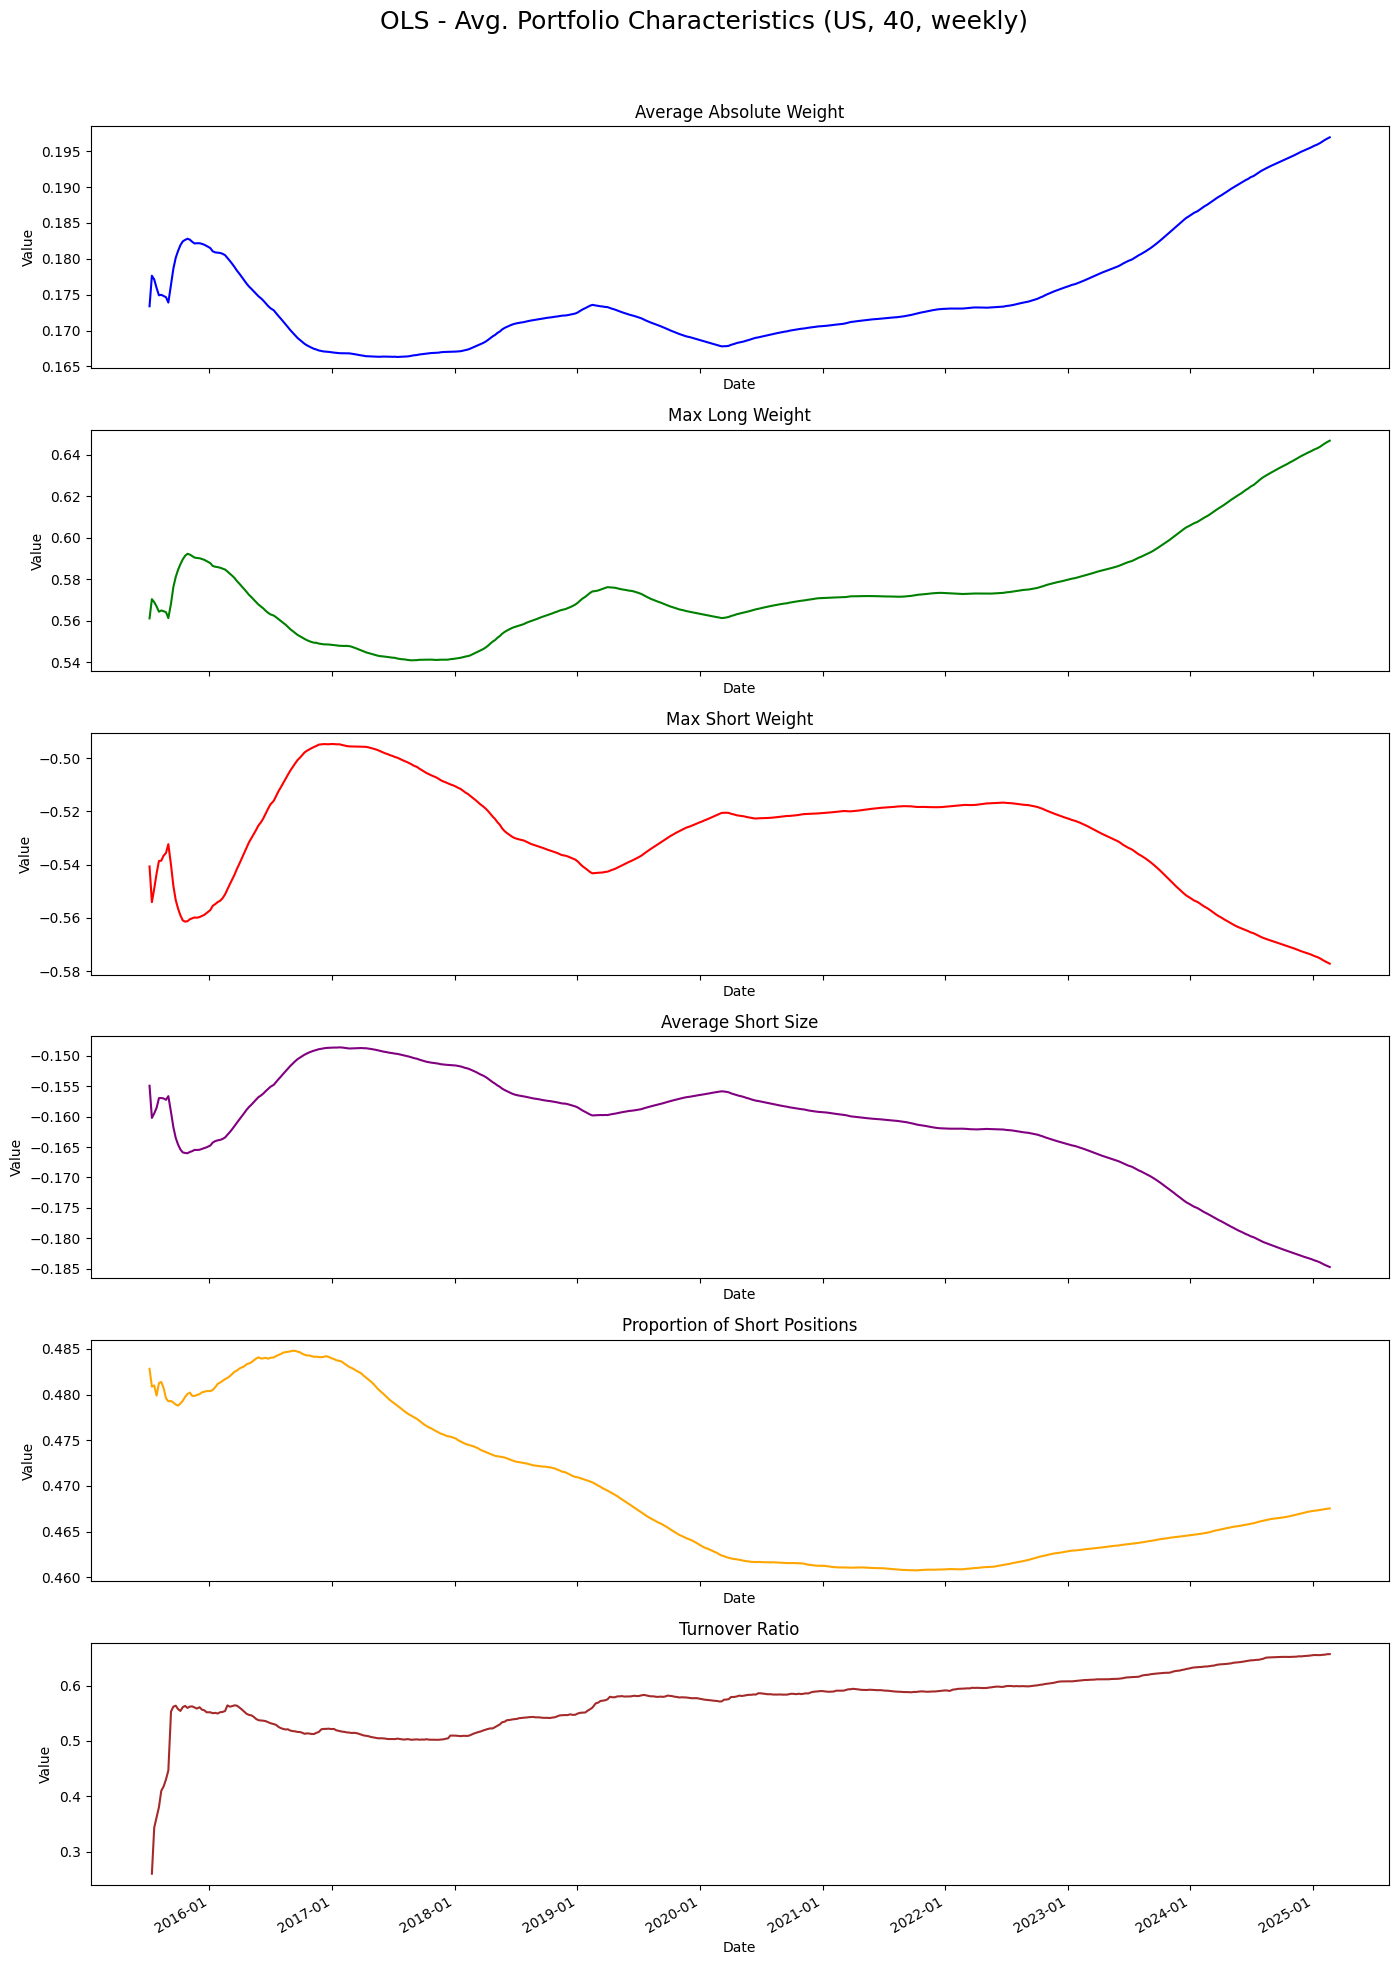

Running Ridge for US-40 with 32 subsets...


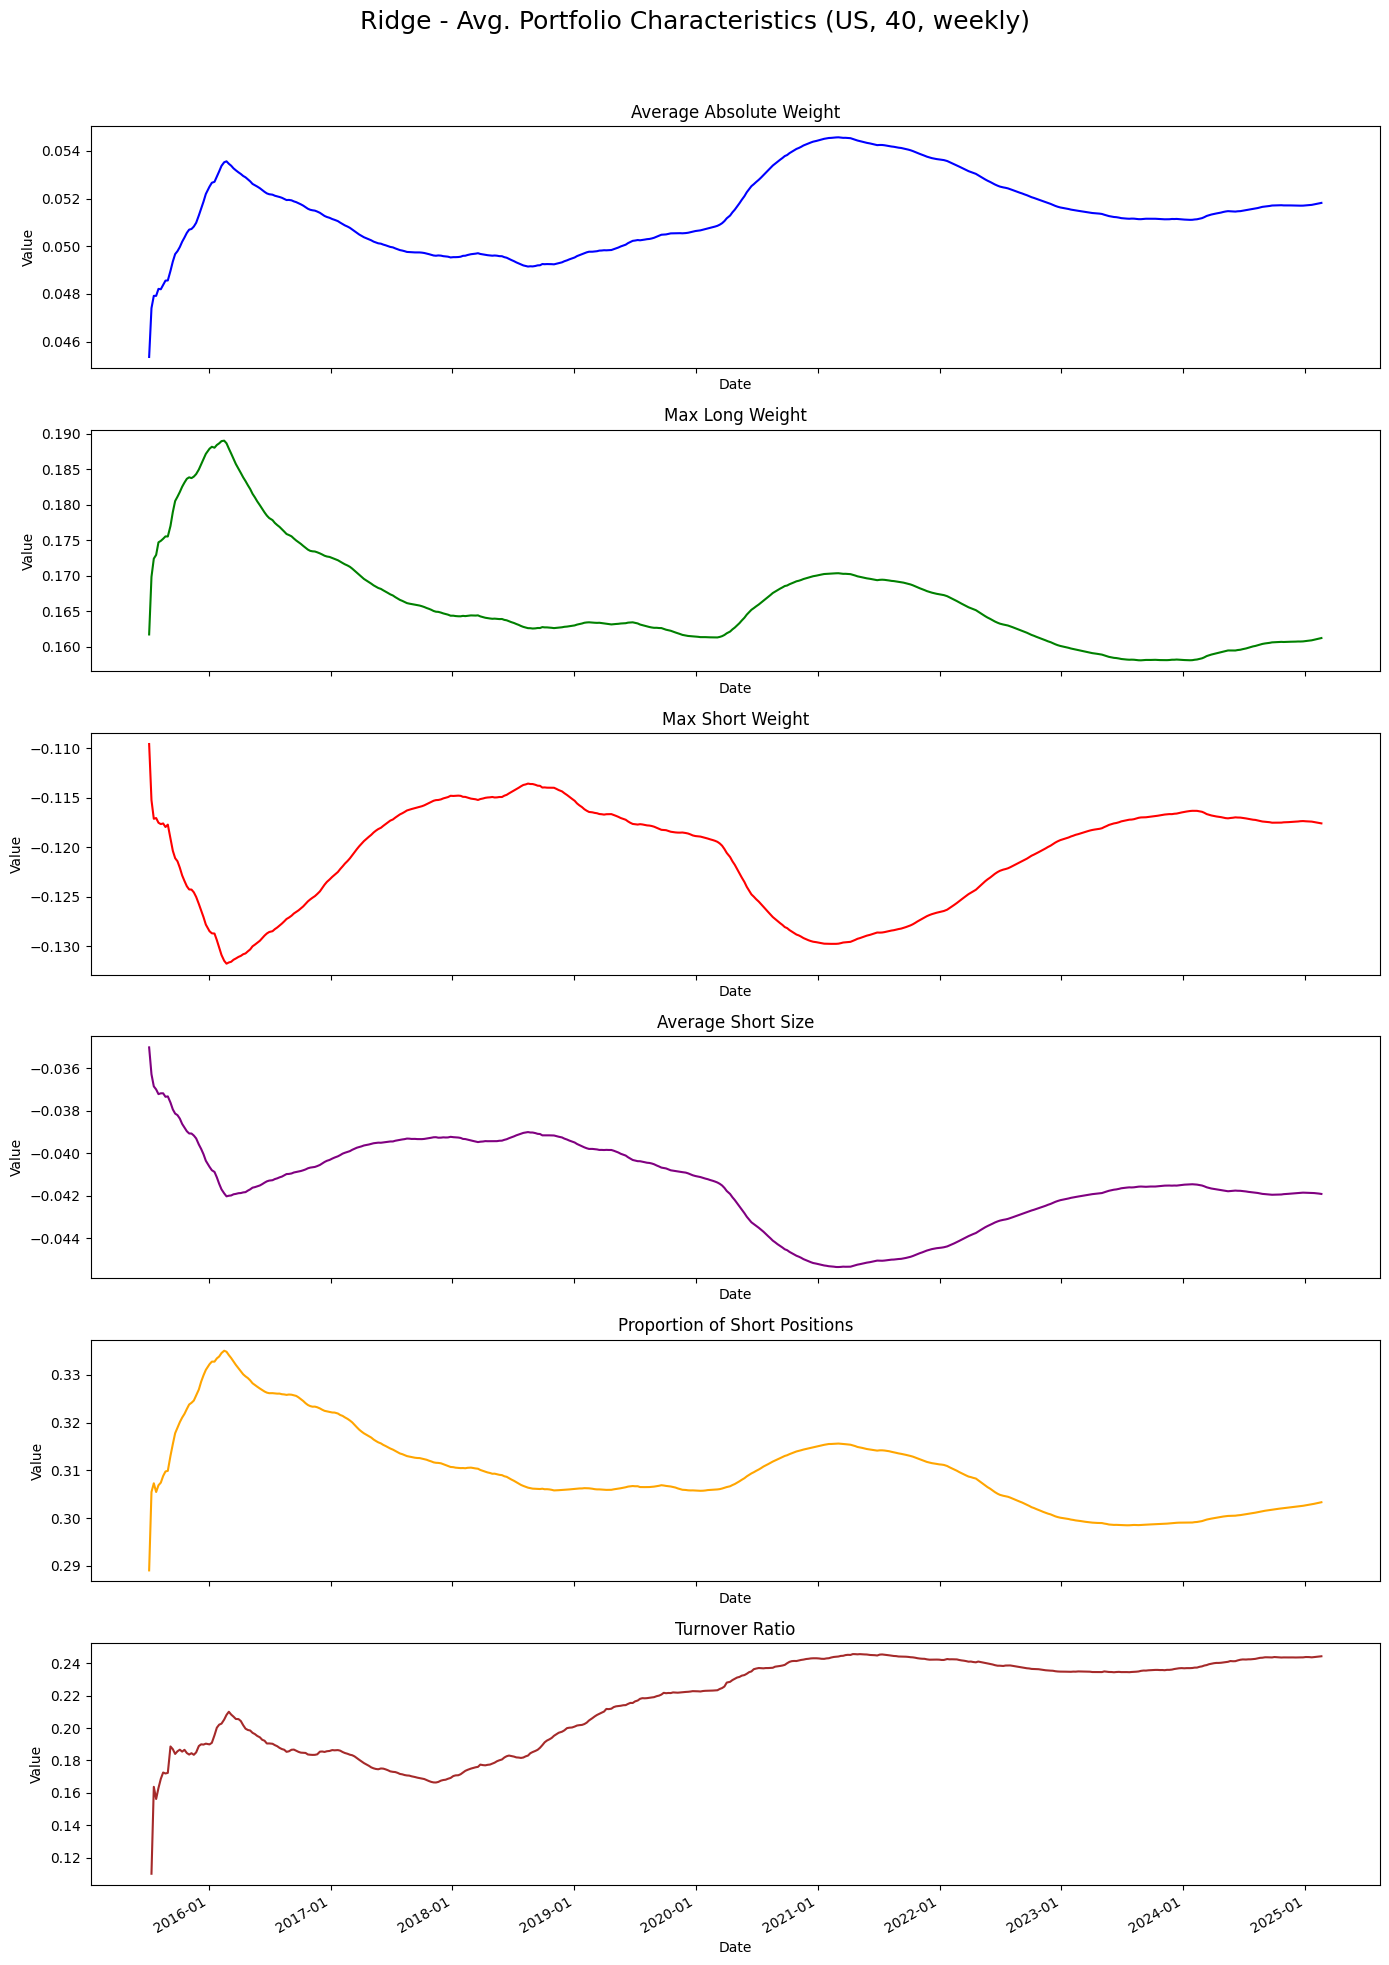

Running Lasso for US-40 with 32 subsets...


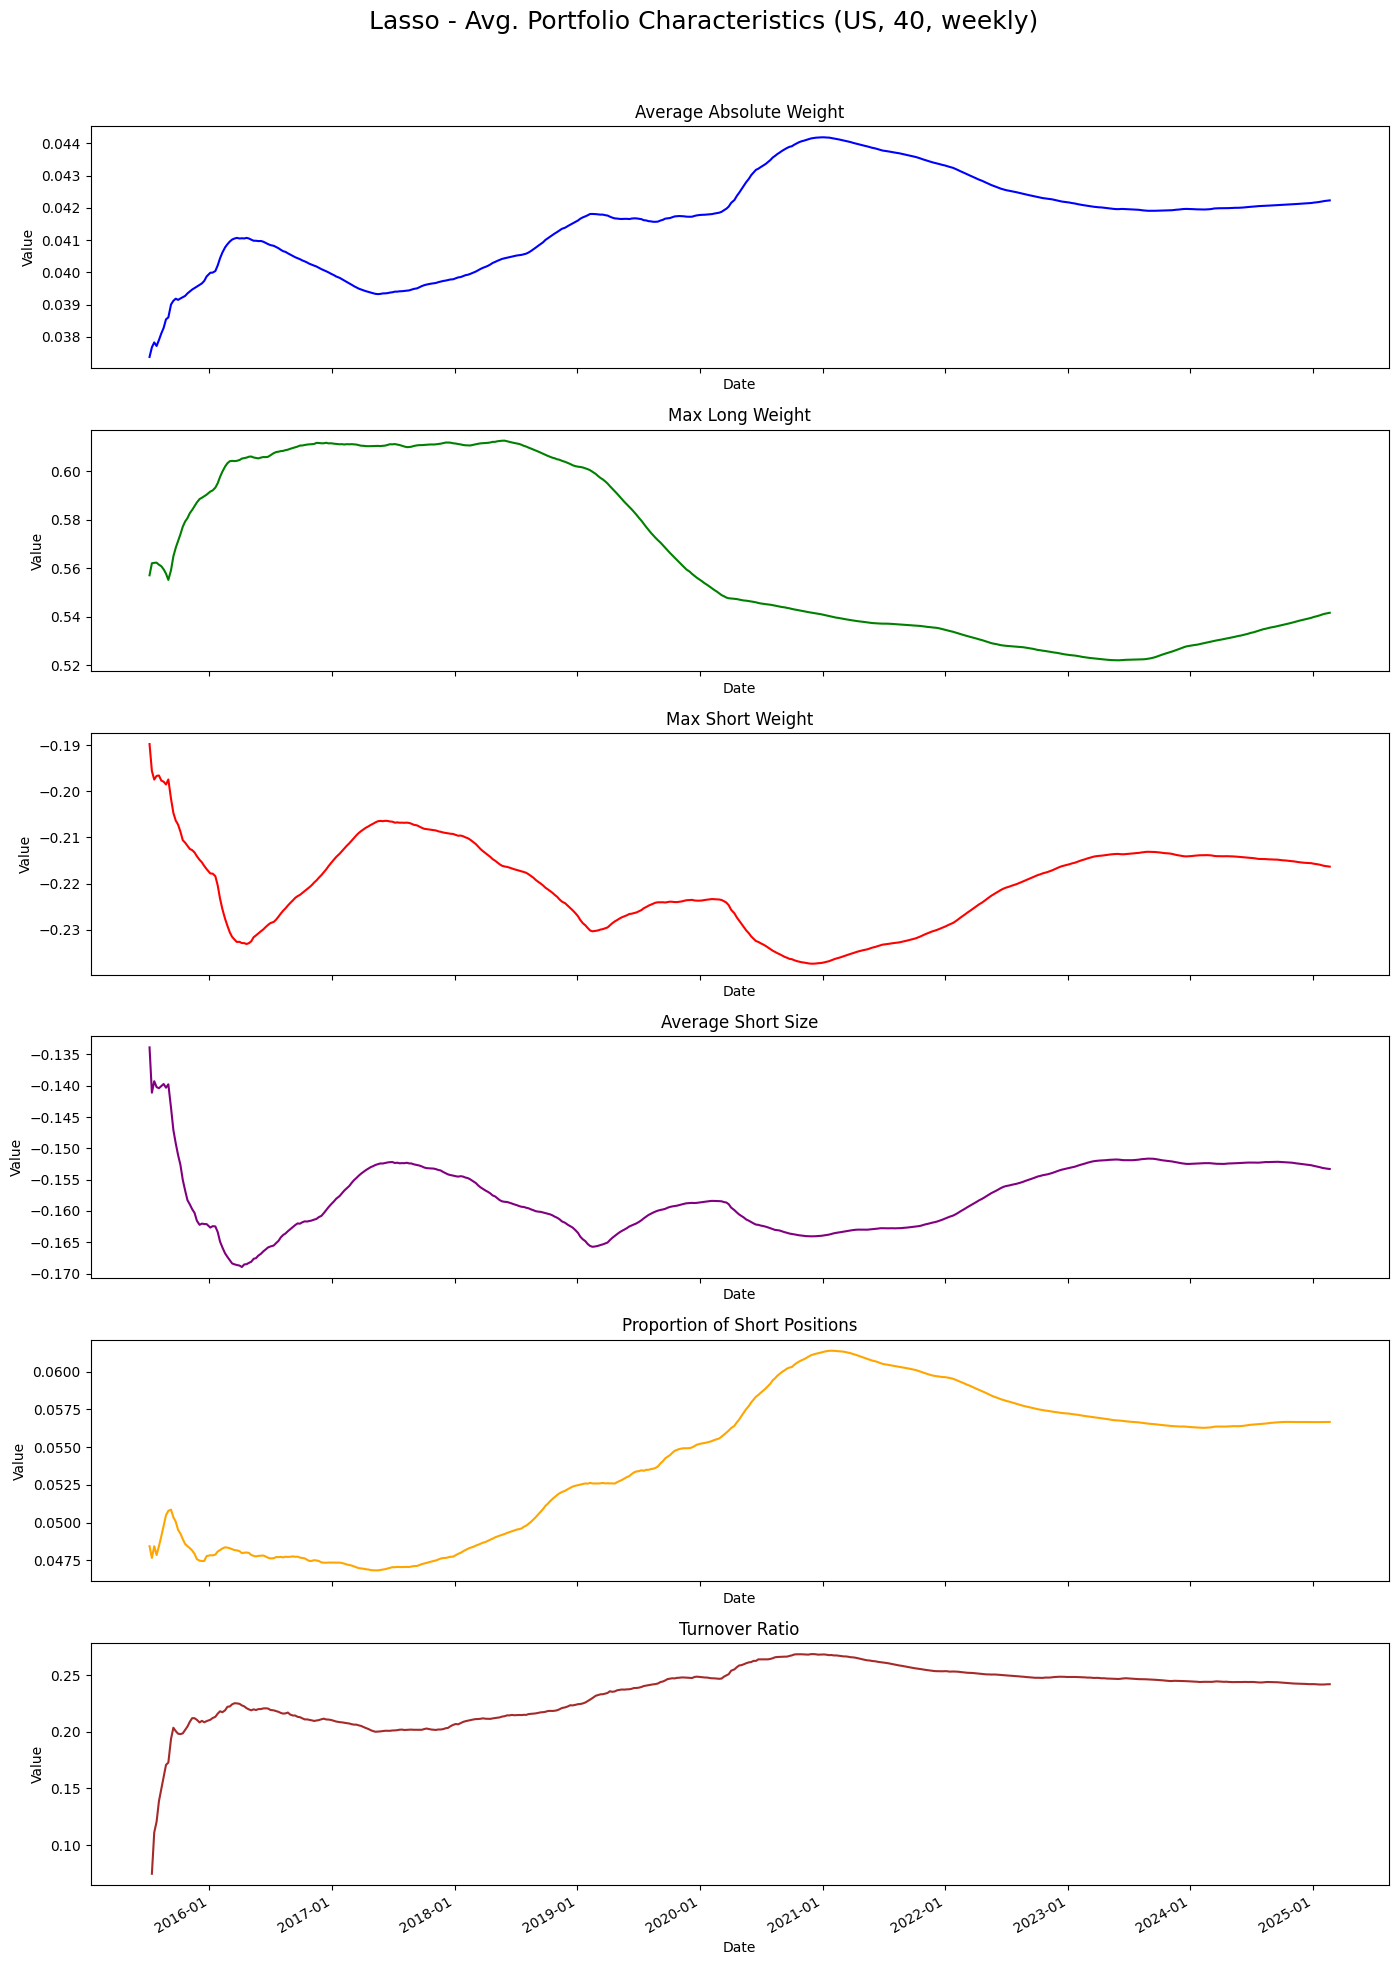

Running ElasticNet for US-40 with 32 subsets...


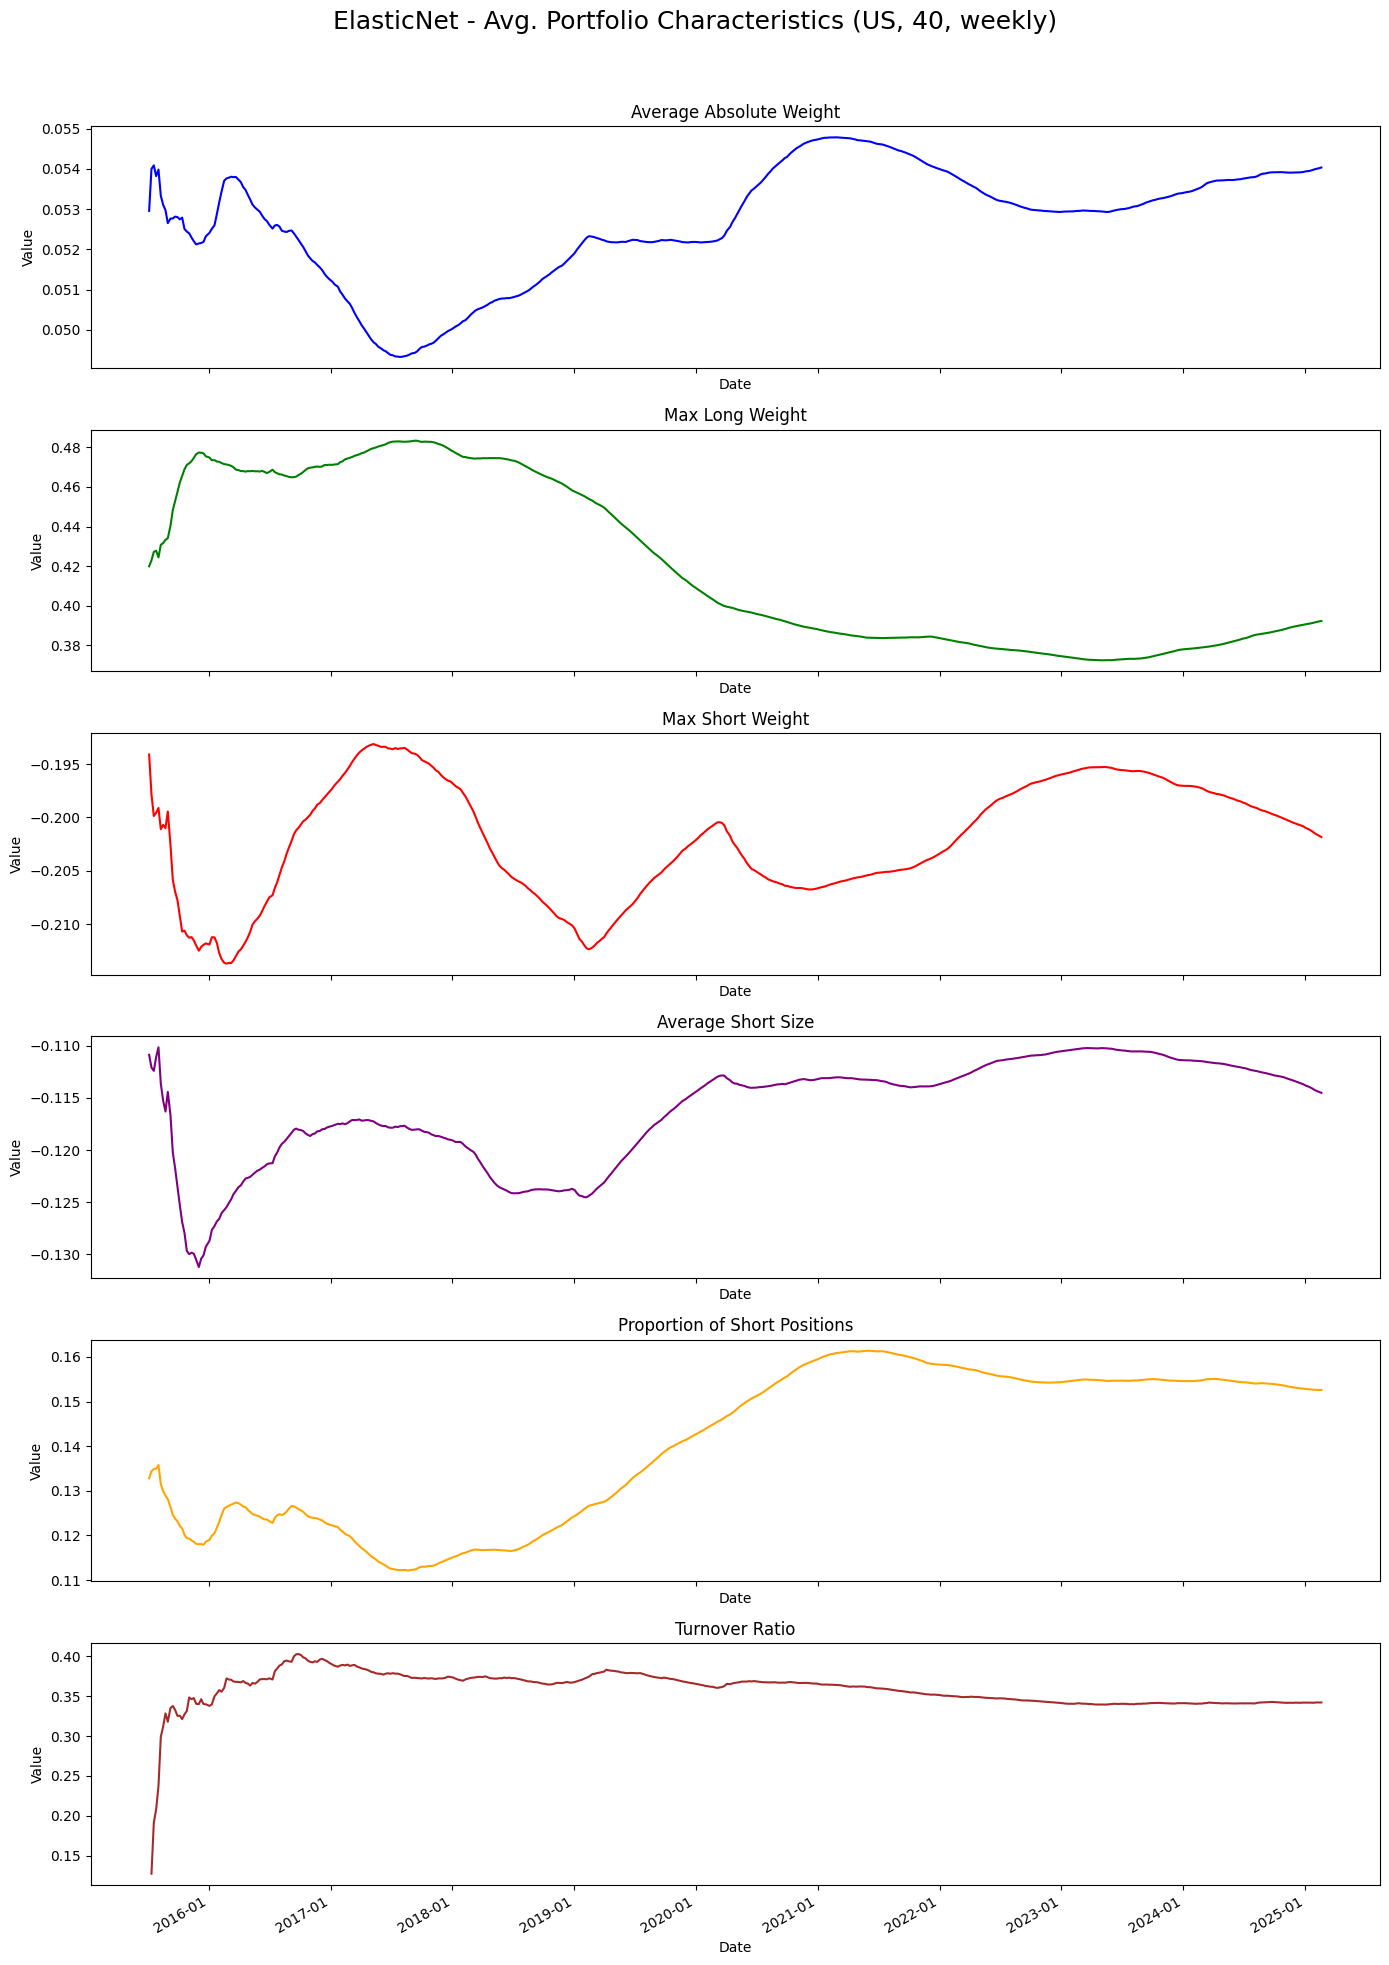


Results for OLS (US-40, weekly):
Expected Return (Annualized): [np.float64(0.25320692427522057), np.float64(0.3020766870791165), np.float64(0.18773316311423296), np.float64(0.13788642266782541), np.float64(0.175840207293405), np.float64(0.0680193944612097), np.float64(0.021323604882848086), np.float64(0.16842933211682867), np.float64(0.23177069048765148), np.float64(0.2401118624091655), np.float64(0.21925082079059197), np.float64(0.2983955043828179), np.float64(0.04146472366019459), np.float64(0.19663970100501688), np.float64(0.2345325017685112), np.float64(0.3071527214042363), np.float64(0.28703044404209027), np.float64(0.06800423688535448), np.float64(0.22834005433949897), np.float64(0.17425918274190802), np.float64(0.3113993476358353), np.float64(0.3225705407291271), np.float64(0.171432861585162), np.float64(0.28524004992959756), np.float64(0.21746426669071686), np.float64(0.20223860868166907), np.float64(0.26543556085397185), np.float64(0.10813375251192824), np.float64(0.469810090

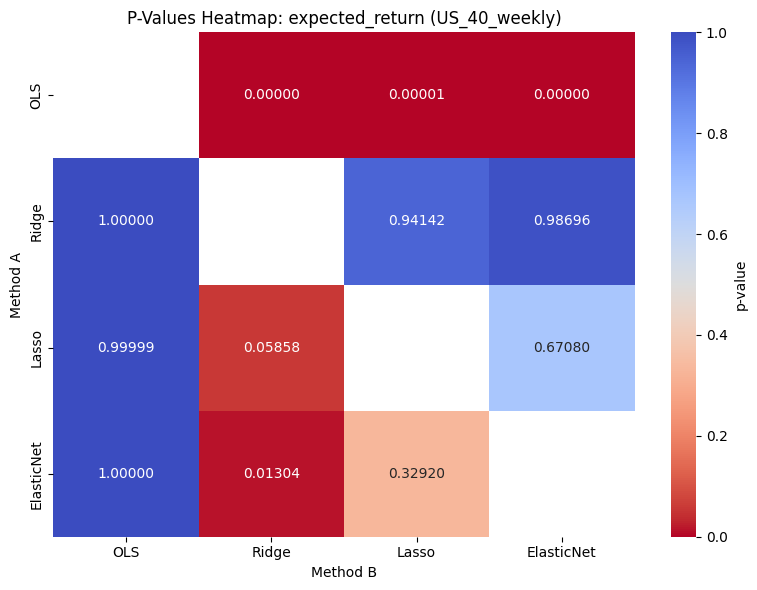

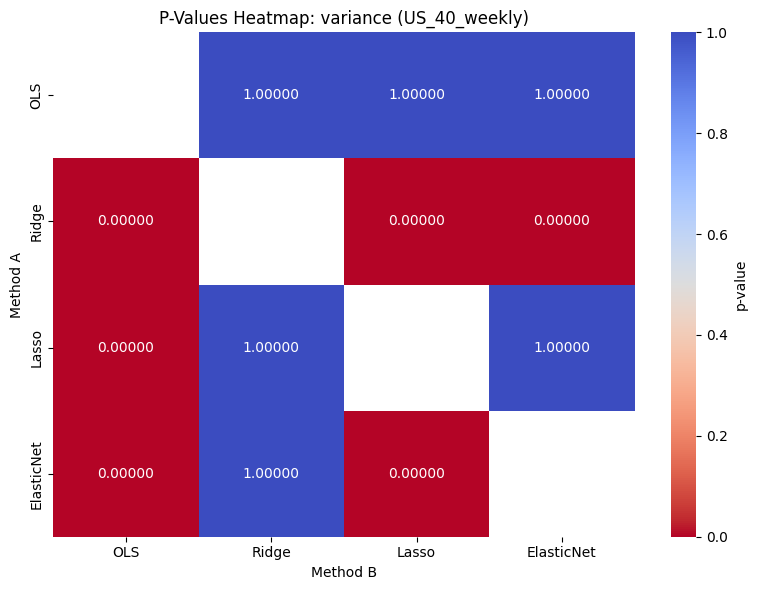

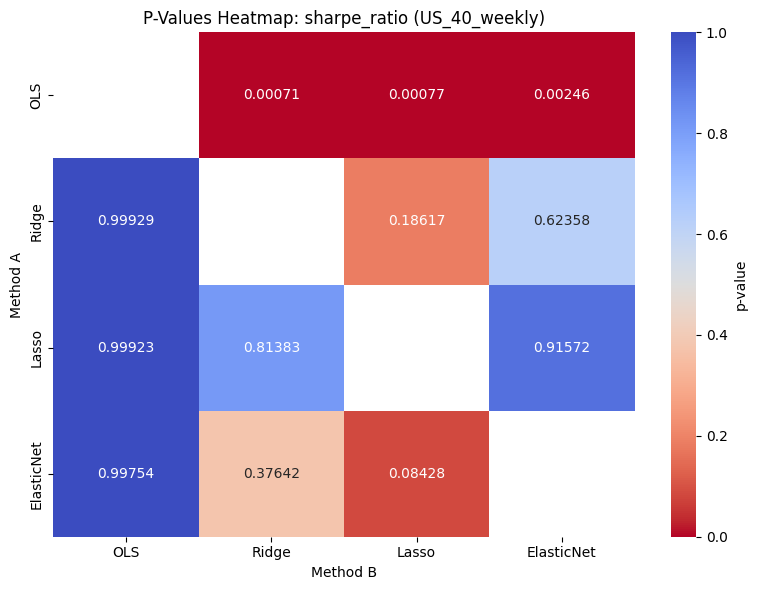

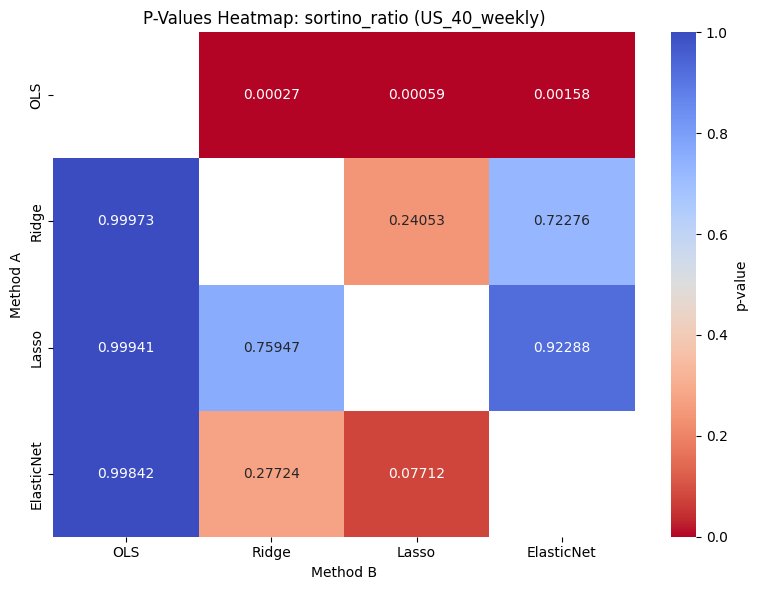

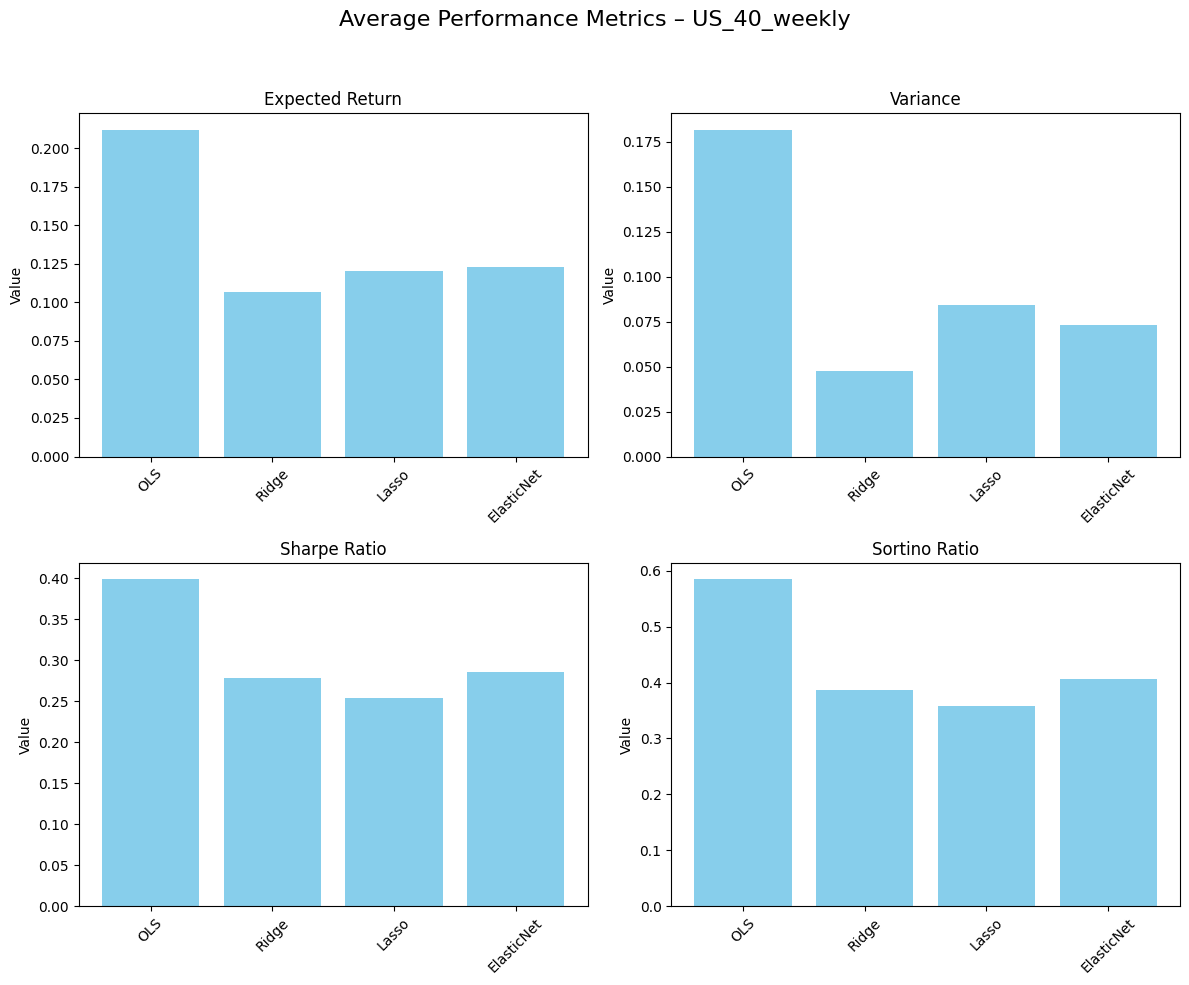



=== Running market: US, Subset size: 60, Frequency: weekly ===
Running OLS for US-60 with 32 subsets...


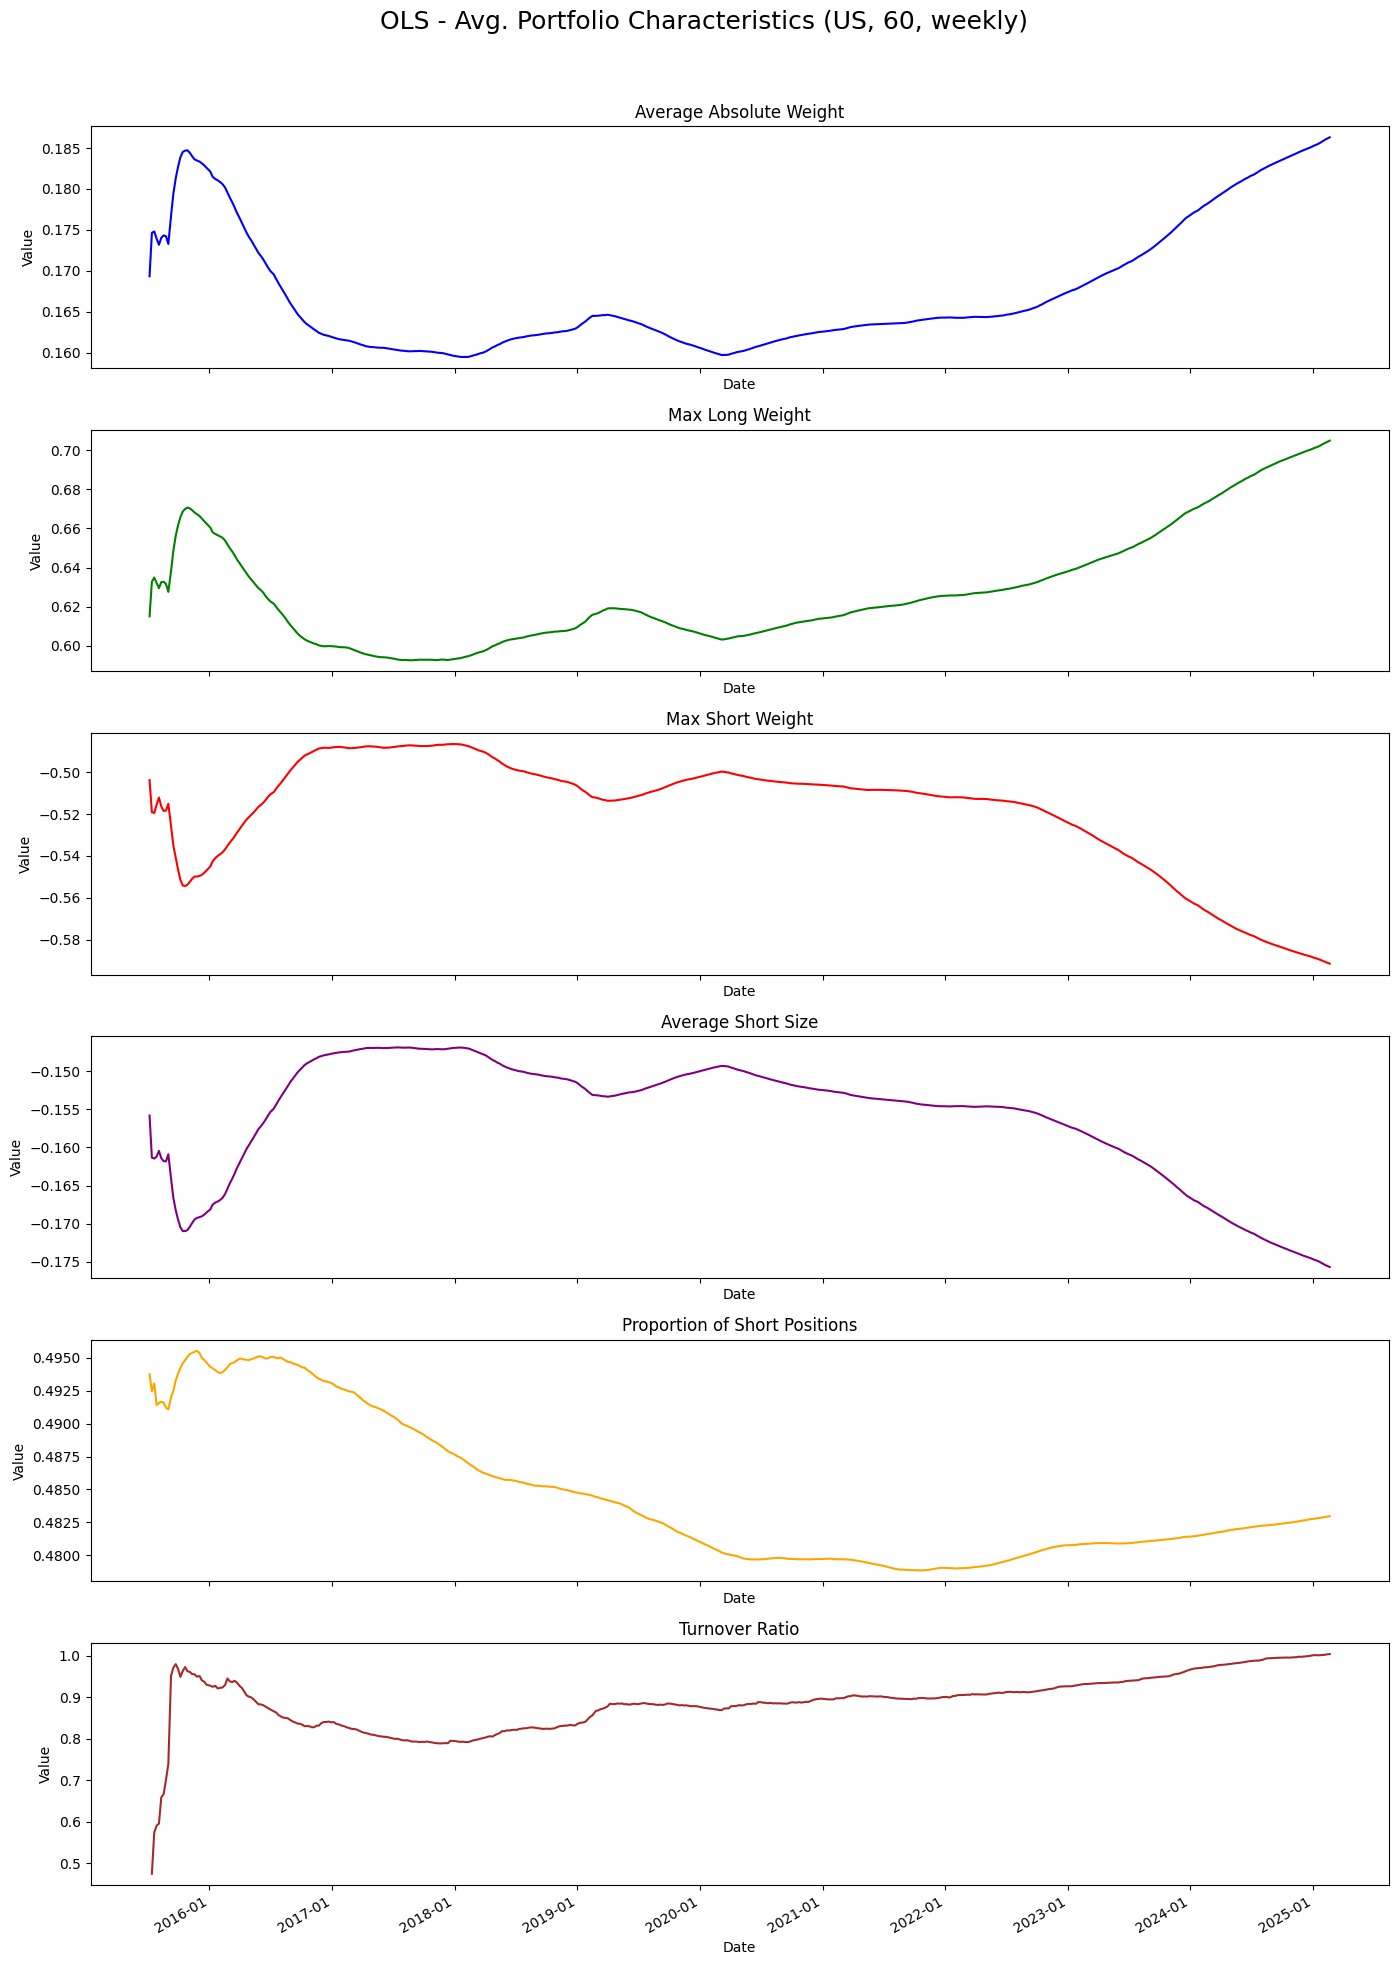

Running Ridge for US-60 with 32 subsets...


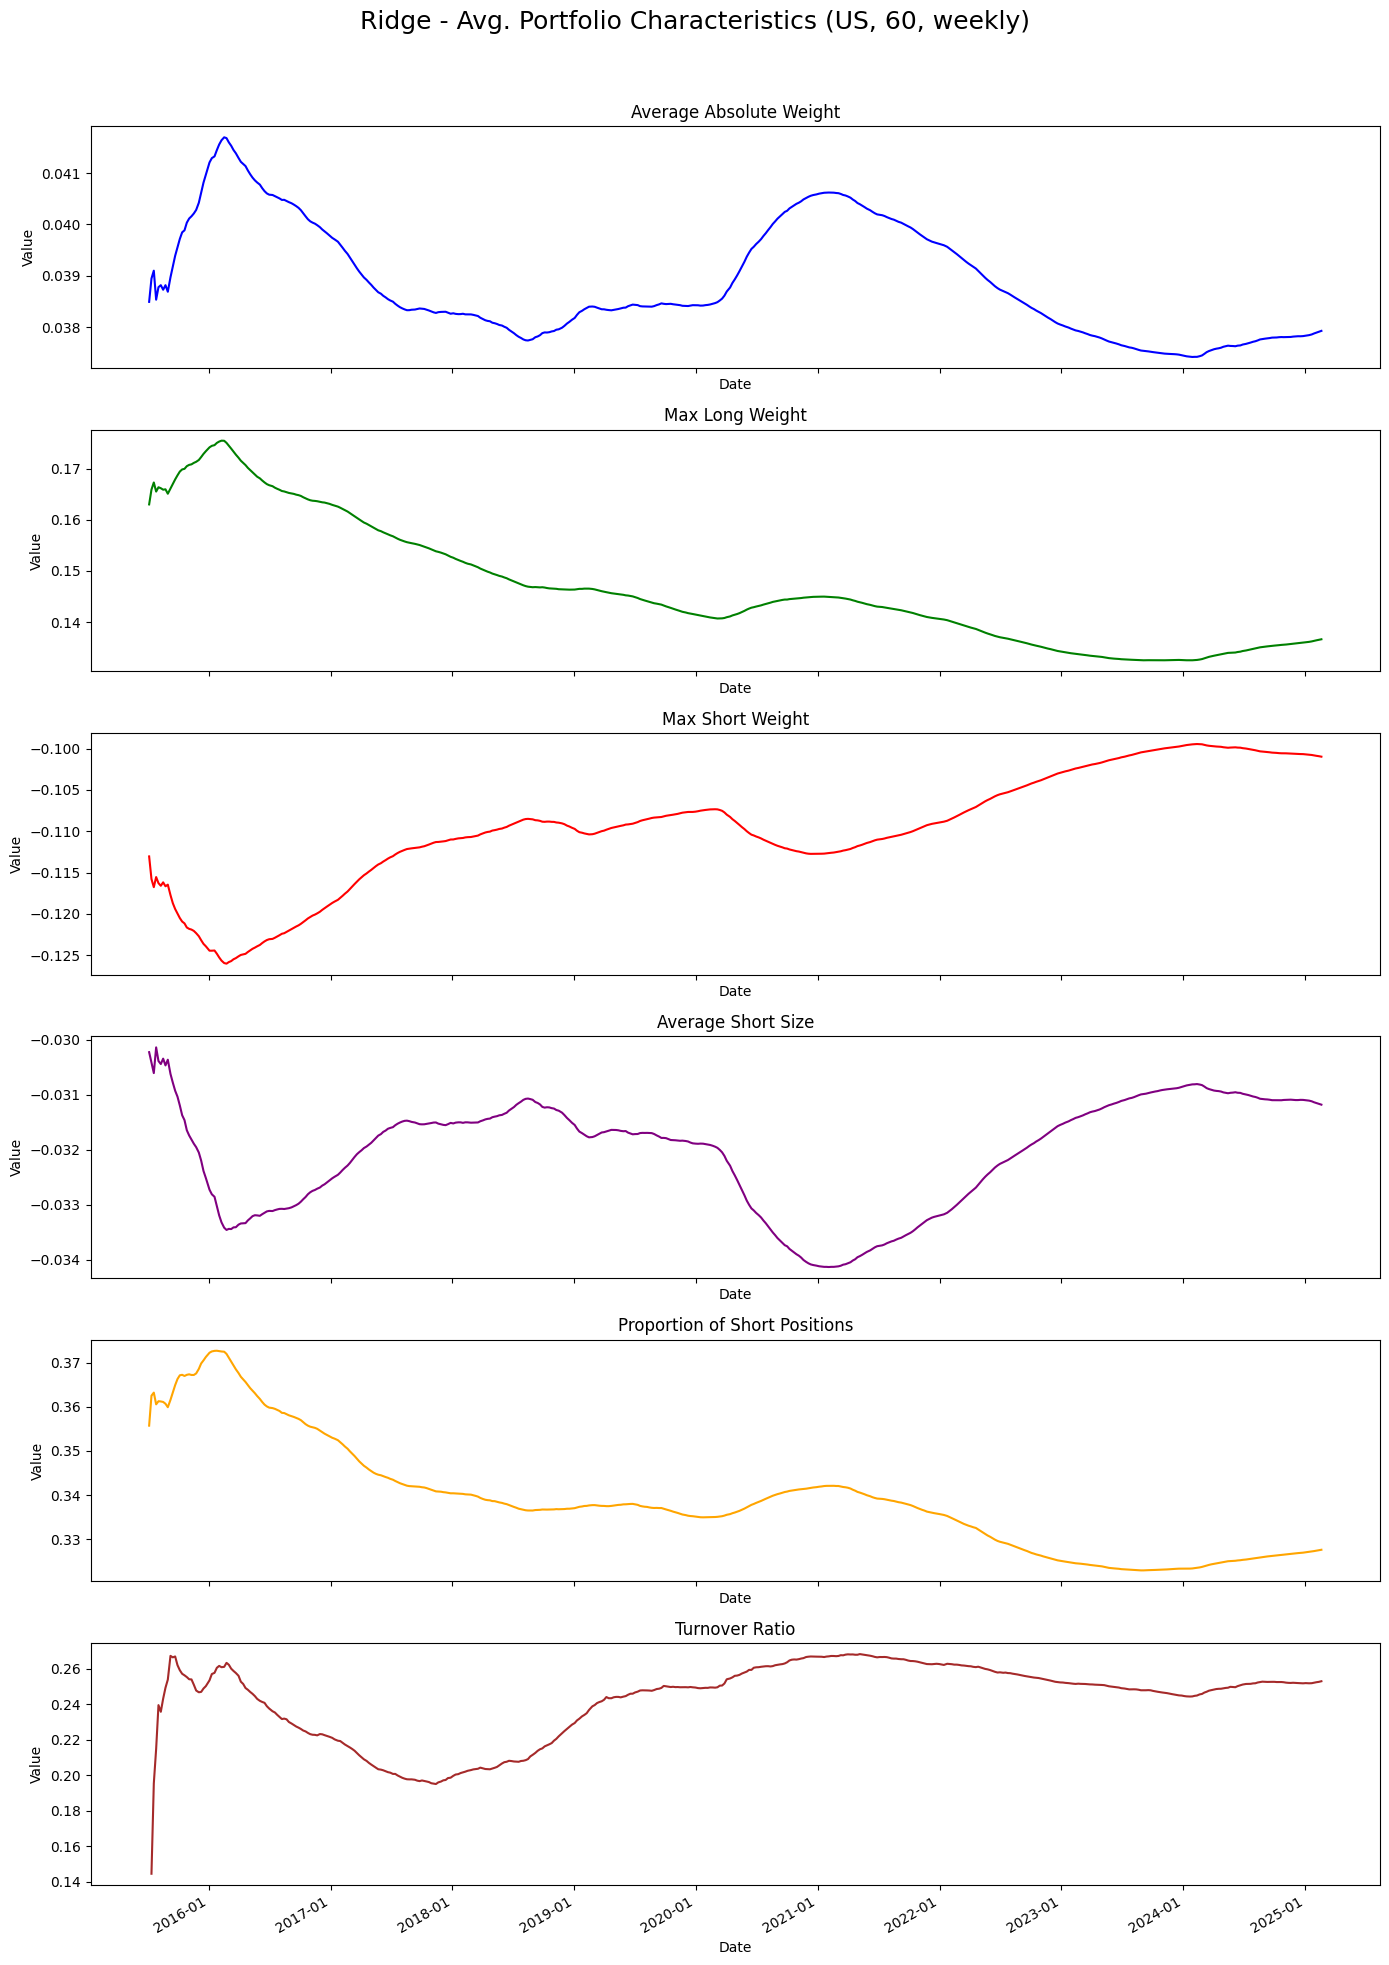

Running Lasso for US-60 with 32 subsets...


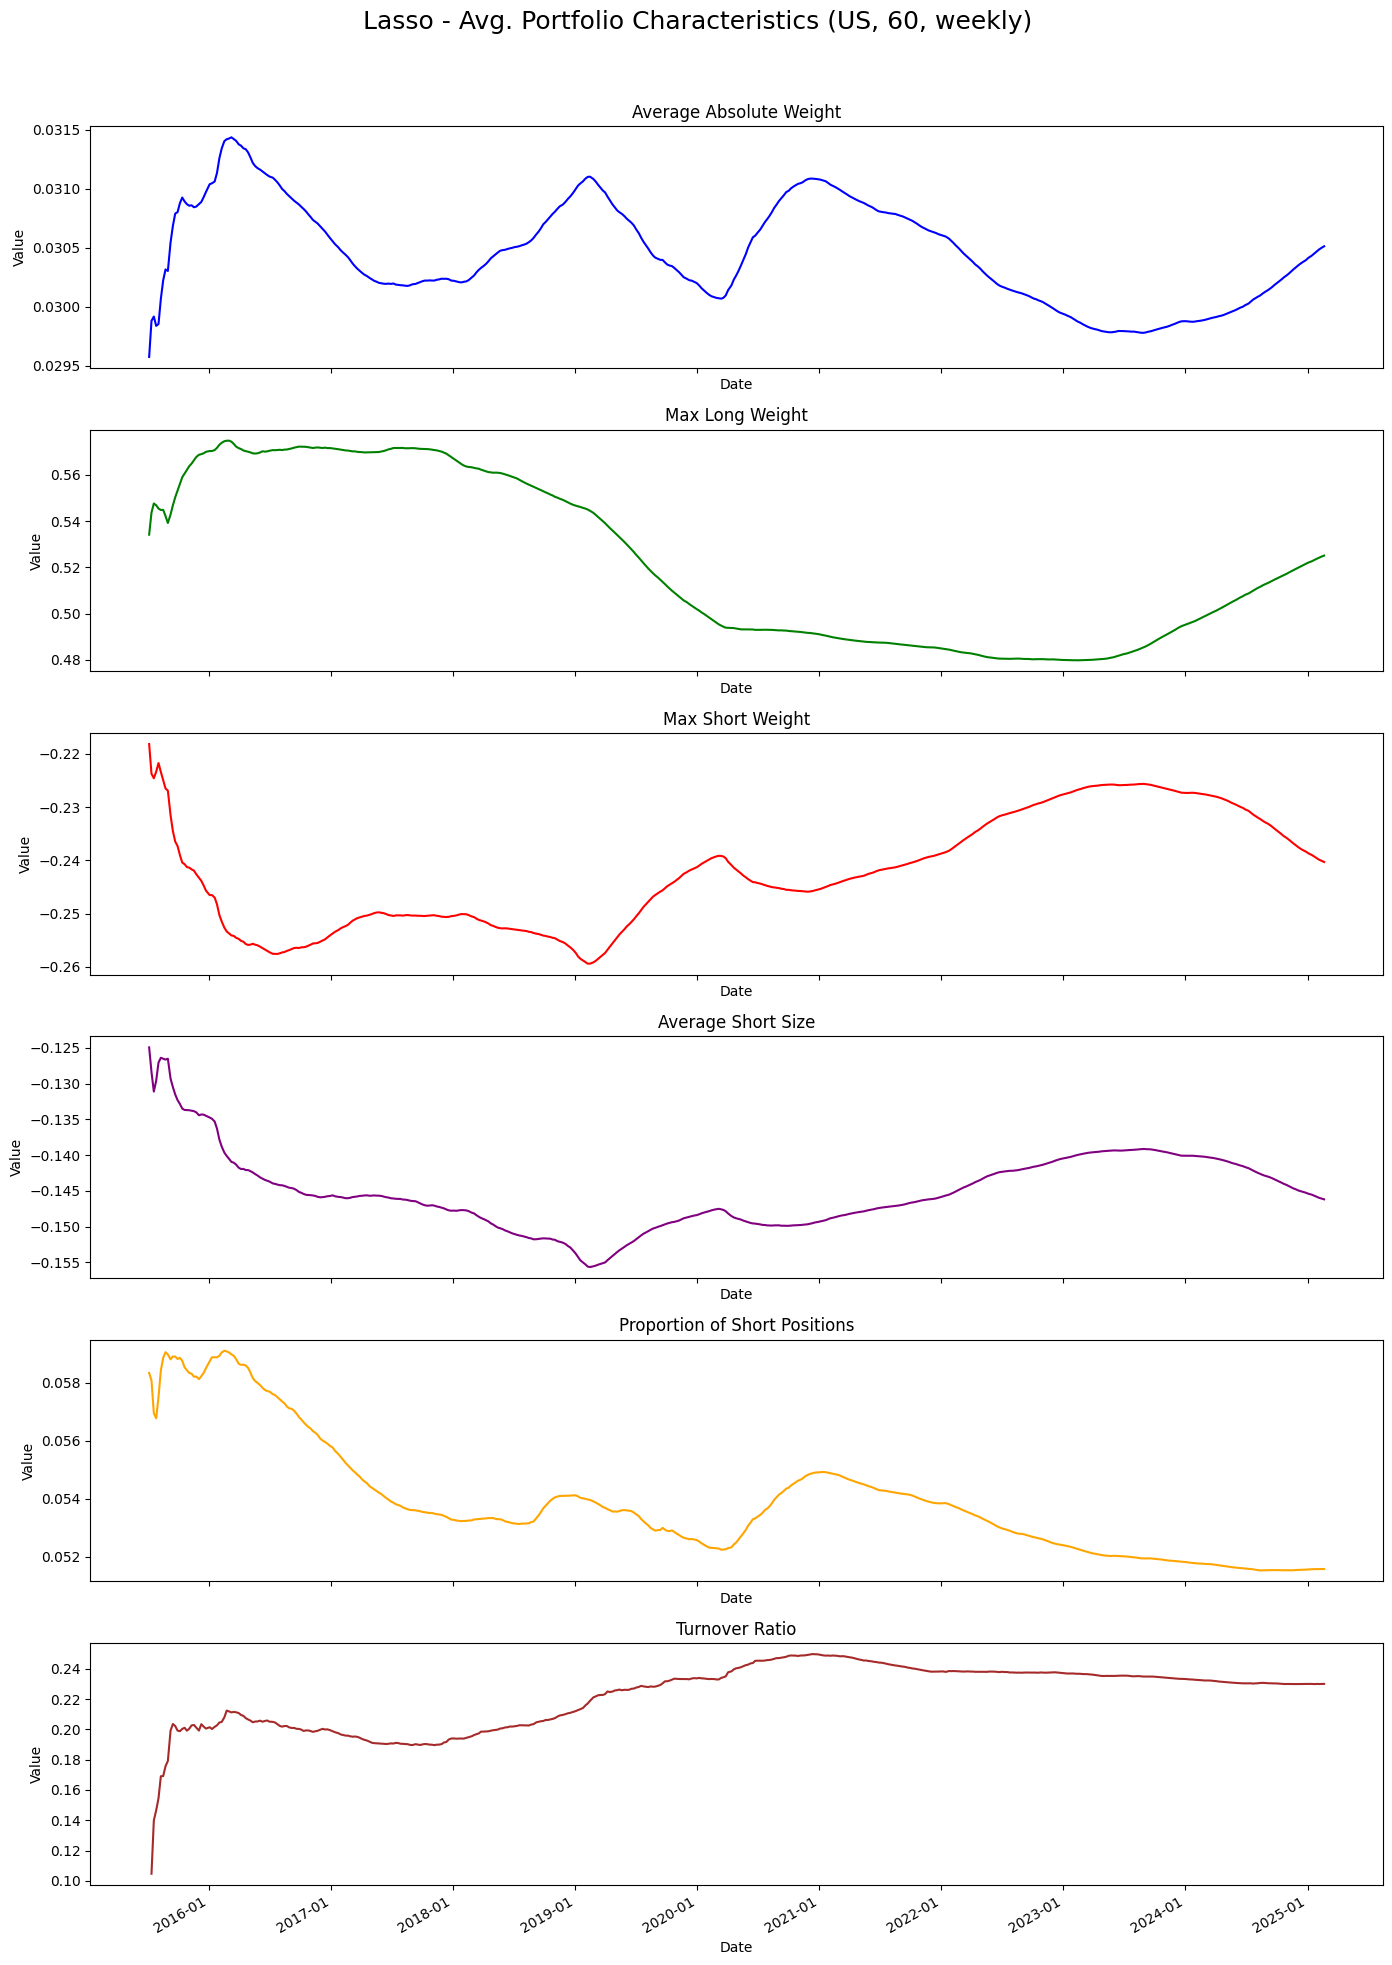

Running ElasticNet for US-60 with 32 subsets...


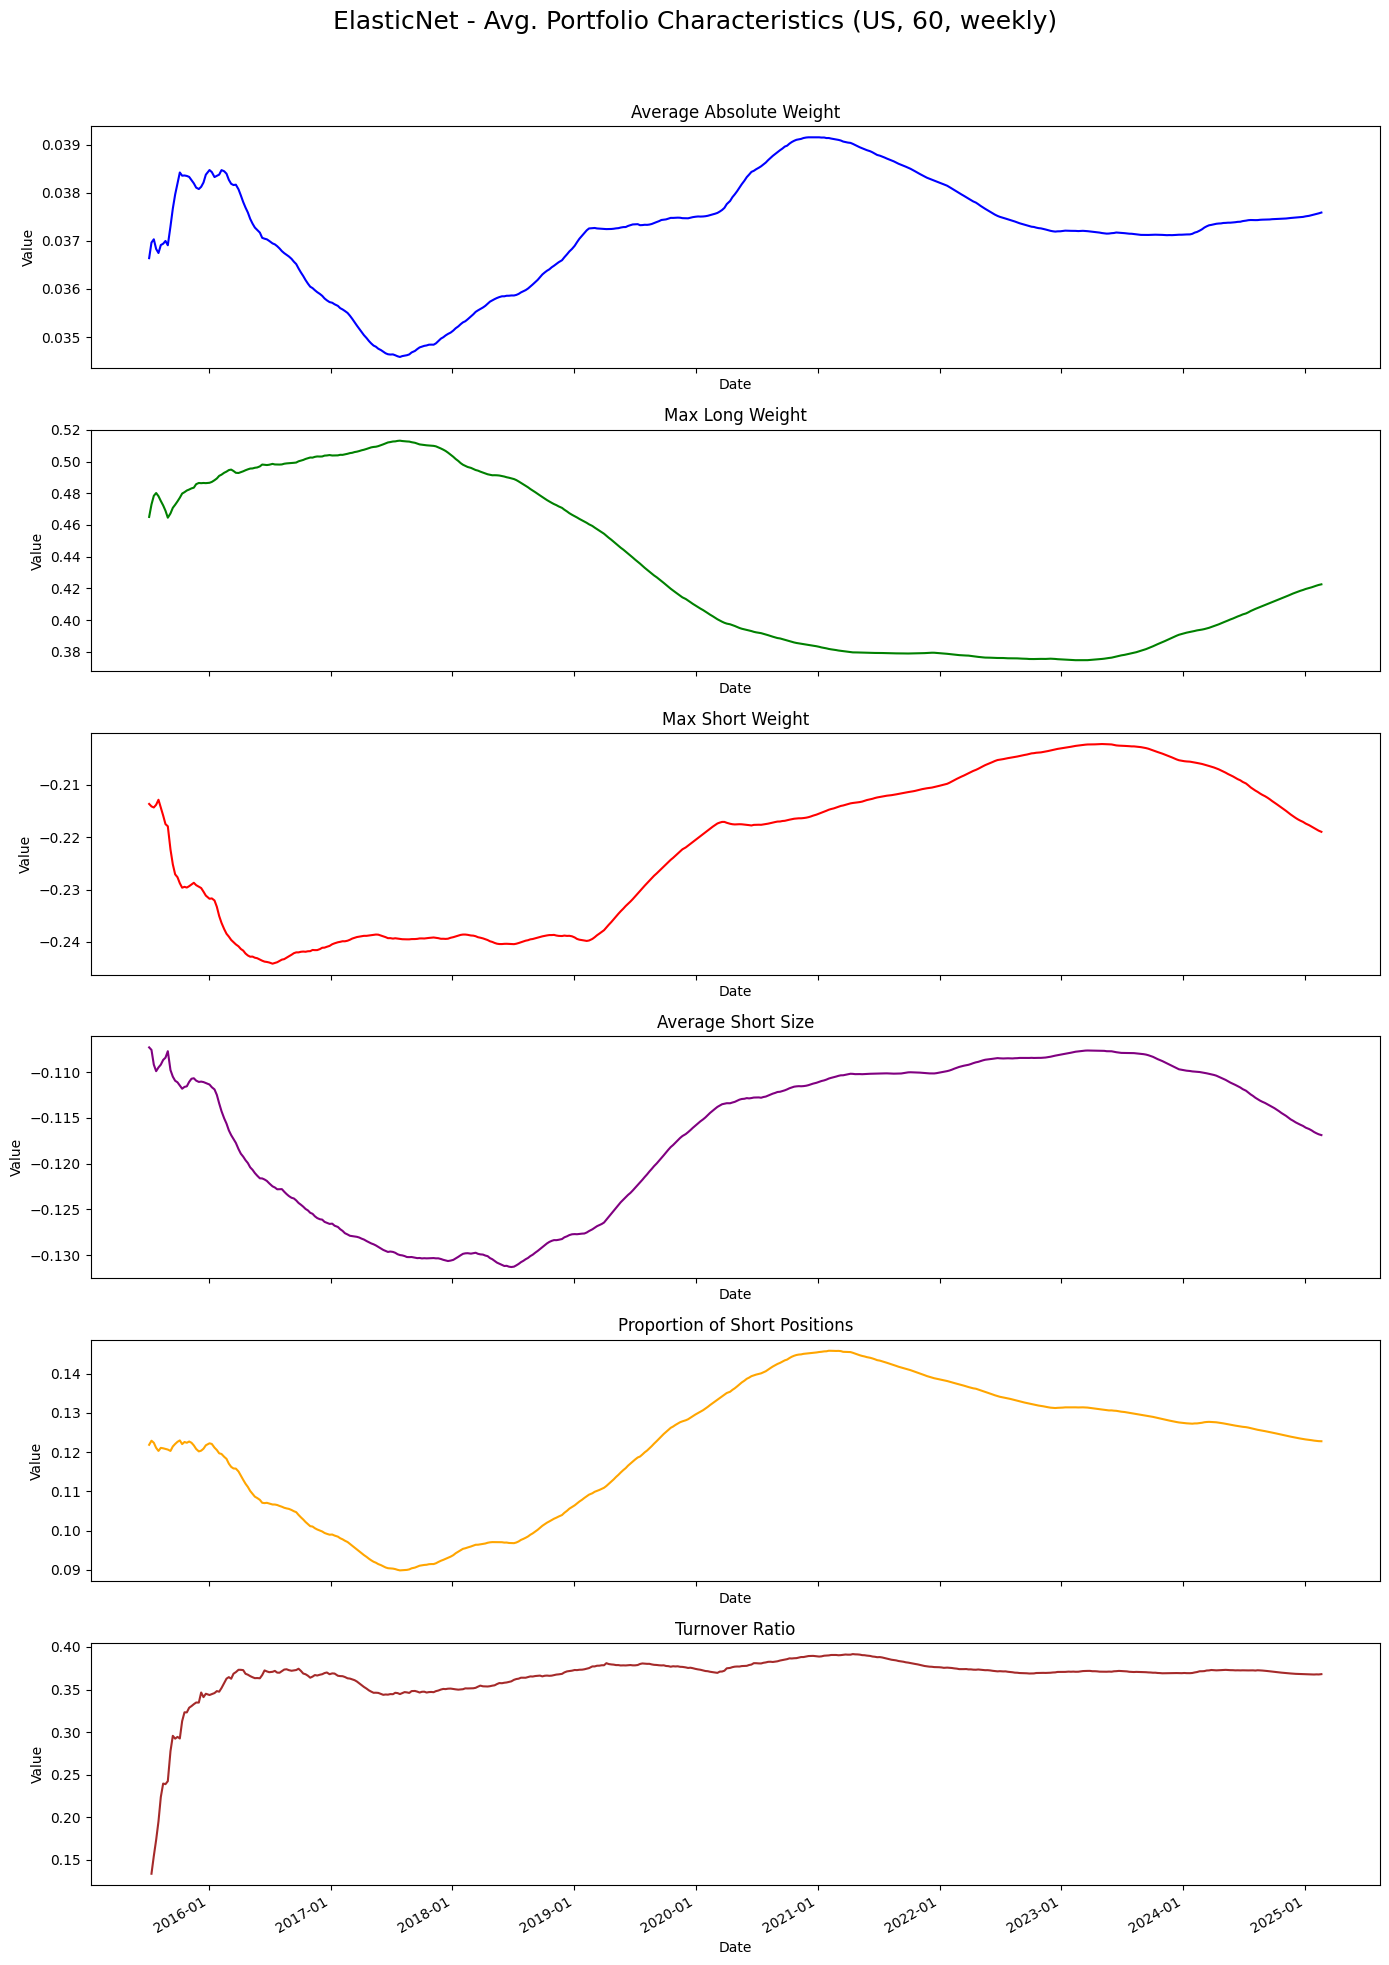


Results for OLS (US-60, weekly):
Expected Return (Annualized): [np.float64(0.06705383700864193), np.float64(0.2817471691837225), np.float64(0.1392775921229596), np.float64(0.3501597393460109), np.float64(0.35207441670244266), np.float64(0.34124555893431285), np.float64(0.10387083713374144), np.float64(0.38482865010741324), np.float64(0.14243370122980814), np.float64(0.259728662351143), np.float64(0.10494422957459094), np.float64(0.3243462735147987), np.float64(0.4798555378572243), np.float64(0.10874438030306062), np.float64(0.35395985249534034), np.float64(0.30899642534680644), np.float64(0.2924305002300793), np.float64(0.18892316533049808), np.float64(0.2683802617426179), np.float64(0.33881954140344406), np.float64(0.1485894610299934), np.float64(0.43950419589943684), np.float64(0.06186025677485078), np.float64(0.4535966054038884), np.float64(0.04154597640951123), np.float64(0.39365355388116635), np.float64(0.10161771284351183), np.float64(0.22967959533868226), np.float64(0.213520942

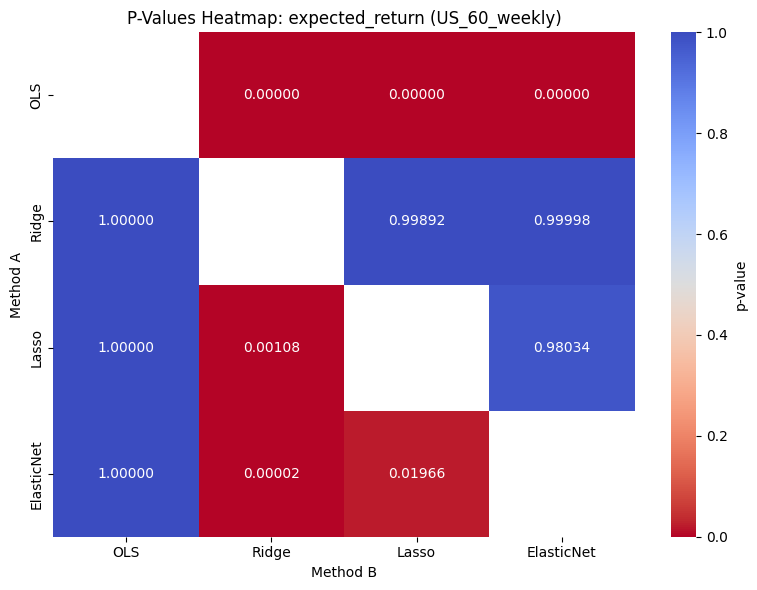

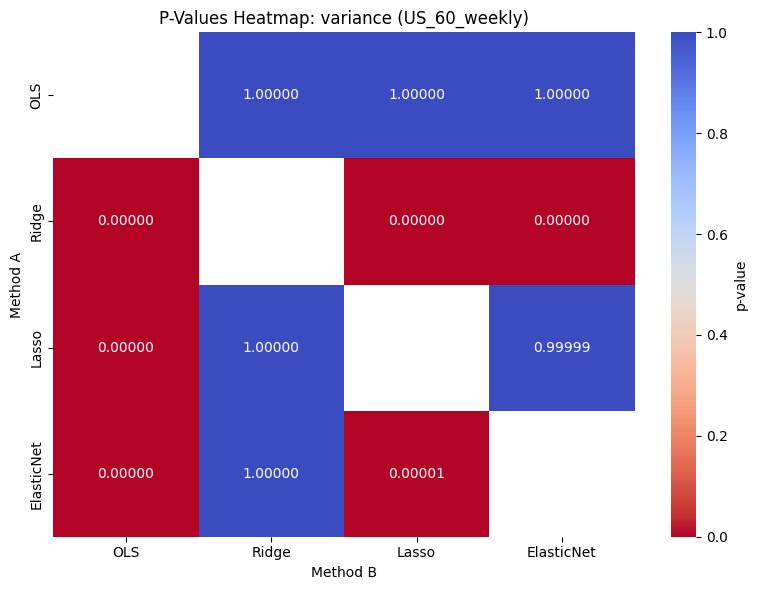

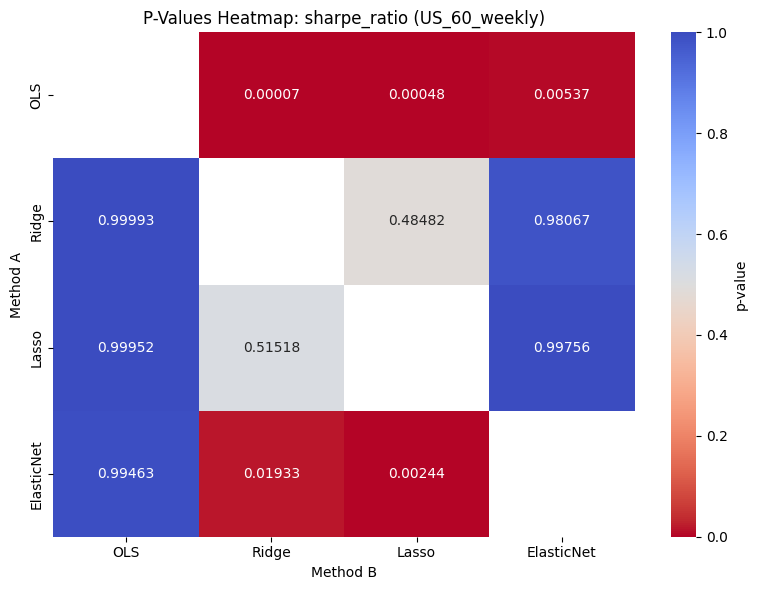

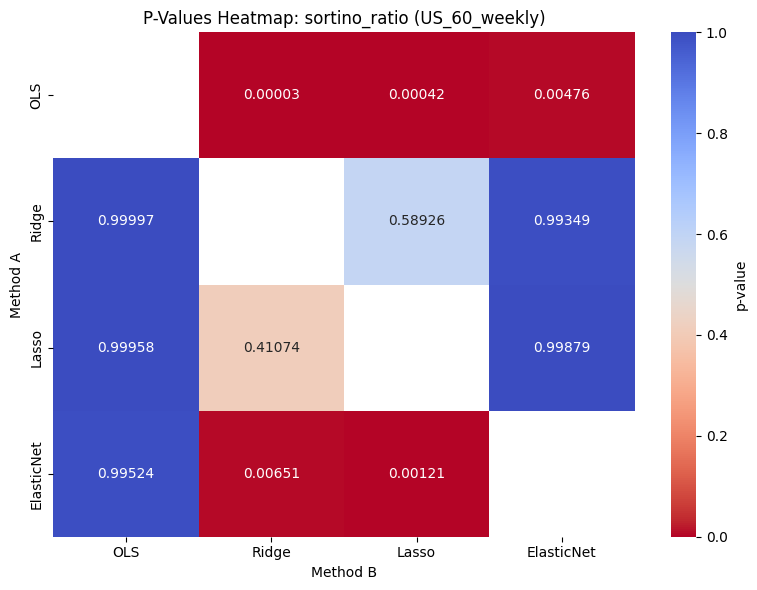

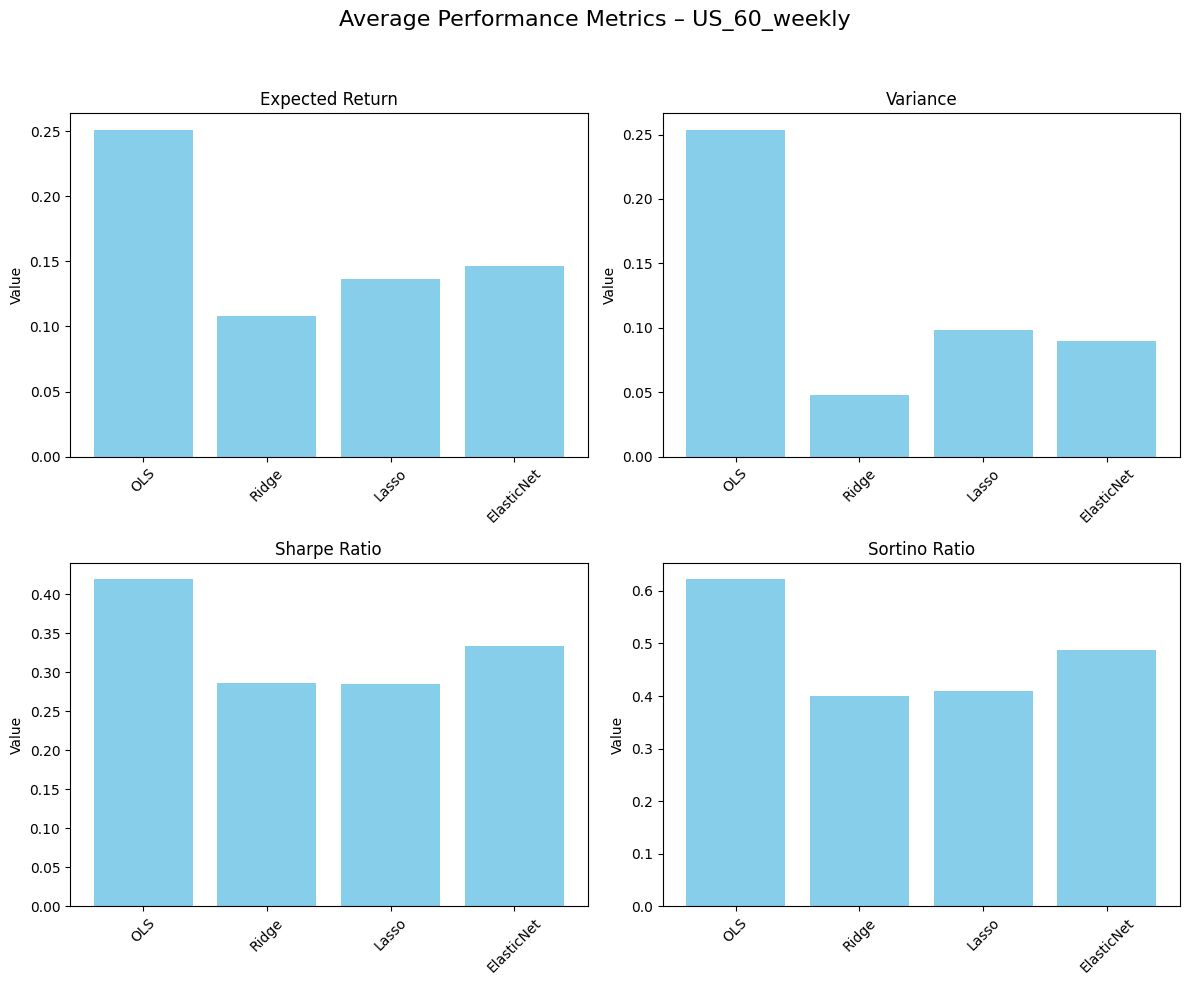



=== Running market: US, Subset size: 200, Frequency: weekly ===
Running OLS for US-200 with 32 subsets...


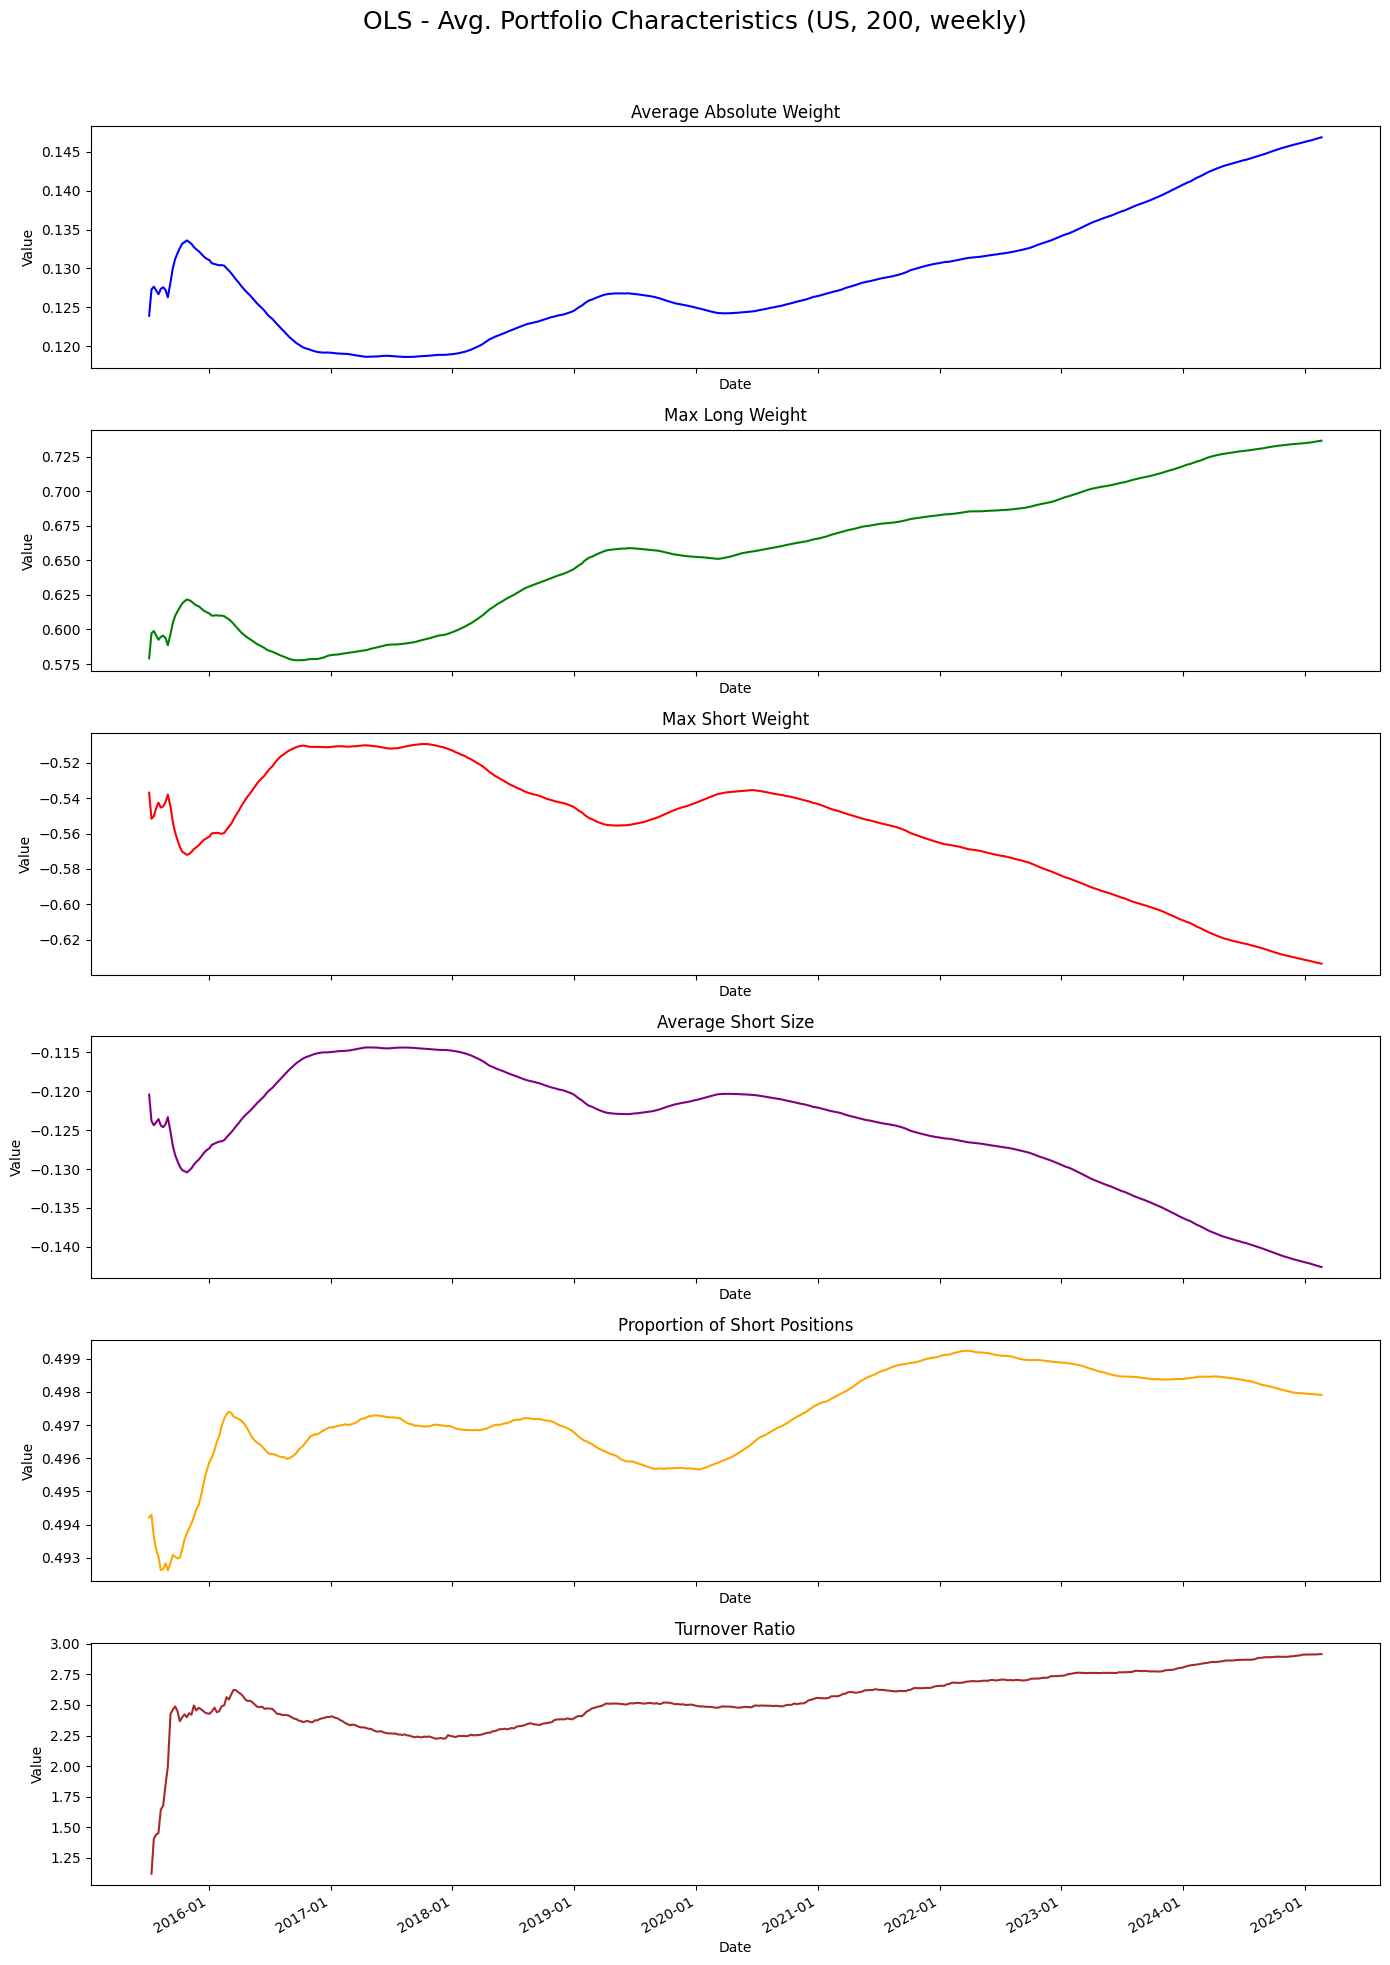

Running Ridge for US-200 with 32 subsets...


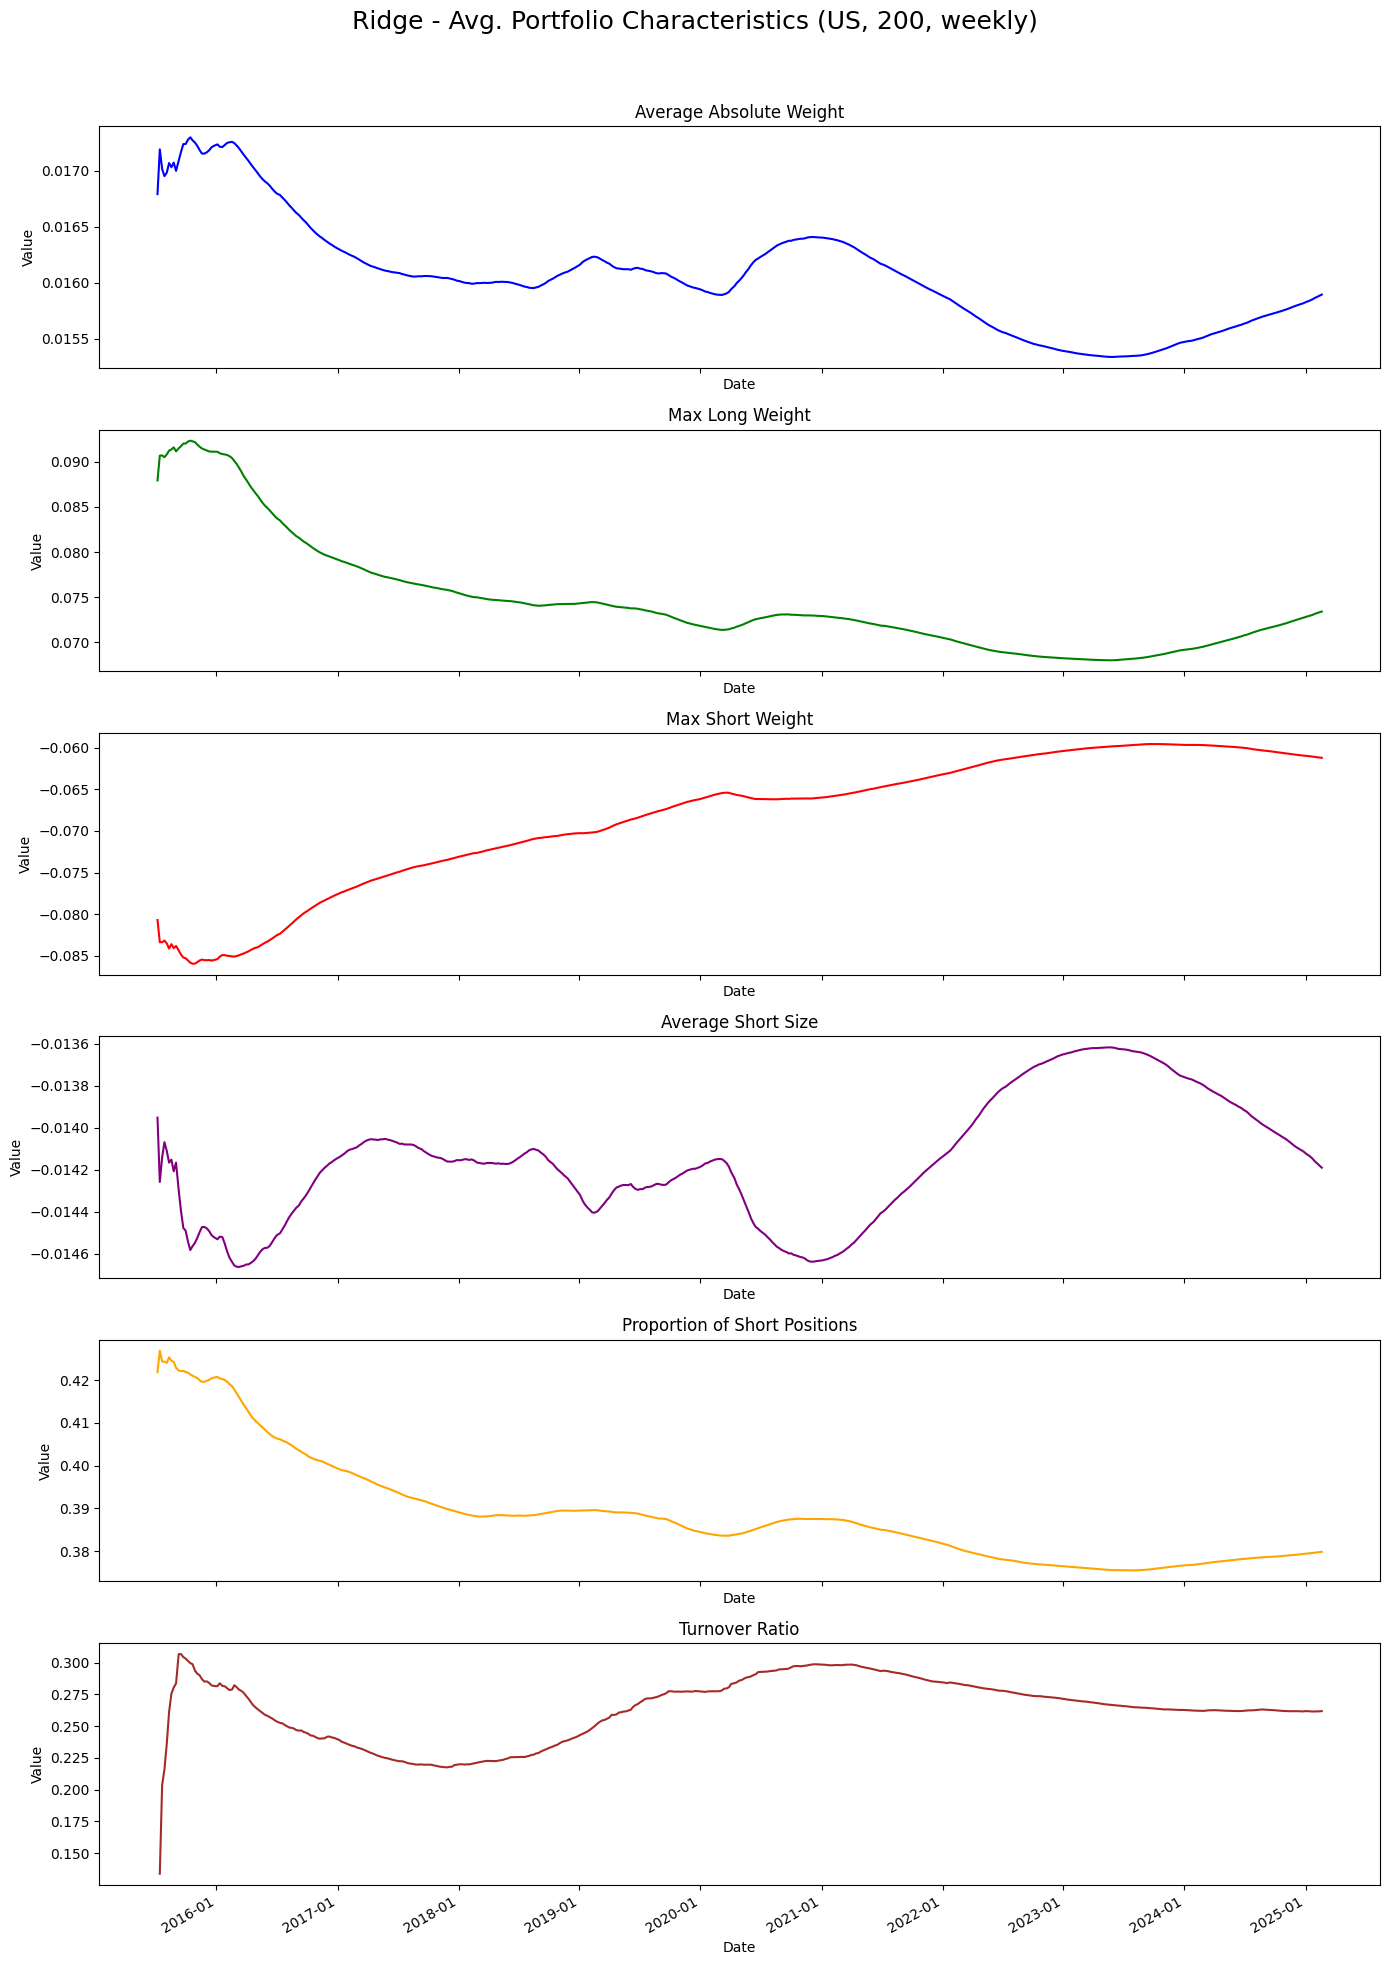

Running Lasso for US-200 with 32 subsets...


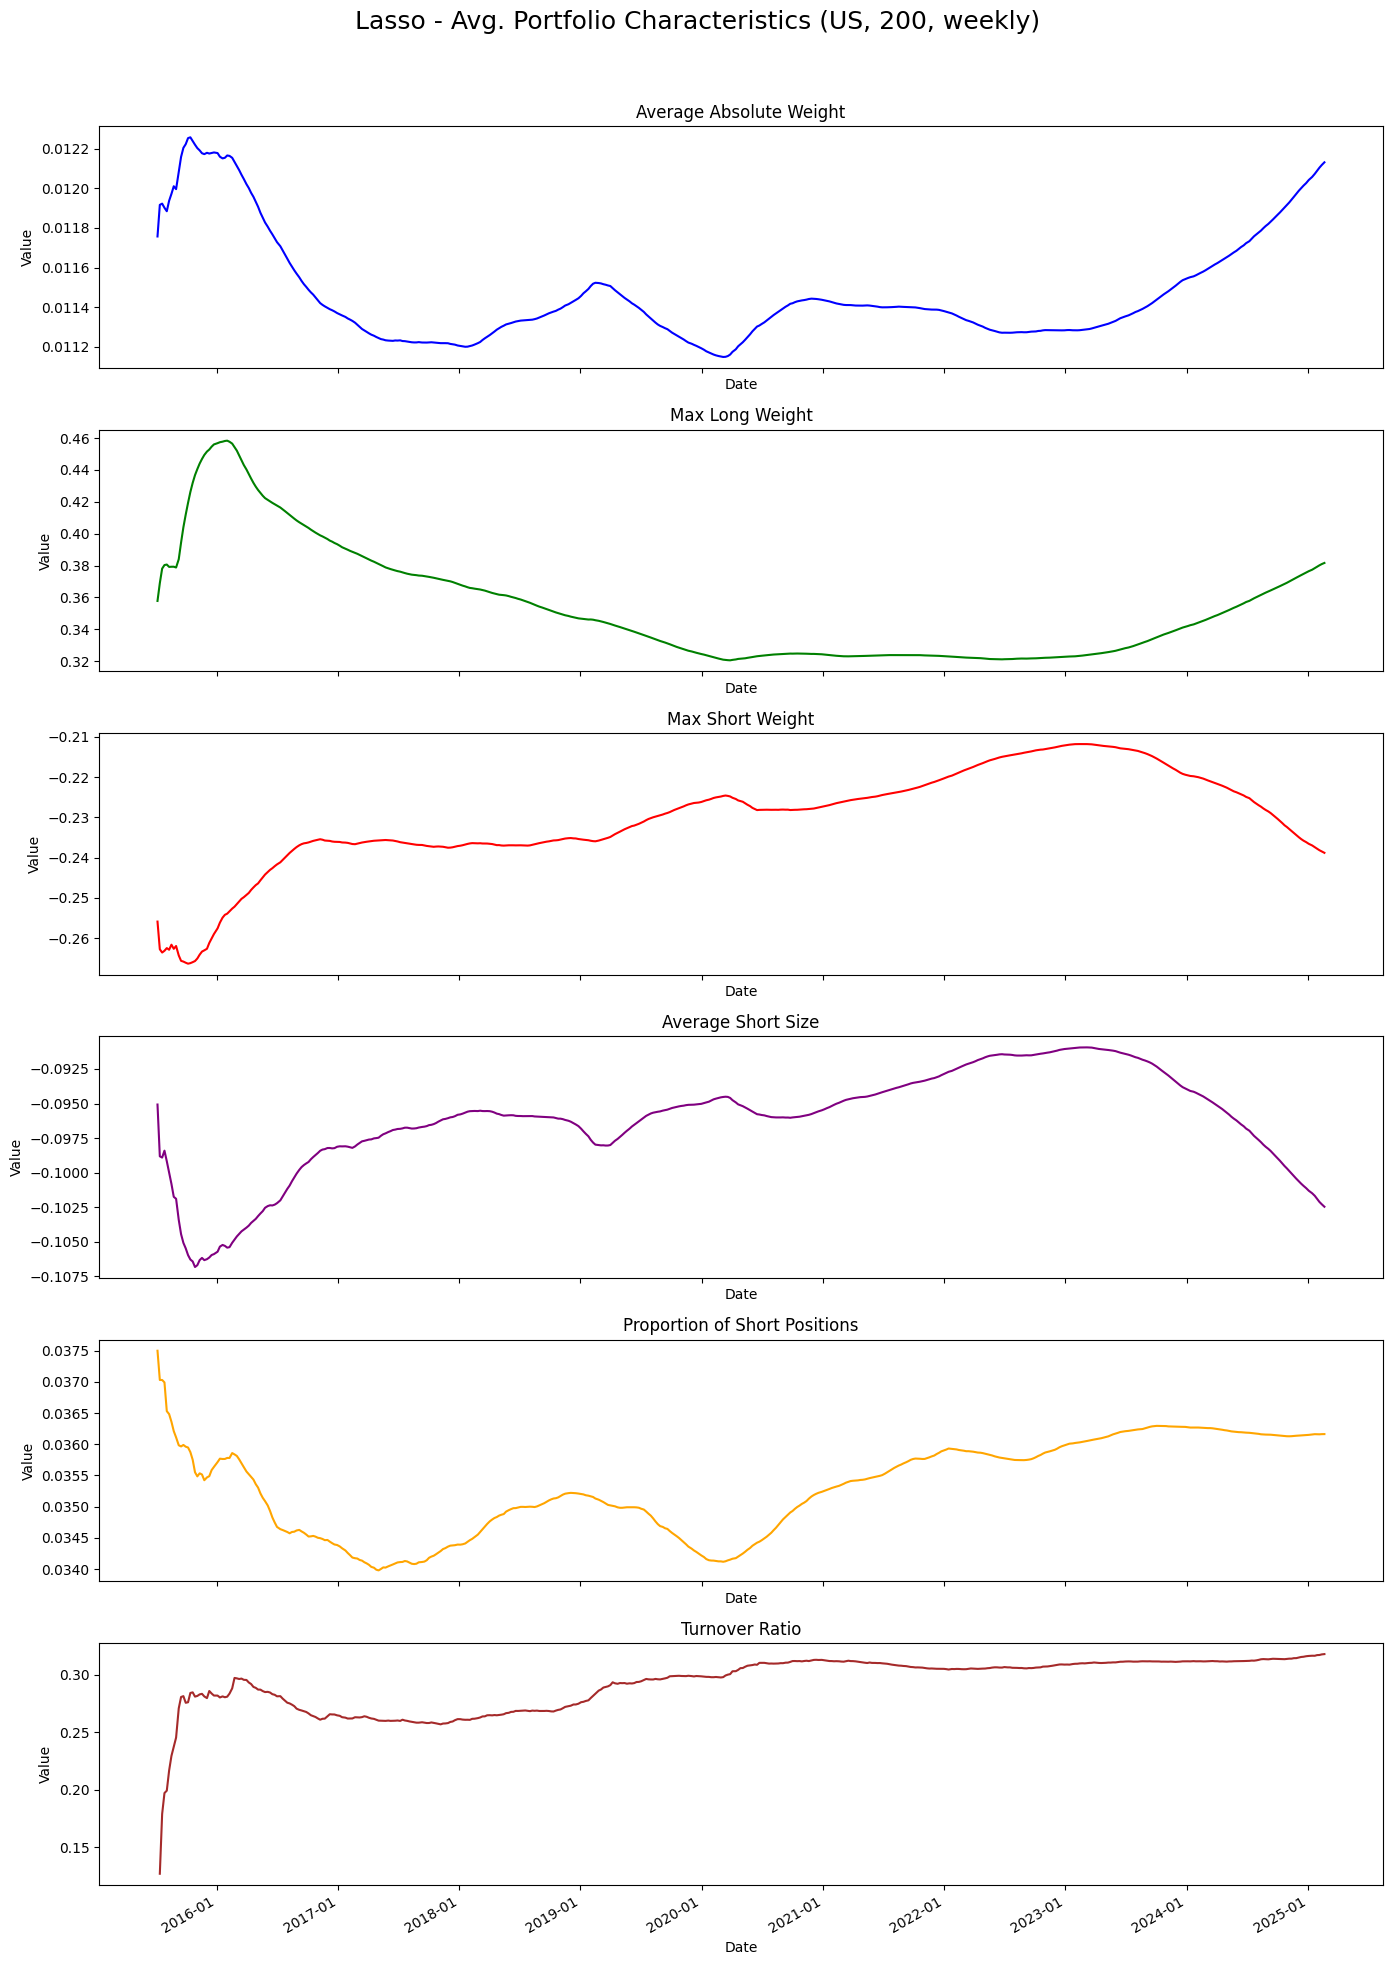

Running ElasticNet for US-200 with 32 subsets...


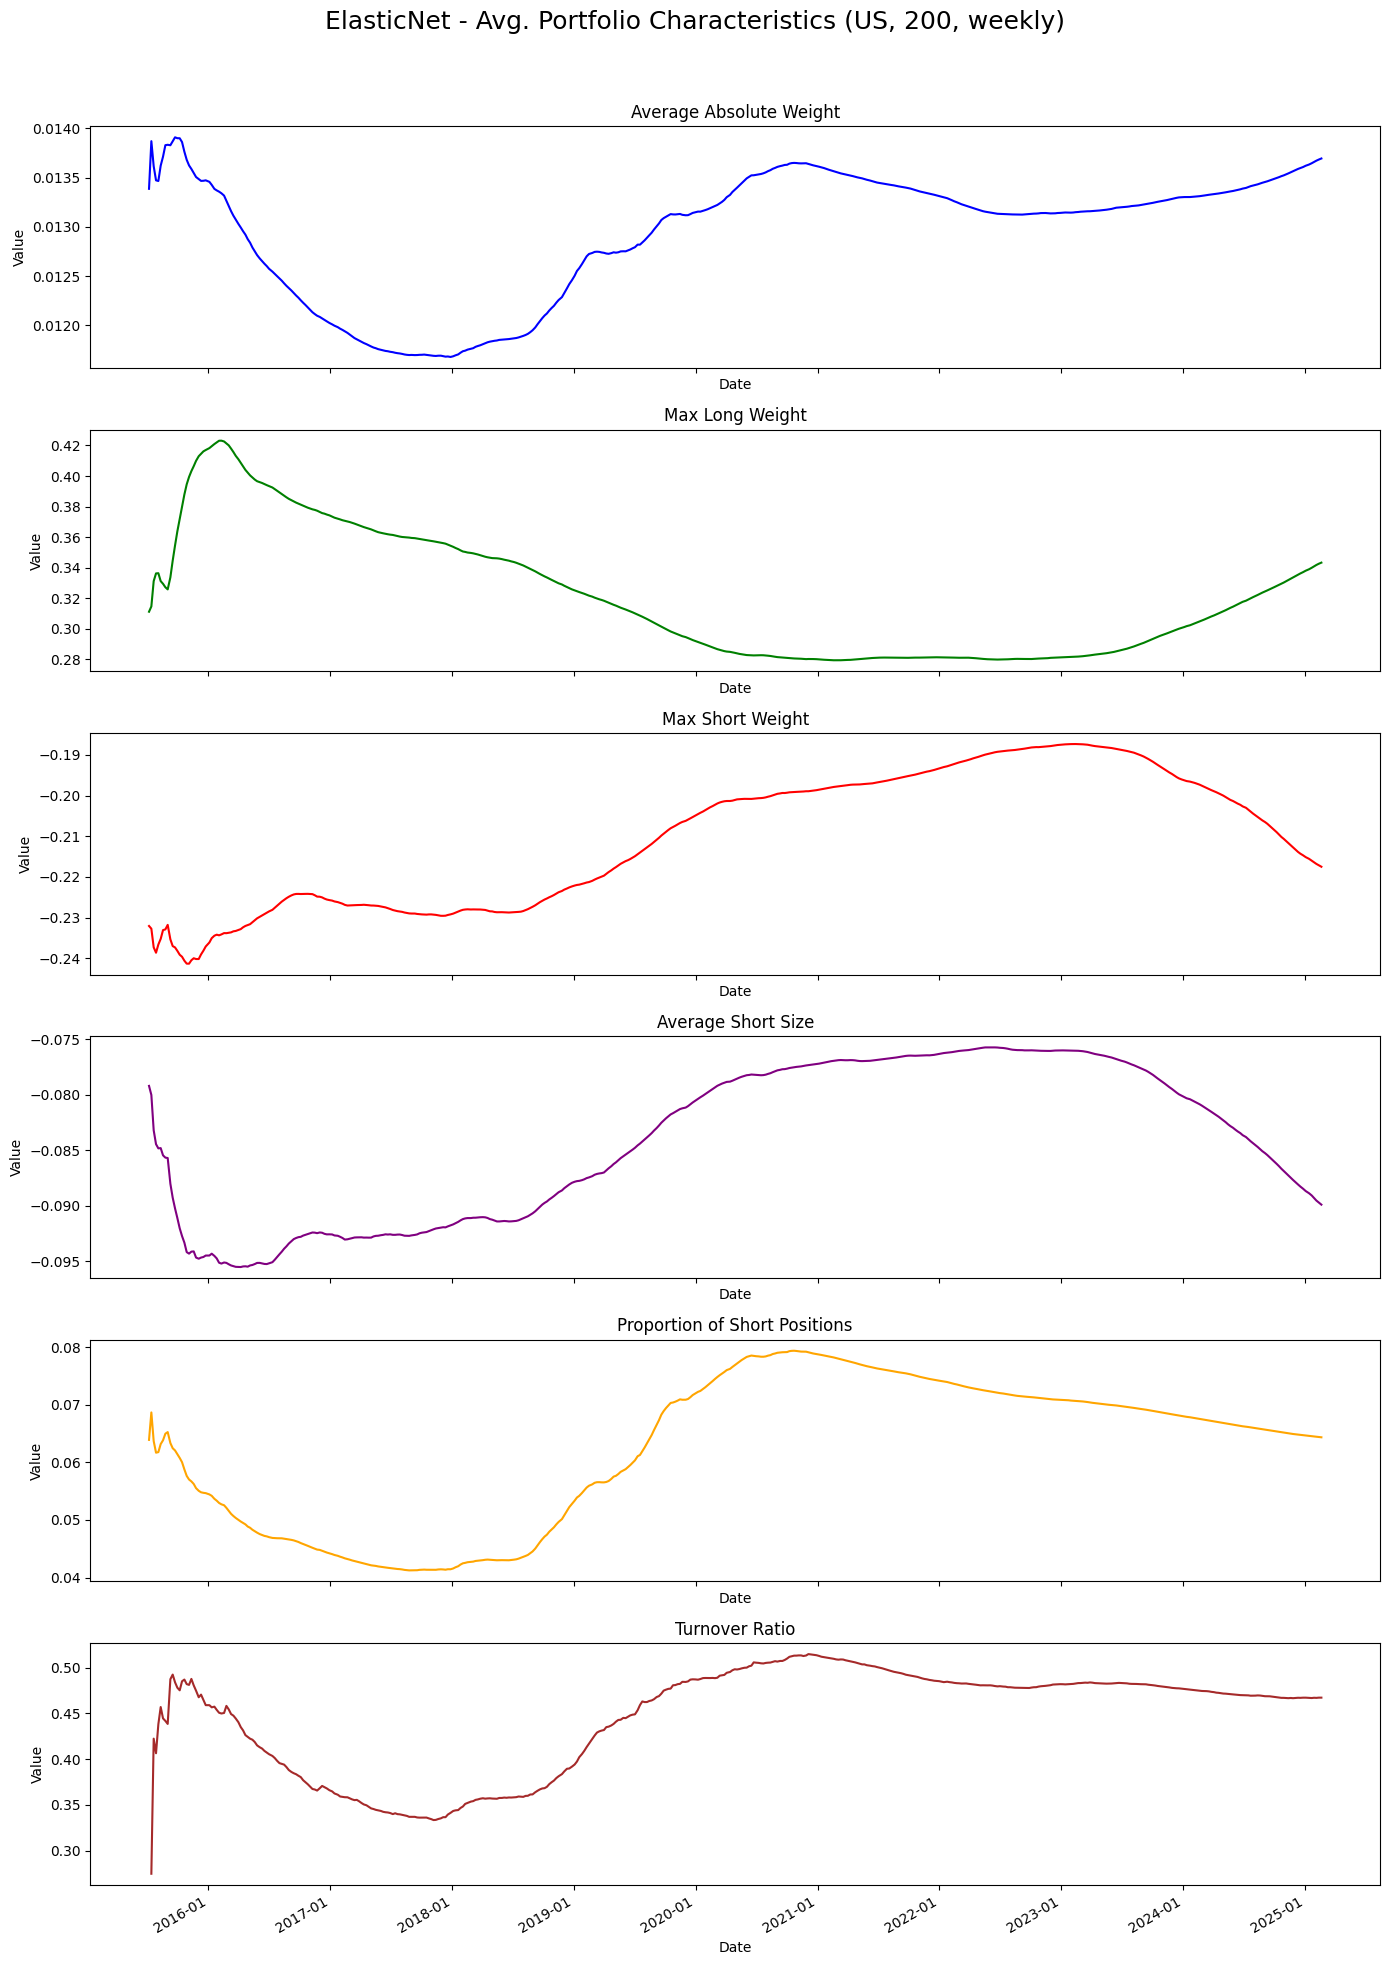


Results for OLS (US-200, weekly):
Expected Return (Annualized): [np.float64(0.14897348136373148), np.float64(0.37842305343684335), np.float64(0.27251542031573184), np.float64(0.18086322987287232), np.float64(0.19912599454695284), np.float64(0.5666013022573348), np.float64(0.3977210879864234), np.float64(0.36583730975987644), np.float64(0.5728859408924554), np.float64(0.22101445498875338), np.float64(0.07611184830207665), np.float64(0.17861907149038142), np.float64(0.27682342638489227), np.float64(0.3408002231831), np.float64(0.09436199563935582), np.float64(0.4129793437136945), np.float64(0.1218372579336777), np.float64(0.3513027495797091), np.float64(0.494569779405648), np.float64(0.3186261445162609), np.float64(0.25804607761224174), np.float64(0.14925462084469693), np.float64(0.22166611194547128), np.float64(0.17196202152771908), np.float64(0.18202975644196115), np.float64(0.3434931224246411), np.float64(0.4806362047114162), np.float64(0.2538460553990163), np.float64(0.3133794995399

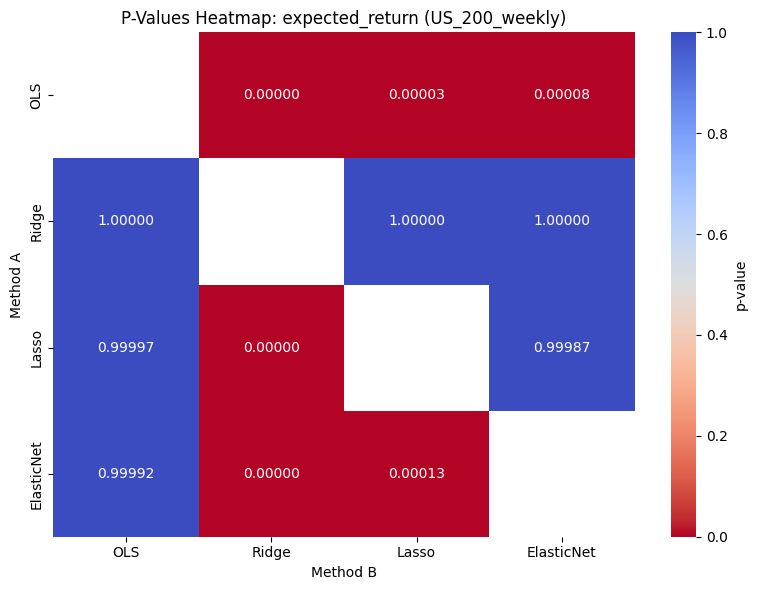

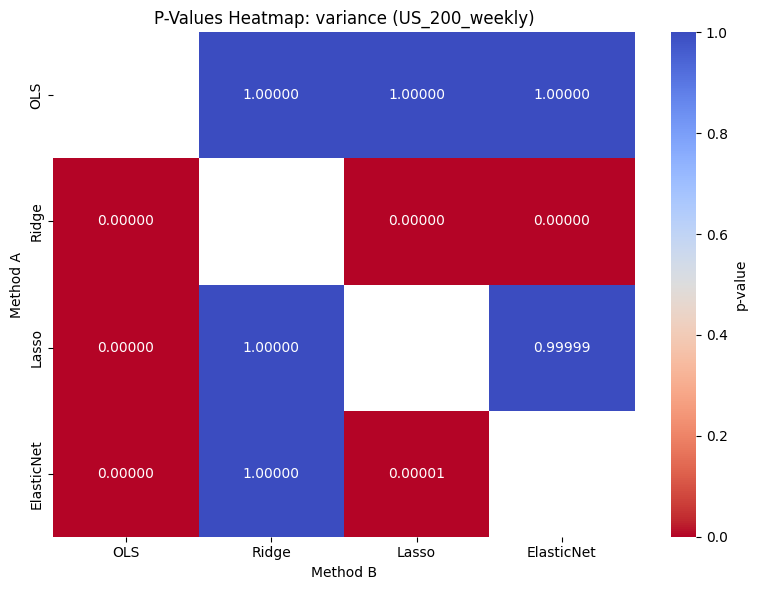

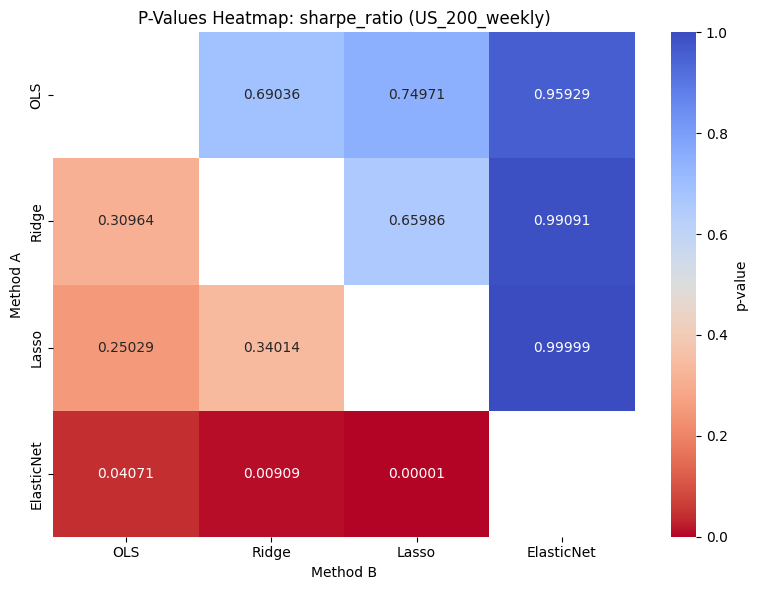

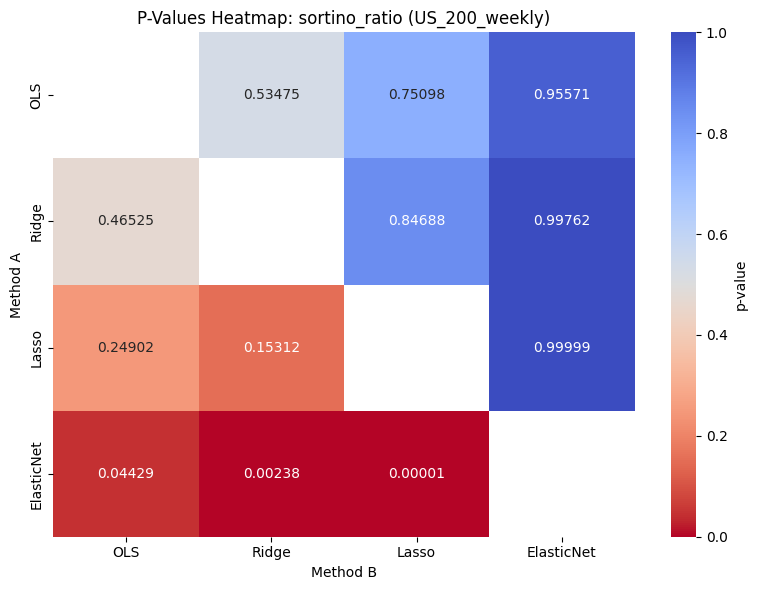

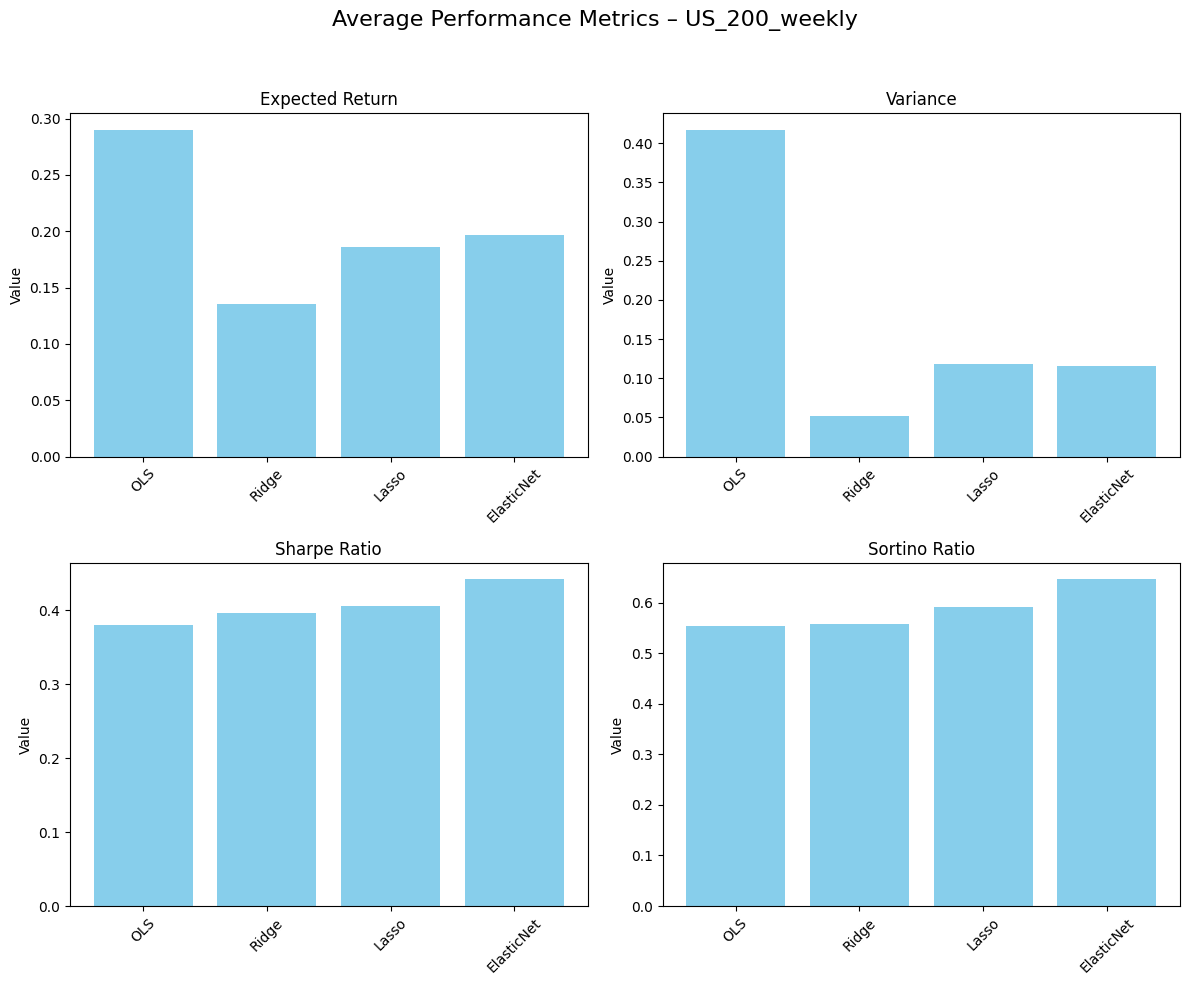


=== Summary plots for OLS ===


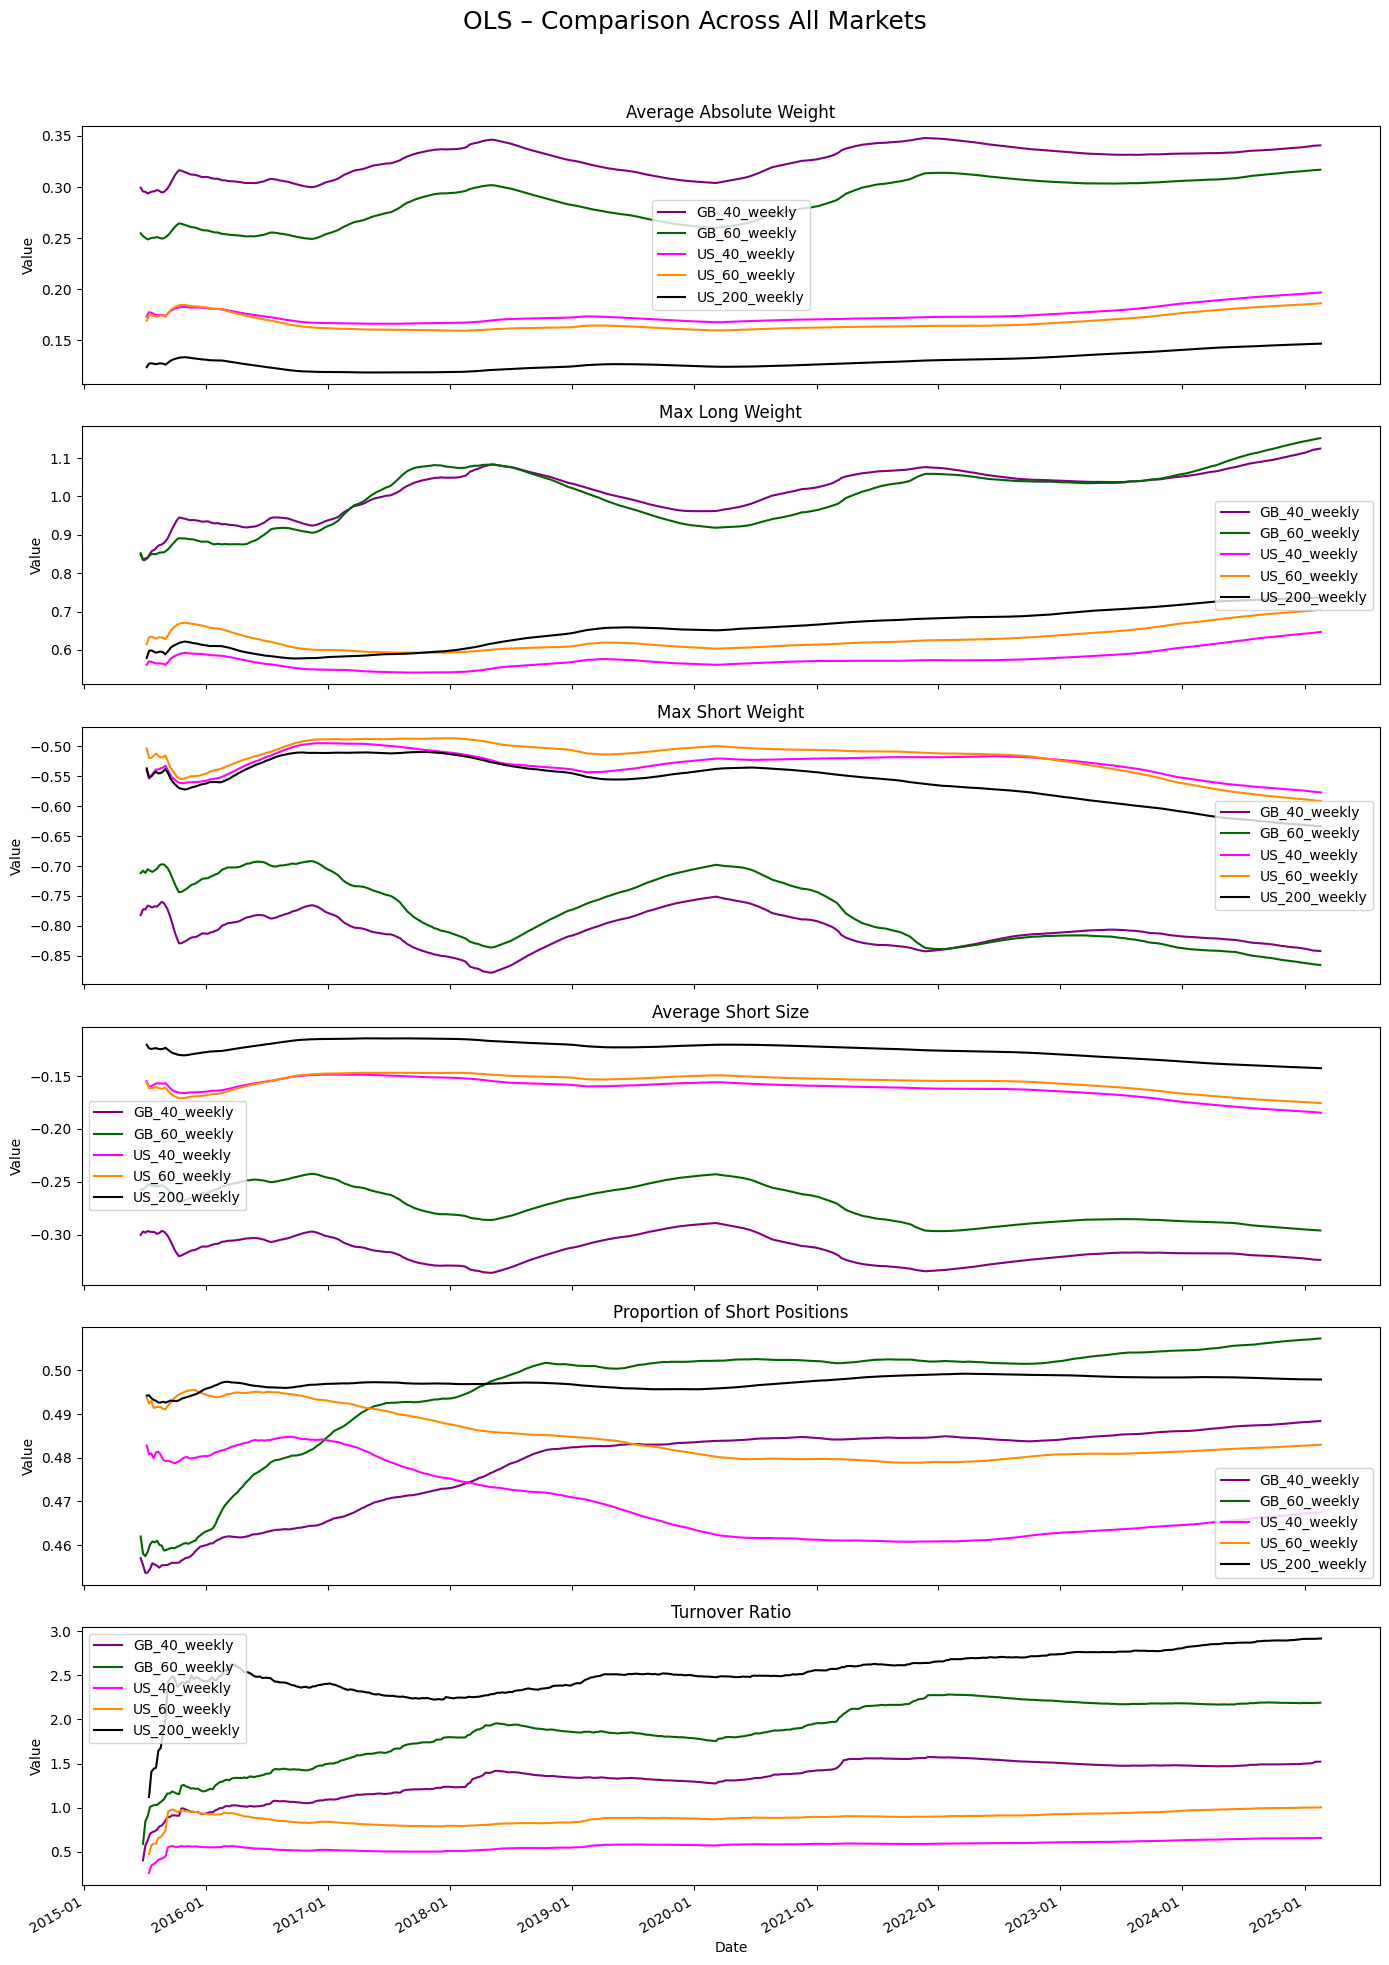


=== Summary plots for Ridge ===


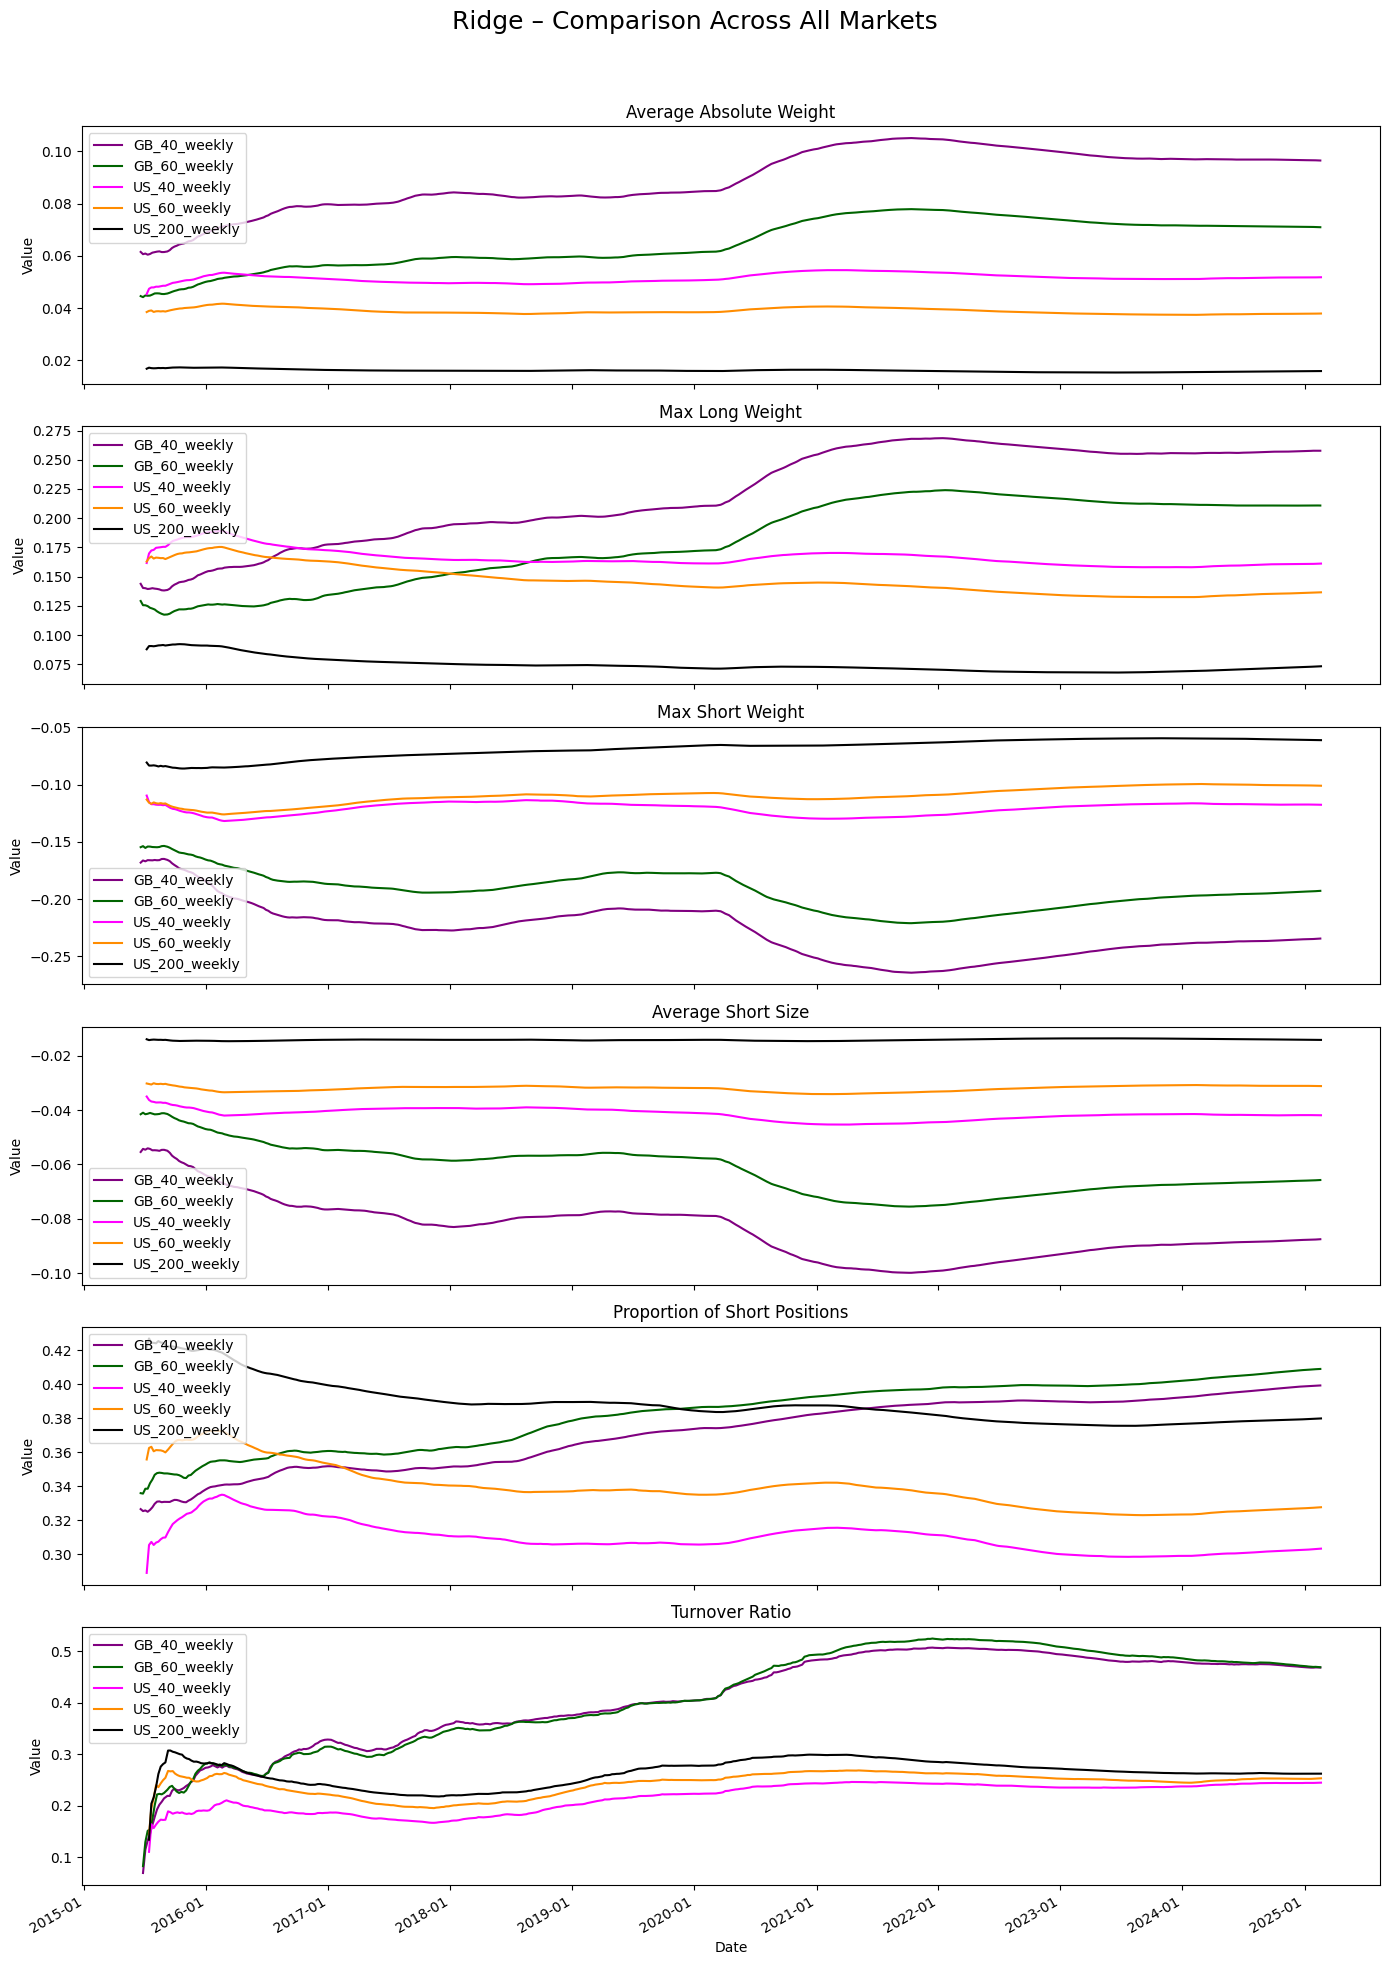


=== Summary plots for Lasso ===


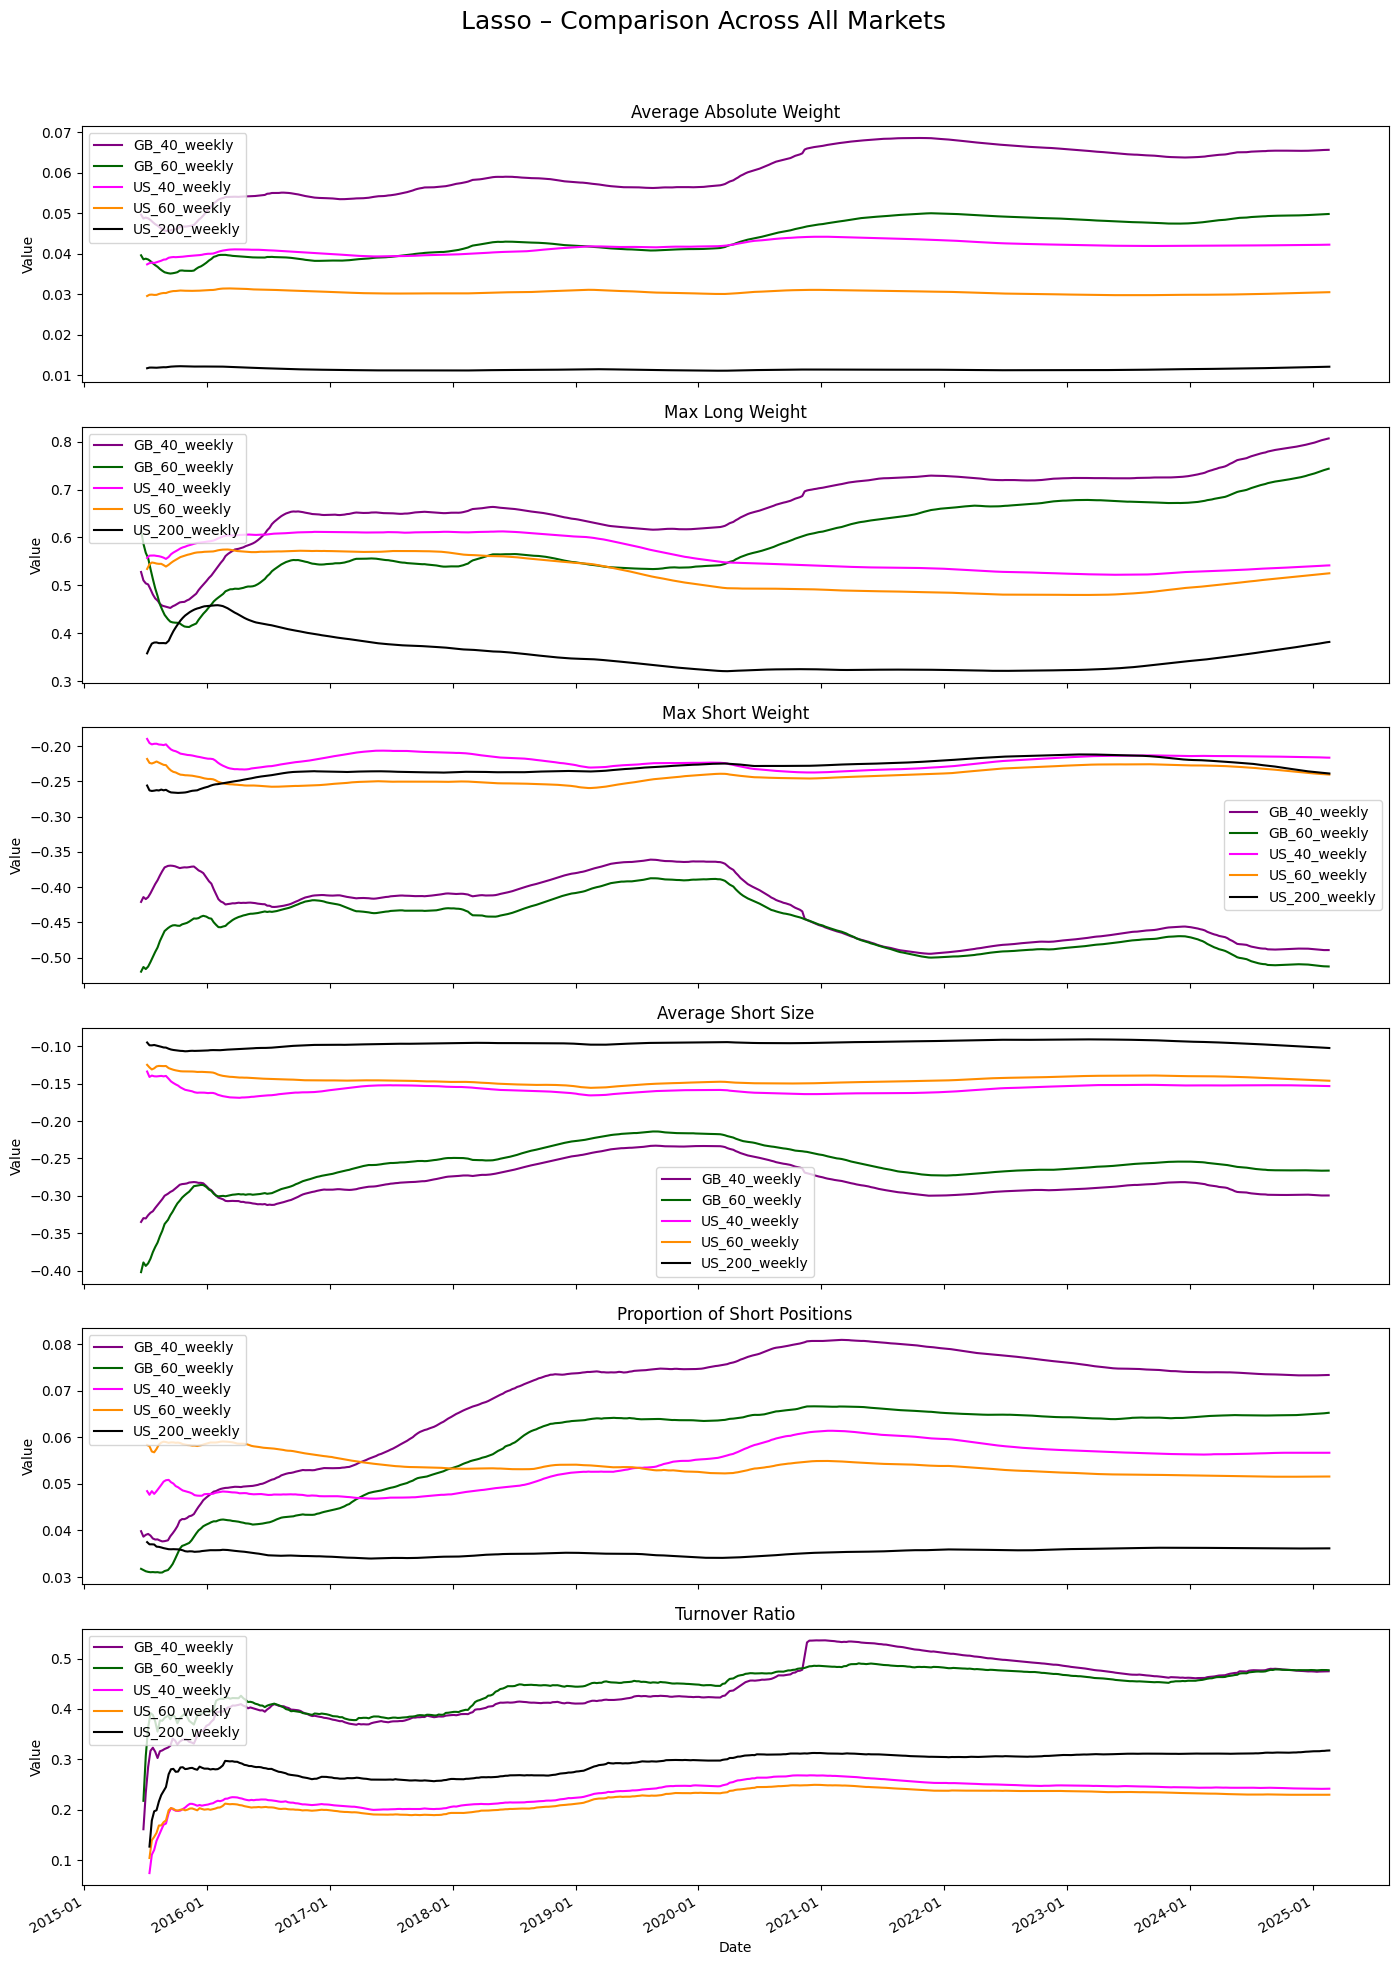


=== Summary plots for ElasticNet ===


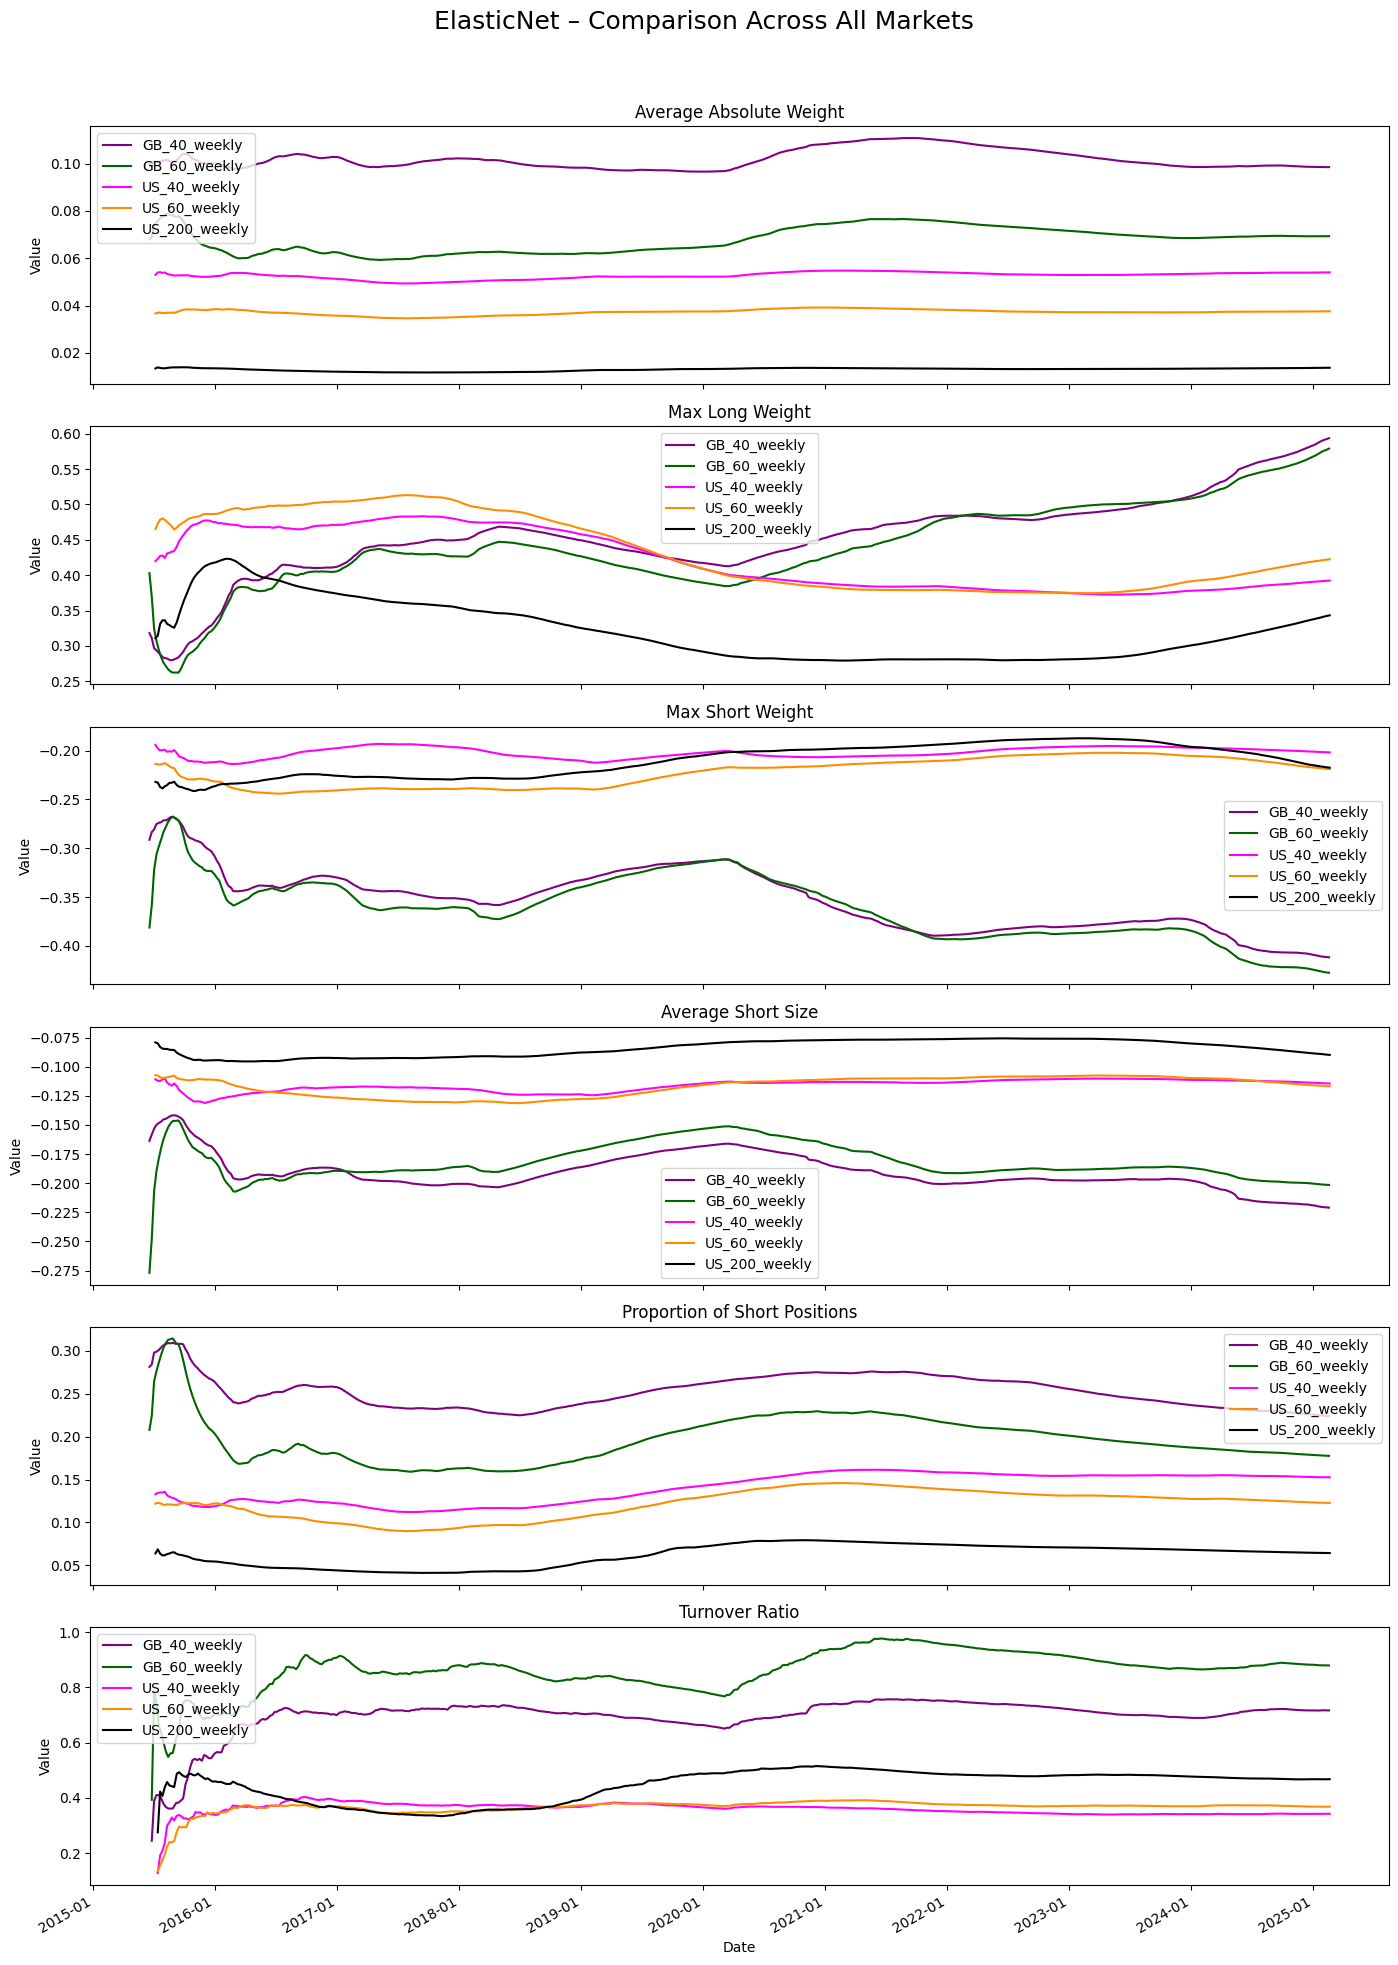

In [46]:
# === PARAMETERS ===
frequency = "weekly"  # "daily" or "weekly"

markets_to_run = [("GB", 40), ("GB", 60), ("US", 40), ("US", 60), ("US", 200)]

all_results = {}
all_weights = {}
all_market_dates = {}

for market, subset_size in markets_to_run:
    results, weights, df_market_used = run_market_analysis(
        market, subset_size, num_subsets=32, frequency=frequency
    )
    key = f"{market}_{subset_size}_{frequency}"
    all_results[key] = results
    all_weights[key] = weights
    all_market_dates[key] = df_market_used

# After running all markets
plot_summary_weight_characteristics(all_weights, all_market_dates)
